In [1]:
%load_ext autoreload 
%autoreload 2
import cv2
import json, os, cv2
from pathlib import Path
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import xarray as xr
import seaborn as sns
import h5py as hf
from tqdm import tqdm
from tqdm import tqdm
import itertools 
from scipy.interpolate import interp1d
from scipy import signal
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
import os, fnmatch
from scipy.spatial.distance import cdist

import sys
sys.path.insert(0, 'C:/Users/nlab/Documents/GitHub/obstacle_avoidance')
#sys.path.append(r'C:\Users\nlab\Documents\GitHub\obstacle_avoidance\plots') # go to parent dir 

from utils.base_functions import *
from src.utils.auxiliary import flatten_series
from src.utils.path import find
from src.base import BaseInput
from plots.plots import plot_oa
#from plots.plots import *
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
c:\Users\nlab\anaconda3\envs\ephys0\lib\site-packages\deeplabcut\__init__.py:78: UserWarning: 
        As PyTorch is not installed, unsupervised identity learning will not be available.
        Please run `pip install torch`, or ignore this warning.
        
  warnings.warn(


In [2]:
light = plot_oa(r"D:\obstacle_avoidance\metadata\compiled_data\G8CK1_G8CK_light.json",'blank')
light.gather_session_df('obstacle',6)

dark = plot_oa(r"D:\obstacle_avoidance\metadata\compiled_data\G8CK1_G8CK_dark.json",'blank')
dark.gather_session_df('obstacle',6)
light_df,dark_df = light.df, dark.df

6
6


In [3]:
def ts_postition_through_threshold(df,thresh):
    for direction, direction_frame in df.groupby(['odd']):
            for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
                  for ind,row in cluster_frame.iterrows():
                        if direction == 'right':
                            if cluster == 0 or cluster == 1:
                                pos_inds =  np.where((row['ts_nose_x_cm'] >(row['gt_obstacleTR_x_cm'])) & (row['ts_nose_x_cm'] <(row['gt_obstacleTR_x_cm']+(thresh))))
                                thresh_nose_x = row['ts_nose_x_cm'][pos_inds]
                                thresh_nose_y = row['ts_nose_y_cm'][pos_inds]                                
                                df.at[ind,'ts_nose_x_cm_' + str(thresh)] = thresh_nose_x.astype(object)
                                df.at[ind,'ts_nose_y_cm_' + str(thresh)] = thresh_nose_y.astype(object)
                                df.at[ind,'thresh_ind_through_'+str(thresh)] = pos_inds[0].astype(object)
                                #df.at[ind,'angle_to_corner_' + str(thresh)] = degs.astype(object)
                            if cluster == 2 or cluster == 3:
                                   if row['start'] == 'top':
                                        pos_inds =  np.where((row['ts_nose_x_cm'] >(row['gt_obstacleTR_x_cm'])) & (row['ts_nose_x_cm'] <(row['gt_obstacleTR_x_cm']+(thresh))))                           
                                        thresh_nose_x = row['ts_nose_x_cm'][pos_inds]
                                        thresh_nose_y = row['ts_nose_y_cm'][pos_inds]
                                        df.at[ind,'ts_nose_x_cm_' + str(thresh)] = thresh_nose_x.astype(object)
                                        df.at[ind,'ts_nose_y_cm_' + str(thresh)] = thresh_nose_y.astype(object)
                                        df.at[ind,'thresh_ind_through_'+str(thresh)] = pos_inds[0].astype(object)
                                       
                                        
                                   if row['start'] == 'bottom':
                                        pos_inds =  np.where((row['ts_nose_x_cm'] >(row['gt_obstacleTR_x_cm'])) & (row['ts_nose_x_cm'] <(row['gt_obstacleTR_x_cm']+(thresh))))                    
                                        thresh_nose_x = row['ts_nose_x_cm'][pos_inds]
                                        thresh_nose_y = row['ts_nose_y_cm'][pos_inds]
                                        df.at[ind,'ts_nose_x_cm_' + str(thresh)] = thresh_nose_x.astype(object)
                                        df.at[ind,'ts_nose_y_cm_' + str(thresh)] = thresh_nose_y.astype(object)
                                        df.at[ind,'thresh_ind_through_'+str(thresh)] = pos_inds[0].astype(object)
                                       
                                        
                            if cluster == 4 or cluster == 5:
                                pos_inds =  np.where((row['ts_nose_x_cm'] >(row['gt_obstacleTR_x_cm'])) & (row['ts_nose_x_cm'] <(row['gt_obstacleTR_x_cm']+(thresh))))
                                thresh_nose_x = row['ts_nose_x_cm'][pos_inds]
                                thresh_nose_y = row['ts_nose_y_cm'][pos_inds]                                
                                df.at[ind,'ts_nose_x_cm_' + str(thresh)] = thresh_nose_x.astype(object)
                                df.at[ind,'ts_nose_y_cm_' + str(thresh)] = thresh_nose_y.astype(object)
                                df.at[ind,'thresh_ind_through_'+str(thresh)] = pos_inds[0].astype(object)
                        if direction == 'left':
                            if cluster == 0 or cluster == 1:
                                pos_inds =  np.where((row['ts_nose_x_cm'] <(row['gt_obstacleTL_x_cm'])) & (row['ts_nose_x_cm'] >(row['gt_obstacleTL_x_cm']-(thresh))))
                                thresh_nose_x = row['ts_nose_x_cm'][pos_inds]
                                thresh_nose_y = row['ts_nose_y_cm'][pos_inds]                                
                                df.at[ind,'ts_nose_x_cm_' + str(thresh)] = thresh_nose_x.astype(object)
                                df.at[ind,'ts_nose_y_cm_' + str(thresh)] = thresh_nose_y.astype(object)
                                df.at[ind,'thresh_ind_through_'+str(thresh)] = pos_inds[0].astype(object)
                                 
                            if cluster == 2 or cluster == 3:
                                 if row['start'] == 'top':
                                        pos_inds =  np.where((row['ts_nose_x_cm'] <(row['gt_obstacleTL_x_cm'])) & (row['ts_nose_x_cm'] >(row['gt_obstacleTL_x_cm']-(thresh))))
                                        thresh_nose_x = row['ts_nose_x_cm'][pos_inds]
                                        thresh_nose_y = row['ts_nose_y_cm'][pos_inds]
                                        df.at[ind,'ts_nose_x_cm_' + str(thresh)] = thresh_nose_x.astype(object)
                                        df.at[ind,'ts_nose_y_cm_' + str(thresh)] = thresh_nose_y.astype(object)
                                        df.at[ind,'thresh_ind_through_'+str(thresh)] = pos_inds[0].astype(object) 
                                       
                                 
                                        
                                 if row['start'] == 'bottom':
                                        pos_inds =   np.where((row['ts_nose_x_cm'] <(row['gt_obstacleTL_x_cm'])) & (row['ts_nose_x_cm'] >(row['gt_obstacleTL_x_cm']-(thresh))))
                                        thresh_nose_x = row['ts_nose_x_cm'][pos_inds]
                                        thresh_nose_y = row['ts_nose_y_cm'][pos_inds]
                                        df.at[ind,'ts_nose_x_cm_' + str(thresh)] = thresh_nose_x.astype(object)
                                        df.at[ind,'ts_nose_y_cm_' + str(thresh)] = thresh_nose_y.astype(object)
                                        df.at[ind,'thresh_ind_through_'+str(thresh)] = pos_inds[0].astype(object)
                                       
                                 
                            if cluster == 4 or cluster == 5:
                                pos_inds =  np.where((row['ts_nose_x_cm'] <(row['gt_obstacleTL_x_cm'])) & (row['ts_nose_x_cm'] >(row['gt_obstacleTL_x_cm']-(thresh))))
                                thresh_nose_x = row['ts_nose_x_cm'][pos_inds]
                                thresh_nose_y = row['ts_nose_y_cm'][pos_inds]                                
                                df.at[ind,'ts_nose_x_cm_' + str(thresh)] = thresh_nose_x.astype(object)
                                df.at[ind,'ts_nose_y_cm_' + str(thresh)] = thresh_nose_y.astype(object)
                                df.at[ind,'thresh_ind_through_'+str(thresh)] = pos_inds[0].astype(object)

In [4]:
def calculate_relative_distance(df):
    """calculates relavtive distance of nose to point on obstacle"""
    for direction, direction_frame in df.groupby(['odd']):
        for ind,row in direction_frame.iterrows():  
            if direction == 'right':
                try:
                    nose_x = row['ts_nose_x_cm']
                    nose_y = row['ts_nose_y_cm']
                    distances = []
                    for i,e in enumerate(nose_x):
                        obstalce_x = np.mean([row['gt_obstacleTR_x_cm'],row['gt_obstacleBR_x_cm']]) 
                        if nose_y[i] > row['gt_obstacleTR_y_cm'] and nose_y[i] < row['gt_obstacleBR_y_cm'] :
                            obstalce_y = nose_y[i]
                            if nose_x[i] < obstalce_x:
                                distance = np.abs(calculate_distances(nose_x[i],nose_y[i],obstalce_x,obstalce_y)) * -1
                                distances.append(distance)
                            if nose_x[i] > obstalce_x:
                                distance = np.abs(calculate_distances(nose_x[i],nose_y[i],obstalce_x,obstalce_y)) 
                                distances.append(distance)
                            
                        else:
                            distance_to_top = np.abs(calculate_distances(nose_x[i],nose_y[i],obstalce_x,row['gt_obstacleTR_y_cm']))
                            distance_to_bottom = np.abs(calculate_distances(nose_x[i],nose_y[i],obstalce_x,row['gt_obstacleBR_y_cm']))
                            if distance_to_top < distance_to_bottom:
                                distance = distance_to_top
                                if nose_x[i] < obstalce_x:
                                    distance = distance * -1
                                    distances.append(distance)
                                if nose_x[i] > obstalce_x:
                                    distance = distance 
                                    distances.append(distance)
                            if distance_to_top > distance_to_bottom:
                                distance = distance_to_bottom
                                if nose_x[i] < obstalce_x:
                                    distance = distance * -1
                                    distances.append(distance)
                                if nose_x[i] > obstalce_x:
                                    distance = distance 
                                    distances.append(distance)
                except IndexError:
                    distances.append(np.nan)

                
                df.at[ind,'distance_from_edge'] = np.array(distances).astype(object)
                df.at[ind,'len_distance_from_edge'] = np.array(distances).astype(object).size
            if direction =='left':
                try:
                    nose_x = row['ts_nose_x_cm']
                    nose_y = row['ts_nose_y_cm']
                    distances = []
                    for i,e in enumerate(nose_x):
                        obstalce_x = np.mean([row['gt_obstacleTL_x_cm'],row['gt_obstacleBL_x_cm']]) 
                        if nose_y[i] > row['gt_obstacleTL_y_cm'] and nose_y[i] < row['gt_obstacleBL_y_cm']:
                            obstalce_y = nose_y[i]
                            if nose_x[i] > obstalce_x:
                                distance = np.abs(calculate_distances(nose_x[i],nose_y[i],obstalce_x,obstalce_y)) * -1
                                distances.append(distance)
                            if nose_x[i] < obstalce_x:
                                distance = np.abs(calculate_distances(nose_x[i],nose_y[i],obstalce_x,obstalce_y)) 
                                distances.append(distance)
                        else:
                            distance_to_top = np.abs(calculate_distances(nose_x[i],nose_y[i],obstalce_x,row['gt_obstacleTL_y_cm']))
                            distance_to_bottom = np.abs(calculate_distances(nose_x[i],nose_y[i],obstalce_x,row['gt_obstacleBL_y_cm']))
                            if distance_to_top < distance_to_bottom:
                                distance = distance_to_top
                                if nose_x[i] > obstalce_x:
                                    distance = distance * -1
                                    distances.append(distance)
                                if nose_x[i] < obstalce_x:
                                    distance = distance 
                                    distances.append(distance)
                            if distance_to_top > distance_to_bottom:
                                distance = distance_to_bottom
                                if nose_x[i] > obstalce_x:
                                    distance = distance * -1
                                    distances.append(distance)
                                if nose_x[i] < obstalce_x:
                                    distance = distance 
                                    distances.append(distance)
                except IndexError:
                    distances.append(np.nan)
            
                
                df.at[ind,'distance_from_edge'] = np.array(distances).astype(object)
                df.at[ind,'len_distance_from_edge'] = np.array(distances).astype(object).size

def calculate_distances(x_points, y_points, x_reference, y_reference):
    """
    Calculate the distances of a set of (x, y) points from a reference point.

    Args:
        x_points (array-like): Array of x-coordinates of the points.
        y_points (array-like): Array of y-coordinates of the points.
        x_reference (float): The x-coordinate of the reference point.
        y_reference (float): The y-coordinate of the reference point.

    Returns:
        list: List of distances from the reference point to each point in the set.
    """
    # Convert input arrays to NumPy arrays
    x_points = np.array(x_points)
    y_points = np.array(y_points)

    # Calculate the distances
    distances = np.sqrt((x_points - x_reference)**2 + (y_points - y_reference)**2)

    return distances


In [5]:
calculate_relative_distance(light_df)
calculate_relative_distance(dark_df)

In [7]:


def calculate_vector_between_points(point1, point2):
    """
    Calculate the vector between two (x, y) points.

    Args:
        point1 (tuple or list): The coordinates of the first point (x1, y1).
        point2 (tuple or list): The coordinates of the second point (x2, y2).

    Returns:
        np.ndarray: The vector as a NumPy array [dx, dy].
    """
    x1, y1 = point1
    x2, y2 = point2
    
    dx = x2 - x1
    dy = y2 - y1
    
    vector = np.array([dx, dy])
    
    return vector


def angle_between_vectors(vector1, vector2):
    # Convert input lists to NumPy arrays for vector operations
    vector1 = np.array(vector1)
    vector2 = np.array(vector2)
    
    # Calculate the dot product of the two vectors
    dot_product = np.dot(vector1, vector2)
    
    # Calculate the magnitudes (norms) of each vector
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)
    
    # Calculate the cosine of the angle between the vectors
    cosine_angle = dot_product / (magnitude1 * magnitude2)
    
    # Use arccosine to calculate the angle in radians
    angle_radians = np.arccos(cosine_angle)
    
    # Calculate the angle in degrees
    angle_degrees = np.degrees(angle_radians)
    
    return angle_radians, angle_degrees


In [10]:
angle_to_open_corner(light_df)
angle_to_open_corner(dark_df)

In [9]:
def angle_to_open_corner(df):
    """get angel of nose to open corner at a hold"""
    for direction, direction_frame in df.groupby(['odd']):
            for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
                  for ind,row in cluster_frame.iterrows():
                        if direction == 'right':
                            if cluster == 0 or cluster == 1:
                                nose_x = row['ts_nose_x_cm'].astype(float)
                                nose_y = row['ts_nose_y_cm'].astype(float)
                                ear_x = np.mean([row['ts_rightear_x_cm'],row['ts_leftear_x_cm']],axis=0)
                                ear_y = np.mean([row['ts_rightear_y_cm'],row['ts_leftear_y_cm']],axis=0)
                                corner_x = row['gt_obstacleBR_x_cm']
                                corner_y = row['gt_obstacleBR_y_cm']
                                degs = []
                                rads = []
                                for i in list(range(len(nose_x))):
                                    vector1 = calculate_vector_between_points((ear_x[i],ear_y[i]),(nose_x[i],nose_y[i]))# vector from ear to nose
                                    vector2 = calculate_vector_between_points((nose_x[i],nose_y[i]),(corner_x,corner_y))# vector from nose to open corner
                                    rad,deg = angle_between_vectors(vector1,vector2)
                                    degs.append(deg)
                                    rads.append(rad)
                                degs = np.array(degs)
                                #df.at[ind,'angle_to_corner_' + str()] = degs.astype(object)
                                try:
                                 df.at[ind,'angle_to_corner'] = degs.astype(object)
                                except ValueError:
                                    print(degs)
                                except IndexError:
                                    df.at[ind,'angle_to_corner'] = np.nan
                            if cluster == 2 or cluster == 3:
                                    nose_x = row['ts_nose_x_cm'].astype(float)
                                    nose_y = row['ts_nose_y_cm'].astype(float)
                                    ear_x = np.mean([row['ts_rightear_x_cm'],row['ts_leftear_x_cm']],axis=0)
                                    ear_y = np.mean([row['ts_rightear_y_cm'],row['ts_leftear_y_cm']],axis=0)
                                    obstalce_edge= np.mean([row['gt_obstacleTR_x_cm'],row['gt_obstacleBR_x_cm']])
                                    nose_near_edge = nose_x[np.abs(np.array(nose_x) - obstalce_edge).argmin()]
                                    ind_nose_near_edge = np.argwhere(nose_x==nose_near_edge)[0][0]
                                    distance_to_top = np.abs(calculate_distances(nose_x[ind_nose_near_edge],nose_y[ind_nose_near_edge],obstalce_edge,row['gt_obstacleTR_y_cm']))
                                    distance_to_bottom = np.abs(calculate_distances(nose_x[ind_nose_near_edge],nose_y[ind_nose_near_edge],obstalce_edge,row['gt_obstacleBR_y_cm']))
                                    if distance_to_top < distance_to_bottom:
                                        corner_x = row['gt_obstacleTR_x_cm']
                                        corner_y = row['gt_obstacleTR_y_cm']
                                        degs = []
                                        rads = []
                                        for i in list(range(len(nose_x))):
                                            vector1 = calculate_vector_between_points((ear_x[i],ear_y[i]),(nose_x[i],nose_y[i]))# vector from ear to nose
                                            vector2 = calculate_vector_between_points((nose_x[i],nose_y[i]),(corner_x,corner_y))# vector from nose to open corner
                                            rad,deg = angle_between_vectors(vector1,vector2)
                                            degs.append(deg)
                                            rads.append(rad)
                                        degs = np.array(degs)
                                    if distance_to_top > distance_to_bottom:
                                        corner_x = row['gt_obstacleBR_x_cm']
                                        corner_y = row['gt_obstacleBR_y_cm']
                                        degs = []
                                        rads = []
                                        for i in list(range(len(nose_x))):
                                            vector1 = calculate_vector_between_points((ear_x[i],ear_y[i]),(nose_x[i],nose_y[i]))# vector from ear to nose
                                            vector2 = calculate_vector_between_points((nose_x[i],nose_y[i]),(corner_x,corner_y))# vector from nose to open corner
                                            rad,deg = angle_between_vectors(vector1,vector2)
                                            degs.append(deg)
                                            rads.append(rad)
                                        degs = np.array(degs)
                                    #df.at[ind,'angle_to_corner_' + str()] = degs.astype(object)
                                    try:
                                        df.at[ind,'angle_to_corner'] = degs.astype(object)
                                    except IndexError:
                                        df.at[ind,'angle_to_corner'] = np.nan
                                        
                                        

                                        
                            if cluster == 4 or cluster == 5:
                                nose_x = row['ts_nose_x_cm'].astype(float)
                                nose_y = row['ts_nose_y_cm'].astype(float)
                                ear_x = np.mean([row['ts_rightear_x_cm'],row['ts_leftear_x_cm']],axis=0)
                                ear_y = np.mean([row['ts_rightear_y_cm'],row['ts_leftear_y_cm']],axis=0)
                                corner_x = row['gt_obstacleTR_x_cm']
                                corner_y = row['gt_obstacleTR_y_cm']
                                degs = []
                                rads = []
                                for i in list(range(len(nose_x))):
                                    vector1 = calculate_vector_between_points((ear_x[i],ear_y[i]),(nose_x[i],nose_y[i]))# vector from ear to nose
                                    vector2 = calculate_vector_between_points((nose_x[i],nose_y[i]),(corner_x,corner_y))# vector from nose to open corner
                                    rad,deg = angle_between_vectors(vector1,vector2)
                                    degs.append(deg)
                                    rads.append(rad)
                                degs = np.array(degs)
                                #df.at[ind,'angle_to_corner_' + str()] = degs.astype(object)
                                try:
                                    df.at[ind,'angle_to_corner'] = degs.astype(object)
                                except IndexError:
                                    df.at[ind,'angle_to_corner'] = np.nan
                                 
                        if direction == 'left':
                            if cluster == 0 or cluster == 1:
                                nose_x = row['ts_nose_x_cm'].astype(float)
                                nose_y = row['ts_nose_y_cm'].astype(float)
                                ear_x = np.mean([row['ts_rightear_x_cm'],row['ts_leftear_x_cm']],axis=0)
                                ear_y = np.mean([row['ts_rightear_y_cm'],row['ts_leftear_y_cm']],axis=0)
                                corner_x = row['gt_obstacleBL_x_cm']
                                corner_y = row['gt_obstacleBL_y_cm']
                                degs = []
                                rads = []
                                for i in list(range(len(nose_x))):
                                    vector1 = calculate_vector_between_points((ear_x[i],ear_y[i]),(nose_x[i],nose_y[i]))# vector from ear to nose
                                    vector2 = calculate_vector_between_points((nose_x[i],nose_y[i]),(corner_x,corner_y))# vector from nose to open corner
                                    rad,deg = angle_between_vectors(vector1,vector2)
                                    degs.append(deg)
                                    rads.append(rad)
                                degs = np.array(degs)
                                #df.at[ind,'angle_to_corner_' + str()] = degs.astype(object)
                                try:
                                    df.at[ind,'angle_to_corner'] = degs.astype(object)
                                except IndexError:
                                    df.at[ind,'angle_to_corner'] = np.nan
                            if cluster == 2 or cluster == 3:
                                    nose_x = row['ts_nose_x_cm'].astype(float)
                                    nose_y = row['ts_nose_y_cm'].astype(float)
                                    ear_x = np.mean([row['ts_rightear_x_cm'],row['ts_leftear_x_cm']],axis=0)
                                    ear_y = np.mean([row['ts_rightear_y_cm'],row['ts_leftear_y_cm']],axis=0)
                                    obstalce_edge= np.mean([row['gt_obstacleTL_x_cm'],row['gt_obstacleBL_x_cm']])
                                    nose_near_edge = nose_x[np.abs(np.array(nose_x) - obstalce_edge).argmin()]
                                    ind_nose_near_edge = np.argwhere(nose_x==nose_near_edge)[0][0]
                                    distance_to_top = np.abs(calculate_distances(nose_x[ind_nose_near_edge],nose_y[ind_nose_near_edge],obstalce_edge,row['gt_obstacleTL_y_cm']))
                                    distance_to_bottom = np.abs(calculate_distances(nose_x[ind_nose_near_edge],nose_y[ind_nose_near_edge],obstalce_edge,row['gt_obstacleBL_y_cm']))
                                    if distance_to_top < distance_to_bottom:
                                        corner_x = row['gt_obstacleTL_x_cm']
                                        corner_y = row['gt_obstacleTL_y_cm']
                                        degs = []
                                        rads = []
                                        for i in list(range(len(nose_x))):
                                            vector1 = calculate_vector_between_points((ear_x[i],ear_y[i]),(nose_x[i],nose_y[i]))# vector from ear to nose
                                            vector2 = calculate_vector_between_points((nose_x[i],nose_y[i]),(corner_x,corner_y))# vector from nose to open corner
                                            rad,deg = angle_between_vectors(vector1,vector2)
                                            degs.append(deg)
                                            rads.append(rad)
                                        degs = np.array(degs)
                                    if distance_to_top > distance_to_bottom:
                                        corner_x = row['gt_obstacleBL_x_cm']
                                        corner_y = row['gt_obstacleBL_y_cm']
                                        degs = []
                                        rads = []
                                        for i in list(range(len(nose_x))):
                                            vector1 = calculate_vector_between_points((ear_x[i],ear_y[i]),(nose_x[i],nose_y[i]))# vector from ear to nose
                                            vector2 = calculate_vector_between_points((nose_x[i],nose_y[i]),(corner_x,corner_y))# vector from nose to open corner
                                            rad,deg = angle_between_vectors(vector1,vector2)
                                            degs.append(deg)
                                            rads.append(rad)
                                        degs = np.array(degs)
                                    #df.at[ind,'angle_to_corner_' + str()] = degs.astype(object)
                                    try:
                                        df.at[ind,'angle_to_corner'] = degs.astype(object)
                                    except IndexError:
                                        df.at[ind,'angle_to_corner'] = np.nan
                                
                                
                            if cluster == 4 or cluster == 5:
                                nose_x = row['ts_nose_x_cm'].astype(float)
                                nose_y = row['ts_nose_y_cm'].astype(float)
                                ear_x = np.mean([row['ts_rightear_x_cm'],row['ts_leftear_x_cm']],axis=0)
                                ear_y = np.mean([row['ts_rightear_y_cm'],row['ts_leftear_y_cm']],axis=0)
                                corner_x = row['gt_obstacleTL_x_cm']
                                corner_y = row['gt_obstacleTL_y_cm']
                                degs = []
                                rads = []
                                for i in list(range(len(nose_x))):
                                    vector1 = calculate_vector_between_points((ear_x[i],ear_y[i]),(nose_x[i],nose_y[i]))# vector from ear to nose
                                    vector2 = calculate_vector_between_points((nose_x[i],nose_y[i]),(corner_x,corner_y))# vector from nose to open corner
                                    rad,deg = angle_between_vectors(vector1,vector2)
                                    degs.append(deg)
                                    rads.append(rad)
                                degs = np.array(degs)
                                #df.at[ind,'angle_to_corner_' + str()] = degs.astype(object)
                                try:
                                    df.at[ind,'angle_to_corner'] = degs.astype(object)
                                except IndexError:
                                    df.at[ind,'angle_to_corner'] = np.nan

In [ ]:
def lateral_error_open_corner(df):
    """get angel of nose to open corner at a hold"""
    for direction, direction_frame in df.groupby(['odd']):
        for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
            for ind,row in cluster_frame.iterrows():
                if direction == 'right':
                    if cluster == 0 or cluster == 1:
                        nose_y = row['ts_nose_y_cm'].astype(float)
                        corner_y = row['gt_obstacleBR_y_cm']
                        lateral_error = []
                        for i in nose_y:
                            if i > corner_y:  
                                err = np.abs(i -corner_y) 
                                lateral_error.append(err)
                            if i < corner_y: 
                                err = np.abs(i -corner_y) *-1
                                lateral_error.append(err)
                            
                        lateral_error = np.array(lateral_error)
                        
                        df.at[ind,'lateral_error'] = lateral_error.astype(object)
                        
                    if cluster == 2 or cluster == 3:
                        nose_x = row['ts_nose_x_cm'].astype(float)
                        nose_y = row['ts_nose_y_cm'].astype(float)
                        obstalce_edge= np.mean([row['gt_obstacleTR_x_cm'],row['gt_obstacleBR_x_cm']])
                        nose_near_edge = nose_x[np.abs(np.array(nose_x) - obstalce_edge).argmin()]
                        ind_nose_near_edge = np.argwhere(nose_x==nose_near_edge)[0][0]
                        distance_to_top = np.abs(calculate_distances(nose_x[ind_nose_near_edge],nose_y[ind_nose_near_edge],obstalce_edge,row['gt_obstacleTR_y_cm']))
                        distance_to_bottom = np.abs(calculate_distances(nose_x[ind_nose_near_edge],nose_y[ind_nose_near_edge],obstalce_edge,row['gt_obstacleBR_y_cm']))
                        lateral_error = []
                        if distance_to_top < distance_to_bottom:
                            corner_y = row['gt_obstacleTR_y_cm']
                            for i in nose_y:
                                if i > corner_y:  
                                    err = np.abs(i -corner_y) * -1 
                                    lateral_error.append(err)
                                if i < corner_y: 
                                    err = np.abs(i -corner_y)
                                    lateral_error.append(err)
                            lateral_error = np.array(lateral_error)
                            df.at[ind,'lateral_error'] = lateral_error.astype(object)
                        if distance_to_top > distance_to_bottom:
                            corner_y = row['gt_obstacleBR_y_cm']
                            for i in nose_y:
                                if i > corner_y:  
                                    err = np.abs(i -corner_y) 
                                    lateral_error.append(err)
                                if i < corner_y: 
                                    err = np.abs(i -corner_y)* -1 
                                    lateral_error.append(err)
                            lateral_error = np.array(lateral_error)
                            df.at[ind,'lateral_error'] = lateral_error.astype(object)
                            
                                
                    if cluster == 4 or cluster == 5:
                        nose_y = row['ts_nose_y_cm'].astype(float)
                        corner_y = row['gt_obstacleTR_y_cm']
                        lateral_error = []
                        for i in nose_y:
                            if i > corner_y:  
                                err = np.abs(i -corner_y) * -1 
                                lateral_error.append(err)
                            if i < corner_y: 
                                err = np.abs(i -corner_y)
                                lateral_error.append(err)
                            
                        lateral_error = np.array(lateral_error)
                        df.at[ind,'lateral_error'] = lateral_error.astype(object)
                        
                         
                if direction == 'left':
                    if cluster == 0 or cluster == 1:
                        nose_y = row['ts_nose_y_cm'].astype(float)
                        corner_y = row['gt_obstacleBL_y_cm']
                        lateral_error = []
                        for i in nose_y:
                            if i > corner_y:  
                                err = np.abs(i -corner_y) 
                                lateral_error.append(err)
                            if i < corner_y: 
                                err = np.abs(i -corner_y)*-1
                                lateral_error.append(err)
                            
                        lateral_error = np.array(lateral_error)
                        df.at[ind,'lateral_error'] = lateral_error.astype(object)
                    if cluster == 2 or cluster == 3:
                        nose_x = row['ts_nose_x_cm'].astype(float)
                        nose_y = row['ts_nose_y_cm'].astype(float)
                        obstalce_edge= np.mean([row['gt_obstacleTL_x_cm'],row['gt_obstacleBL_x_cm']])
                        nose_near_edge = nose_x[np.abs(np.array(nose_x) - obstalce_edge).argmin()]
                        ind_nose_near_edge = np.argwhere(nose_x==nose_near_edge)[0][0]
                        distance_to_top = np.abs(calculate_distances(nose_x[ind_nose_near_edge],nose_y[ind_nose_near_edge],obstalce_edge,row['gt_obstacleTL_y_cm']))
                        distance_to_bottom = np.abs(calculate_distances(nose_x[ind_nose_near_edge],nose_y[ind_nose_near_edge],obstalce_edge,row['gt_obstacleBL_y_cm']))
                        lateral_error = []
                        if distance_to_top < distance_to_bottom:
                            corner_y = row['gt_obstacleTL_y_cm']
                            for i in nose_y:
                                if i > corner_y:  
                                    err = np.abs(i -corner_y) * -1 
                                    lateral_error.append(err)
                                if i < corner_y: 
                                    err = np.abs(i -corner_y)
                                    lateral_error.append(err)
                            lateral_error = np.array(lateral_error)
                        if distance_to_top > distance_to_bottom:
                            corner_y = row['gt_obstacleBL_y_cm']
                            for i in nose_y:
                                if i > corner_y:  
                                    err = np.abs(i -corner_y) 
                                    lateral_error.append(err)
                                if i < corner_y: 
                                    err = np.abs(i -corner_y)* -1 
                                    lateral_error.append(err)
                            lateral_error = np.array(lateral_error)
                            df.at[ind,'lateral_error'] = lateral_error.astype(object)
                        
                    if cluster == 4 or cluster == 5:
                        nose_y = row['ts_nose_y_cm'].astype(float)
                        corner_y = row['gt_obstacleTL_y_cm']
                        lateral_error = []
                        for i in nose_y:
                            if i > corner_y:  
                                err = np.abs(i -corner_y) * -1 
                                lateral_error.append(err)
                            if i < corner_y: 
                                err = np.abs(i -corner_y) 
                                lateral_error.append(err)
                            
                        lateral_error = np.array(lateral_error)
                        df.at[ind,'lateral_error'] = lateral_error.astype(object)

In [ ]:
def symmetrize_y_axis(axes):
    y_max = np.abs(axes.get_ylim()).max()
    axes.set_ylim(ymin=-y_max, ymax=y_max)

24.785170338232284


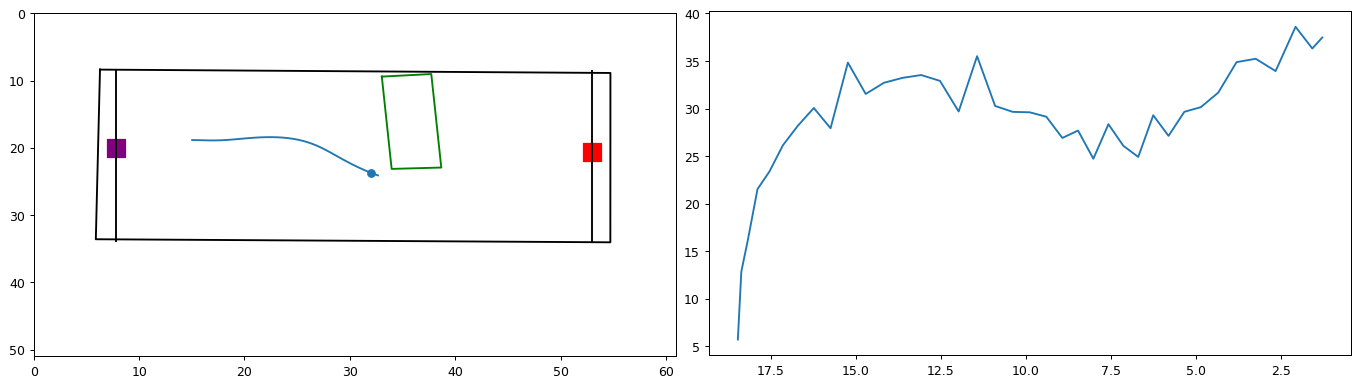

In [117]:
for ind,row in df.iterrows():
    fig = plt.figure(constrained_layout=False, figsize=(15, 8),dpi=90)

    spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
    panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])

    ax1 = fig.add_subplot(panel_1[0,0])
    ax2 = fig.add_subplot(panel_2[0,0])
    plot_arena(row,ax1)
    length = np.argwhere(row['distance_from_edge']>1).max()
    target =  np.argwhere((2> row['distance_from_edge']) ).min()
    ax1.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                                [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')
    
   





    ax1.plot(row['ts_nose_x_cm'][:length],row['ts_nose_y_cm'][:length])
    ax2.plot(row['distance_from_edge'][:length],row['ts_speed'][:length])
    ax1.scatter(row['ts_nose_x_cm'][target],row['ts_nose_y_cm'][target])
    ax2.invert_xaxis()
    print(np.nansum(row['ts_distance'][:length]))


In [ ]:
corner = row['gt_obstacleBL_y_cm']
lateral_error = 
for i in row['ts_nose_y_cm'][:length]:
    value = np.abs(i - corner) 
    if i<corner:

    

In [193]:
def lateral_error_open_corner(df):
    """get angel of nose to open corner at a hold"""
    for direction, direction_frame in df.groupby(['odd']):
        for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
            for ind,row in cluster_frame.iterrows():
                if direction == 'right':
                    if cluster == 0 or cluster == 1:
                        nose_y = row['ts_nose_y_cm'].astype(float)
                        corner_y = row['gt_obstacleBR_y_cm']
                        lateral_error = []
                        for i in nose_y:
                            if i > corner_y:  
                                err = np.abs(i -corner_y) 
                                lateral_error.append(err)
                            if i < corner_y: 
                                err = np.abs(i -corner_y) *-1
                                lateral_error.append(err)
                            
                        lateral_error = np.array(lateral_error)
                        
                        df.at[ind,'lateral_error'] = lateral_error.astype(object)
                        
                    if cluster == 2 or cluster == 3:
                        nose_x = row['ts_nose_x_cm'].astype(float)
                        nose_y = row['ts_nose_y_cm'].astype(float)
                        obstalce_edge= np.mean([row['gt_obstacleTR_x_cm'],row['gt_obstacleBR_x_cm']])
                        nose_near_edge = nose_x[np.abs(np.array(nose_x) - obstalce_edge).argmin()]
                        ind_nose_near_edge = np.argwhere(nose_x==nose_near_edge)[0][0]
                        distance_to_top = np.abs(calculate_distances(nose_x[ind_nose_near_edge],nose_y[ind_nose_near_edge],obstalce_edge,row['gt_obstacleTR_y_cm']))
                        distance_to_bottom = np.abs(calculate_distances(nose_x[ind_nose_near_edge],nose_y[ind_nose_near_edge],obstalce_edge,row['gt_obstacleBR_y_cm']))
                        lateral_error = []
                        if distance_to_top < distance_to_bottom:
                            corner_y = row['gt_obstacleTR_y_cm']
                            for i in nose_y:
                                if i > corner_y:  
                                    err = np.abs(i -corner_y) * -1 
                                    lateral_error.append(err)
                                if i < corner_y: 
                                    err = np.abs(i -corner_y)
                                    lateral_error.append(err)
                            lateral_error = np.array(lateral_error)
                            df.at[ind,'lateral_error'] = lateral_error.astype(object)
                        if distance_to_top > distance_to_bottom:
                            corner_y = row['gt_obstacleBR_y_cm']
                            for i in nose_y:
                                if i > corner_y:  
                                    err = np.abs(i -corner_y) 
                                    lateral_error.append(err)
                                if i < corner_y: 
                                    err = np.abs(i -corner_y)* -1 
                                    lateral_error.append(err)
                            lateral_error = np.array(lateral_error)
                            df.at[ind,'lateral_error'] = lateral_error.astype(object)
                            
                                
                    if cluster == 4 or cluster == 5:
                        nose_y = row['ts_nose_y_cm'].astype(float)
                        corner_y = row['gt_obstacleTR_y_cm']
                        lateral_error = []
                        for i in nose_y:
                            if i > corner_y:  
                                err = np.abs(i -corner_y) * -1 
                                lateral_error.append(err)
                            if i < corner_y: 
                                err = np.abs(i -corner_y)
                                lateral_error.append(err)
                            
                        lateral_error = np.array(lateral_error)
                        df.at[ind,'lateral_error'] = lateral_error.astype(object)
                        
                         
                if direction == 'left':
                    if cluster == 0 or cluster == 1:
                        nose_y = row['ts_nose_y_cm'].astype(float)
                        corner_y = row['gt_obstacleBL_y_cm']
                        lateral_error = []
                        for i in nose_y:
                            if i > corner_y:  
                                err = np.abs(i -corner_y) 
                                lateral_error.append(err)
                            if i < corner_y: 
                                err = np.abs(i -corner_y)*-1
                                lateral_error.append(err)
                            
                        lateral_error = np.array(lateral_error)
                        df.at[ind,'lateral_error'] = lateral_error.astype(object)
                    if cluster == 2 or cluster == 3:
                        nose_x = row['ts_nose_x_cm'].astype(float)
                        nose_y = row['ts_nose_y_cm'].astype(float)
                        obstalce_edge= np.mean([row['gt_obstacleTL_x_cm'],row['gt_obstacleBL_x_cm']])
                        nose_near_edge = nose_x[np.abs(np.array(nose_x) - obstalce_edge).argmin()]
                        ind_nose_near_edge = np.argwhere(nose_x==nose_near_edge)[0][0]
                        distance_to_top = np.abs(calculate_distances(nose_x[ind_nose_near_edge],nose_y[ind_nose_near_edge],obstalce_edge,row['gt_obstacleTL_y_cm']))
                        distance_to_bottom = np.abs(calculate_distances(nose_x[ind_nose_near_edge],nose_y[ind_nose_near_edge],obstalce_edge,row['gt_obstacleBL_y_cm']))
                        lateral_error = []
                        if distance_to_top < distance_to_bottom:
                            corner_y = row['gt_obstacleTL_y_cm']
                            for i in nose_y:
                                if i > corner_y:  
                                    err = np.abs(i -corner_y) * -1 
                                    lateral_error.append(err)
                                if i < corner_y: 
                                    err = np.abs(i -corner_y)
                                    lateral_error.append(err)
                            lateral_error = np.array(lateral_error)
                        if distance_to_top > distance_to_bottom:
                            corner_y = row['gt_obstacleBL_y_cm']
                            for i in nose_y:
                                if i > corner_y:  
                                    err = np.abs(i -corner_y) 
                                    lateral_error.append(err)
                                if i < corner_y: 
                                    err = np.abs(i -corner_y)* -1 
                                    lateral_error.append(err)
                            lateral_error = np.array(lateral_error)
                            df.at[ind,'lateral_error'] = lateral_error.astype(object)
                        
                    if cluster == 4 or cluster == 5:
                        nose_y = row['ts_nose_y_cm'].astype(float)
                        corner_y = row['gt_obstacleTL_y_cm']
                        lateral_error = []
                        for i in nose_y:
                            if i > corner_y:  
                                err = np.abs(i -corner_y) * -1 
                                lateral_error.append(err)
                            if i < corner_y: 
                                err = np.abs(i -corner_y) 
                                lateral_error.append(err)
                            
                        lateral_error = np.array(lateral_error)
                        df.at[ind,'lateral_error'] = lateral_error.astype(object)

In [194]:
lateral_error_open_corner(light_df)
lateral_error_open_corner(dark_df)

In [169]:
def symmetrize_y_axis(axes):
    y_max = np.abs(axes.get_ylim()).max()
    axes.set_ylim(ymin=-y_max, ymax=y_max)

In [ ]:
def find_consective_trials(df):
    by_animal = df.groupby(['animal'])
    for animal,animal_frame in by_animal:
        by_date = animal_frame.groupby(['date'])
        for date,date_frame in by_date:
            by_cluster = date_frame.groupby(['obstacle_cluster'])
            for cluster,cluster_frame in by_cluster:
                by_direction = cluster_frame.groupby(['odd'])
                for direction, direction_frame in by_direction:
                    by_start = direction_frame.groupby(['start'])
                    for start,start_frame in by_start:
                        for num,row in enumerate(start_frame.iterrows()):
                            if num == 0:
                                df.at[row[0],'consecutive'] = int(1) 
                            else:
                                try:
                                    if (row[1]['index']) - (df.at[row[0]-2,'index' ]) == 2:
                                        df.at[row[0],'consecutive'] = int(2) 
                                    else:
                                        df.at[row[0],'consecutive'] = int(1)
                                except KeyError:
                                    df.at[row[0],'consecutive'] = int(1)


In [ ]:
def calculate_speed(df):
    for ind, row in df.iterrows():
        if row['odd'] == 'left': 
            nose_list = row['nose_x_cm'] 
            odd_ind = np.argmax(nose_list>(df.leftportT_x_cm.unique()+5))
            temp_time = np.diff(row['trial_timestamps'][odd_ind:])
        if row['odd'] == 'right':
            nose_list = row['nose_x_cm'] 
            even_ind = np.argmax(nose_list<(df.rightportT_x_cm.unique()-5))
            temp_time = np.diff(row['trial_timestamps'][even_ind:])
        x = np.diff(row['ts_nose_x_cm']); y = np.diff(row['ts_nose_y_cm'])
        if len(x) == len(temp_time):
            xspeed = list((x/temp_time)**2)
        elif len(x) > len(temp_time):
            xspeed = list((x[:len(temp_time)]/temp_time)**2)
        elif len(x) < len(temp_time):
            xspeed = list((x/temp_time[:len(x)])**2)
        if len(y) == len(temp_time):
            yspeed = list((y/temp_time)**2)
        elif len(y) > len(temp_time):
            yspeed = list((y[:len(temp_time)]/temp_time)**2)
        elif len(y) < len(temp_time):
            yspeed = list((y/temp_time[:len(y)])**2)
        df.at[ind, 'ts_speed']  = np.sqrt(xspeed + yspeed).astype(object)
        distance = np.sqrt((x.astype(float))**2) + np.sqrt((y.astype(float))**2)
        df.at[ind, 'ts_distance'] = distance.astype(object)
        df.at[ind, 'total_ts_distance'] = np.nansum(distance).astype(object)

In [280]:
def create_long_df(df):
    cluster_0 = df[(df['obstacle_cluster']==0)&(df['start']=='top')&(df['odd']== 'right')]
    cluster_1 = df[(df['obstacle_cluster']==1)&(df['start']=='top')&(df['odd']== 'left')]
    cluster_4 = df[(df['obstacle_cluster']==4)&(df['start']=='bottom')&(df['odd']== 'right')]
    cluster_5 = df[(df['obstacle_cluster']==5)&(df['start']=='bottom')&(df['odd']== 'left')]

    long_df = pd.concat([cluster_0,cluster_1,cluster_4,cluster_5])
    return long_df


In [ ]:
import copy
def zero_out_angle(df):
    for ind, row in df.iterrows():
        angle_array = copy.deepcopy(row['angle_to_corner'])
        zero = angle_array[np.abs(angle_array - 0).argmin()]
        zero_ind = np.where(angle_array == zero)[0][0]
        angle_array[zero_ind:] = 0 
        df.at[ind,'zero_out_angle_to_corner'] = angle_array.astype(object)

In [284]:
long_df

level_0  index    first_poke   second_poke  \
15         16     17  53254.613145  53256.952128   
33         39     41  53313.989644  53316.283686   
35         41     43  53319.036377  53321.383539   
45         56     61  53363.793049  53366.119680   
47         58     63  53368.659430  53370.916556   
...       ...    ...           ...           ...   
3823        4      6  56069.835993  56073.366937   
3860       45     50  56215.313689  56218.250880   
3942      137    150  56526.595417  56529.200768   
3950      145    160  56557.064166  56559.951987   
3973        7     13  57041.859008  57044.935270   

                                       trial_timestamps  \
15    [53254.617344, 53254.63488, 53254.650662, 5325...   
33    [53314.005196, 53314.021644, 53314.037952, 533...   
35    [53319.03959, 53319.056537, 53319.073075, 5331...   
45    [53363.805094, 53363.821772, 53363.838489, 533...   
47    [53368.673536, 53368.69111, 53368.706803, 5336...   
...                                                 ...   
3823  [56069.844505, 56069.86222, 56069.877875, 5606...   
3860  [56215.328409, 56215.345523, 56215.363084, 562...   
3942  [56526.603148, 56526.61984, 56526.636633, 5652...   
3950  [56557.080934, 56557.097254, 56557.113779, 565...   
3973  [57041.874124, 57041.890342, 57041.906931, 570...   

                                        trial_vidframes  \
15    [[3046, 3047, 3048, 3049, 3050, 3051, 3052, 30...   
33    [[6608, 6609, 6610, 6611, 6612, 6613, 6614, 66...   
35    [[6910, 6911, 6912, 6913, 6914, 6915, 6916, 69...   
45    [[9595, 9596, 9597, 9598, 9599, 9600, 9601, 96...   
47    [[9887, 9888, 9889, 9890, 9891, 9892, 9893, 98...   
...                                                 ...   
3823  [1702, 1703, 1704, 1705, 1706, 1707, 1708, 170...   
3860  [10428, 10429, 10430, 10431, 10432, 10433, 104...   
3942  [29098, 29099, 29100, 29101, 29102, 29103, 291...   
3950  [30926, 30927, 30928, 30929, 30930, 30931, 309...   
3973  [3693, 3694, 3695, 3696, 3697, 3698, 3699, 370...   

                                                 nose_x  \
15    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
33    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
35    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
45    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
47    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
...                                                 ...   
3823  [88.99079132080078, 88.86106872558594, 89.6174...   
3860  [89.77569580078125, 89.28216552734375, 89.3076...   
3942  [90.00463104248047, 89.25779724121094, 89.2131...   
3950  [88.9548568725586, 88.80934143066406, 88.71128...   
3973  [91.15277862548828, 90.50054168701172, 90.8794...   

                                                 nose_y  \
15    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
33    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
35    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
45    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
47    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
...                                                 ...   
3823  [259.3994445800781, 260.13232421875, 260.66830...   
3860  [260.3761291503906, 260.0107727050781, 259.649...   
3942  [260.19158935546875, 260.1805114746094, 260.24...   
3950  [259.7483215332031, 260.32177734375, 261.15960...   
3973  [266.4710388183594, 266.0921630859375, 266.454...   

                                              leftear_x  \
15    [678.582275390625, 679.883056640625, 680.53289...   
33    [679.5838623046875, 680.9609985351562, 681.452...   
35    [680.60107421875, 682.1679077148438, 682.99499...   
45    [683.1581420898438, 684.21337890625, 684.04870...   
47    [681.9724731445312, 682.2361450195312, 682.795...   
...                                                 ...   
3823  [105.51414489746094, 104.71525573730469, 104.2...   
3860  [103.46563720703125, 102.87943267822266, 102.2...   
3942  [106.482

(874, 50) (874, 50)
(459, 50) (459, 50)
(415, 50) (415, 50)


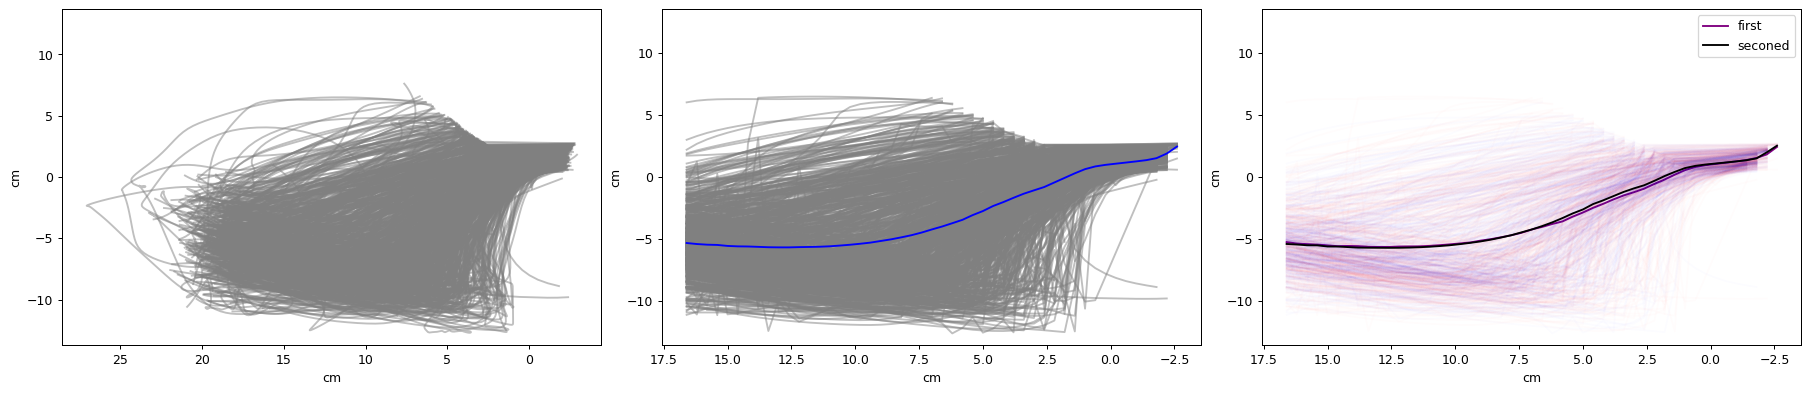

In [283]:
long_df = create_long_df(light_df)


fig = plt.figure(constrained_layout=False, figsize=(20, 8),dpi=90)
spec2 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])
panel_3 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[2])

ax1 = fig.add_subplot(panel_1[0,0])
ax2 = fig.add_subplot(panel_2[0,0])
ax3 = fig.add_subplot(panel_3[0,0])

ax1.set_ylabel('cm')
ax1.set_xlabel('cm')
ax2.set_ylabel('cm')
ax2.set_xlabel('cm')
ax3.set_ylabel('cm')
ax3.set_xlabel('cm')

for ind,row in long_df.iterrows():
    #length = int(row['len_facing_corner'])
    length = np.argwhere(row['distance_from_edge']>-3).max()
    ax1.plot(row['distance_from_edge'][:length],row['lateral_error'][:length],c = 'grey',alpha = .5)
ax1.invert_xaxis()
rows = long_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 

for i,row in enumerate(long_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>-3).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['lateral_error'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(-3, 17, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax2.plot(xnew,ynew,c = 'grey',alpha = .5)
ax2.invert_xaxis()
print(distance_array.shape,angle_array.shape)
ax2.plot(np.nanmean(distance_array,axis = 0),np.nanmean(angle_array,axis = 0),c = 'blue')
by_consecutive = long_df.groupby(['consecutive'])
for con,con_df in by_consecutive:
    if con == 1:
        first_df = con_df
    if con ==2:
        sec_df = con_df
rows = first_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 
for i,row in enumerate(first_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>-3).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['lateral_error'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(-3, 17, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax3.plot(xnew,ynew,c = 'red',alpha = .01)
ax3.plot(np.nanmean(distance_array,axis = 0),np.nanmean(angle_array,axis = 0),c = 'purple',label = 'first')
print(distance_array.shape,angle_array.shape)
rows = sec_df.shape[0]
angle_array_sec = np.empty([rows,50])
angle_array_sec[:] =np.nan 
distance_array_sec = np.empty([rows,50])
distance_array_sec[:] =np.nan 
for i,row in enumerate(sec_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>-3).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['lateral_error'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(-3, 17, .4)
    ynew = interpolater(xnew)
    distance_array_sec[i] = xnew
    angle_array_sec[i] = ynew
    ax3.plot(xnew,ynew,c = 'blue',alpha = .01)
ax3.plot(np.nanmean(distance_array_sec,axis = 0),np.nanmean(angle_array_sec,axis = 0),c = 'black',label = 'seconed')
print(distance_array_sec.shape,angle_array_sec.shape)
ax3.invert_xaxis()
ax3.legend()
symmetrize_y_axis(ax1)
symmetrize_y_axis(ax2)
symmetrize_y_axis(ax3)

(573, 50) (573, 50)
(325, 50) (325, 50)
(248, 50) (248, 50)


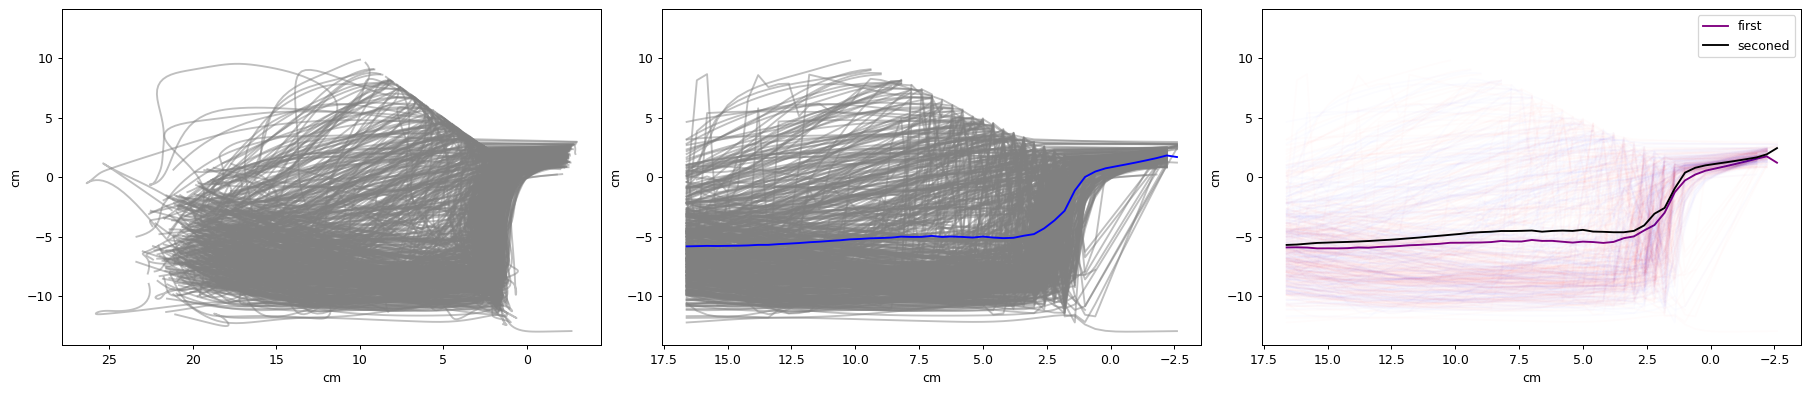

In [286]:
long_df = create_long_df(dark_df)


fig = plt.figure(constrained_layout=False, figsize=(20, 8),dpi=90)
spec2 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])
panel_3 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[2])

ax1 = fig.add_subplot(panel_1[0,0])
ax2 = fig.add_subplot(panel_2[0,0])
ax3 = fig.add_subplot(panel_3[0,0])

ax1.set_ylabel('cm')
ax1.set_xlabel('cm')
ax2.set_ylabel('cm')
ax2.set_xlabel('cm')
ax3.set_ylabel('cm')
ax3.set_xlabel('cm')

for ind,row in long_df.iterrows():
    #length = int(row['len_facing_corner'])
    length = np.argwhere(row['distance_from_edge']>-3).max()
    ax1.plot(row['distance_from_edge'][:length],row['lateral_error'][:length],c = 'grey',alpha = .5)
ax1.invert_xaxis()
rows = long_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 

for i,row in enumerate(long_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>-3).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['lateral_error'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(-3, 17, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax2.plot(xnew,ynew,c = 'grey',alpha = .5)
ax2.invert_xaxis()
print(distance_array.shape,angle_array.shape)
ax2.plot(np.nanmean(distance_array,axis = 0),np.nanmean(angle_array,axis = 0),c = 'blue')
by_consecutive = long_df.groupby(['consecutive'])
for con,con_df in by_consecutive:
    if con == 1:
        first_df = con_df
    if con ==2:
        sec_df = con_df
rows = first_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 
for i,row in enumerate(first_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>-3).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['lateral_error'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(-3, 17, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax3.plot(xnew,ynew,c = 'red',alpha = .01)
ax3.plot(np.nanmean(distance_array,axis = 0),np.nanmean(angle_array,axis = 0),c = 'purple',label = 'first')
print(distance_array.shape,angle_array.shape)
rows = sec_df.shape[0]
angle_array_sec = np.empty([rows,50])
angle_array_sec[:] =np.nan 
distance_array_sec = np.empty([rows,50])
distance_array_sec[:] =np.nan 
for i,row in enumerate(sec_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>-3).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['lateral_error'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(-3, 17, .4)
    ynew = interpolater(xnew)
    distance_array_sec[i] = xnew
    angle_array_sec[i] = ynew
    ax3.plot(xnew,ynew,c = 'blue',alpha = .01)
ax3.plot(np.nanmean(distance_array_sec,axis = 0),np.nanmean(angle_array_sec,axis = 0),c = 'black',label = 'seconed')
print(distance_array_sec.shape,angle_array_sec.shape)
ax3.invert_xaxis()
ax3.legend()
symmetrize_y_axis(ax1)
symmetrize_y_axis(ax2)
symmetrize_y_axis(ax3)

(874, 50) (874, 50)
(459, 50) (459, 50)
(415, 50) (415, 50)


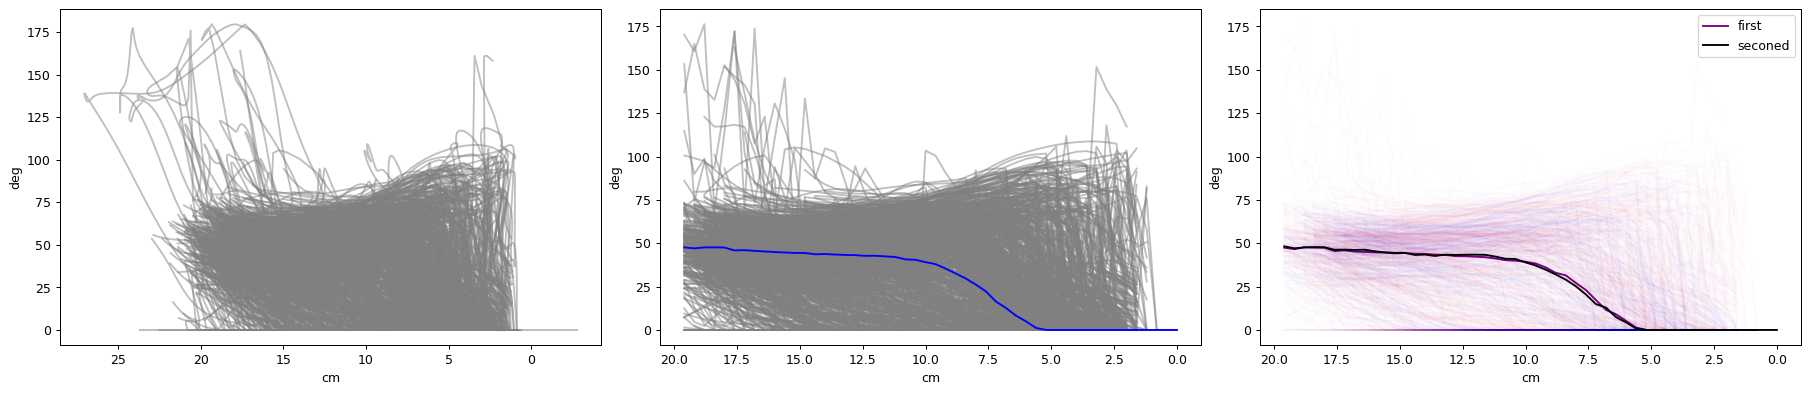

In [290]:
long_df = create_long_df(light_df)

fig = plt.figure(constrained_layout=False, figsize=(20, 8),dpi=90)
spec2 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])
panel_3 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[2])

ax1 = fig.add_subplot(panel_1[0,0])
ax2 = fig.add_subplot(panel_2[0,0])
ax3 = fig.add_subplot(panel_3[0,0])

ax1.set_ylabel('deg')
ax1.set_xlabel('cm')
ax2.set_ylabel('deg')
ax2.set_xlabel('cm')
ax3.set_ylabel('deg')
ax3.set_xlabel('cm')

for ind,row in long_df.iterrows():
    #length = int(row['len_facing_corner'])
    length = np.argwhere(row['distance_from_edge']>1).max()
    ax1.plot(row['distance_from_edge'][:length],row['zero_out_angle_to_corner'][:length],c = 'grey',alpha = .5)
ax1.invert_xaxis()
rows = long_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 

for i,row in enumerate(long_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>1).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax2.plot(xnew,ynew,c = 'grey',alpha = .5)
ax2.invert_xaxis()
print(distance_array.shape,angle_array.shape)
ax2.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'blue')
by_consecutive = long_df.groupby(['consecutive'])
for con,con_df in by_consecutive:
    if con == 1:
        first_df = con_df
    if con ==2:
        sec_df = con_df
rows = first_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 
for i,row in enumerate(first_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>1).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax3.plot(xnew,ynew,c = 'red',alpha = .01)
ax3.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'purple',label = 'first')
print(distance_array.shape,angle_array.shape)
rows = sec_df.shape[0]
angle_array_sec = np.empty([rows,50])
angle_array_sec[:] =np.nan 
distance_array_sec = np.empty([rows,50])
distance_array_sec[:] =np.nan 
for i,row in enumerate(sec_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>1).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array_sec[i] = xnew
    angle_array_sec[i] = ynew
    ax3.plot(xnew,ynew,c = 'blue',alpha = .01)
ax3.plot(np.nanmedian(distance_array_sec,axis = 0),np.nanmedian(angle_array_sec,axis = 0),c = 'black',label = 'seconed')
print(distance_array_sec.shape,angle_array_sec.shape)
ax3.invert_xaxis()
ax3.legend()

(573, 50) (573, 50)
(325, 50) (325, 50)
(248, 50) (248, 50)


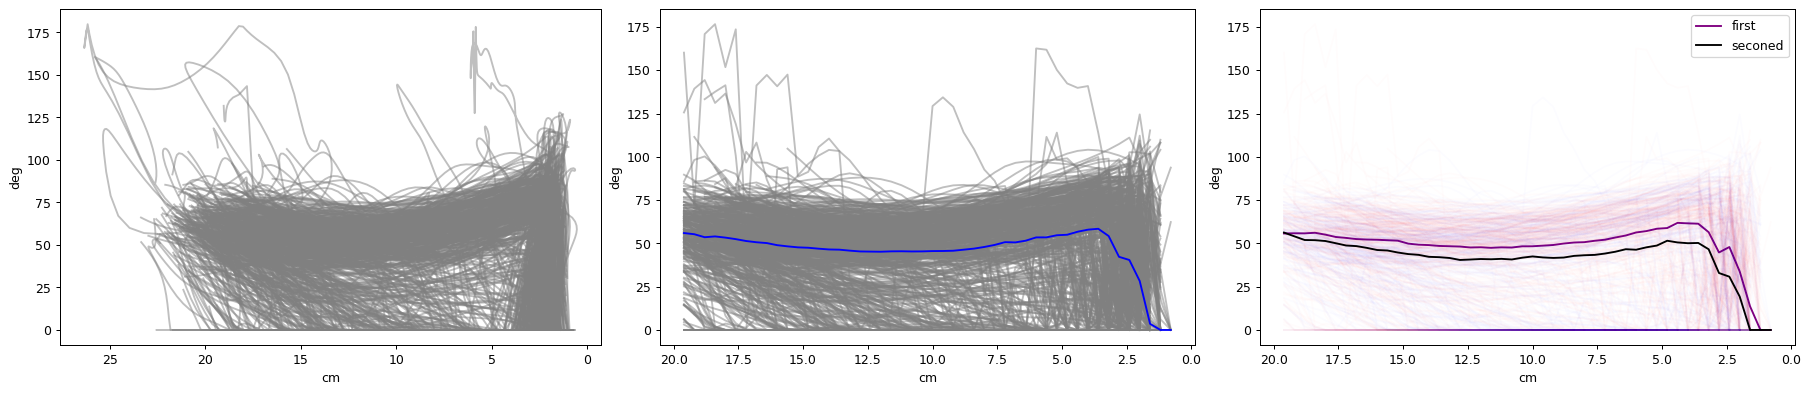

In [291]:
long_df = create_long_df(dark_df)

fig = plt.figure(constrained_layout=False, figsize=(20, 8),dpi=90)
spec2 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])
panel_3 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[2])

ax1 = fig.add_subplot(panel_1[0,0])
ax2 = fig.add_subplot(panel_2[0,0])
ax3 = fig.add_subplot(panel_3[0,0])

ax1.set_ylabel('deg')
ax1.set_xlabel('cm')
ax2.set_ylabel('deg')
ax2.set_xlabel('cm')
ax3.set_ylabel('deg')
ax3.set_xlabel('cm')

for ind,row in long_df.iterrows():
    #length = int(row['len_facing_corner'])
    length = np.argwhere(row['distance_from_edge']>1).max()
    ax1.plot(row['distance_from_edge'][:length],row['zero_out_angle_to_corner'][:length],c = 'grey',alpha = .5)
ax1.invert_xaxis()
rows = long_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 

for i,row in enumerate(long_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>1).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax2.plot(xnew,ynew,c = 'grey',alpha = .5)
ax2.invert_xaxis()
print(distance_array.shape,angle_array.shape)
ax2.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'blue')
by_consecutive = long_df.groupby(['consecutive'])
for con,con_df in by_consecutive:
    if con == 1:
        first_df = con_df
    if con ==2:
        sec_df = con_df
rows = first_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 
for i,row in enumerate(first_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>1).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax3.plot(xnew,ynew,c = 'red',alpha = .01)
ax3.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'purple',label = 'first')
print(distance_array.shape,angle_array.shape)
rows = sec_df.shape[0]
angle_array_sec = np.empty([rows,50])
angle_array_sec[:] =np.nan 
distance_array_sec = np.empty([rows,50])
distance_array_sec[:] =np.nan 
for i,row in enumerate(sec_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>1).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array_sec[i] = xnew
    angle_array_sec[i] = ynew
    ax3.plot(xnew,ynew,c = 'blue',alpha = .01)
ax3.plot(np.nanmedian(distance_array_sec,axis = 0),np.nanmedian(angle_array_sec,axis = 0),c = 'black',label = 'seconed')
print(distance_array_sec.shape,angle_array_sec.shape)
ax3.invert_xaxis()
ax3.legend()

(874, 50) (874, 50)
(459, 50) (459, 50)
(415, 50) (415, 50)


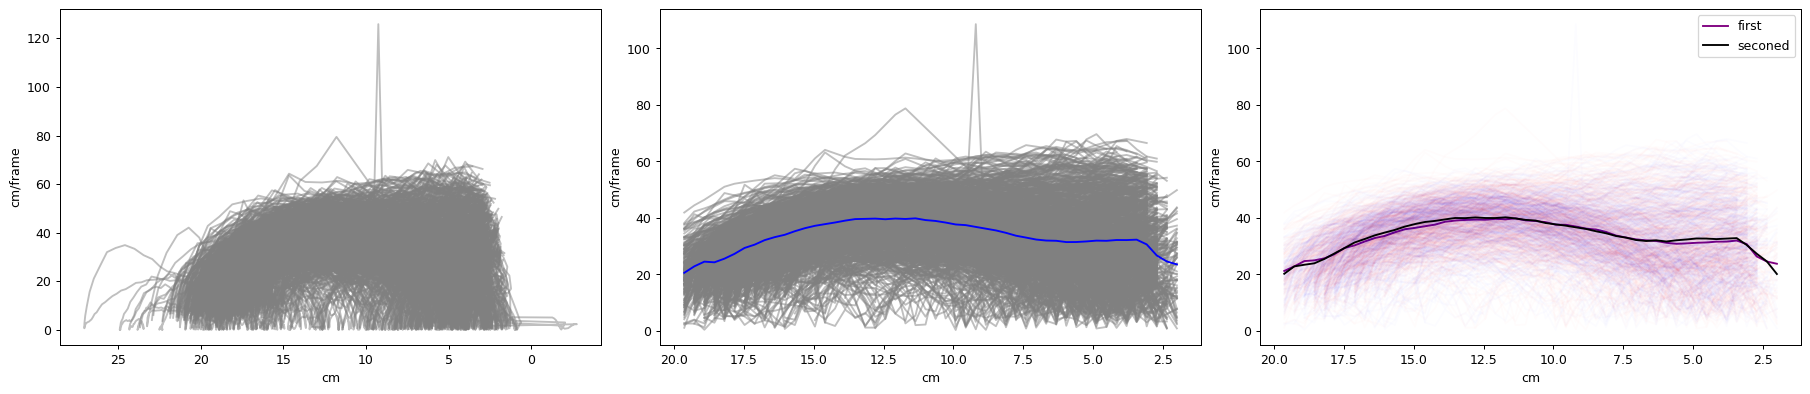

In [296]:
long_df = create_long_df(light_df)

fig = plt.figure(constrained_layout=False, figsize=(20, 8),dpi=90)
spec2 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])
panel_3 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[2])

ax1 = fig.add_subplot(panel_1[0,0])
ax2 = fig.add_subplot(panel_2[0,0])
ax3 = fig.add_subplot(panel_3[0,0])

ax1.set_ylabel('cm/frame')
ax1.set_xlabel('cm')
ax2.set_ylabel('cm/frame')
ax2.set_xlabel('cm')
ax3.set_ylabel('cm/frame')
ax3.set_xlabel('cm')

for ind,row in long_df.iterrows():
    #length = int(row['len_facing_corner'])
    length = np.argwhere(row['distance_from_edge']>2).max()
    ax1.plot(row['distance_from_edge'][:length],row['ts_speed'][:length],c = 'grey',alpha = .5)
ax1.invert_xaxis()
rows = long_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 

for i,row in enumerate(long_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>2).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['ts_speed'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(2, 20, .36)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax2.plot(xnew,ynew,c = 'grey',alpha = .5)
ax2.invert_xaxis()
print(distance_array.shape,angle_array.shape)
ax2.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'blue')
by_consecutive = long_df.groupby(['consecutive'])
for con,con_df in by_consecutive:
    if con == 1:
        first_df = con_df
    if con ==2:
        sec_df = con_df
rows = first_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 
for i,row in enumerate(first_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>2).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['ts_speed'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(2, 20, .36)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax3.plot(xnew,ynew,c = 'red',alpha = .01)
ax3.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'purple',label = 'first')
print(distance_array.shape,angle_array.shape)
rows = sec_df.shape[0]
angle_array_sec = np.empty([rows,50])
angle_array_sec[:] =np.nan 
distance_array_sec = np.empty([rows,50])
distance_array_sec[:] =np.nan 
for i,row in enumerate(sec_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>2).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['ts_speed'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(2, 20, .36)
    ynew = interpolater(xnew)
    distance_array_sec[i] = xnew
    angle_array_sec[i] = ynew
    ax3.plot(xnew,ynew,c = 'blue',alpha = .01)
ax3.plot(np.nanmedian(distance_array_sec,axis = 0),np.nanmedian(angle_array_sec,axis = 0),c = 'black',label = 'seconed')
print(distance_array_sec.shape,angle_array_sec.shape)
ax3.invert_xaxis()
ax3.legend()

(573, 50) (573, 50)
(325, 50) (325, 50)
(248, 50) (248, 50)


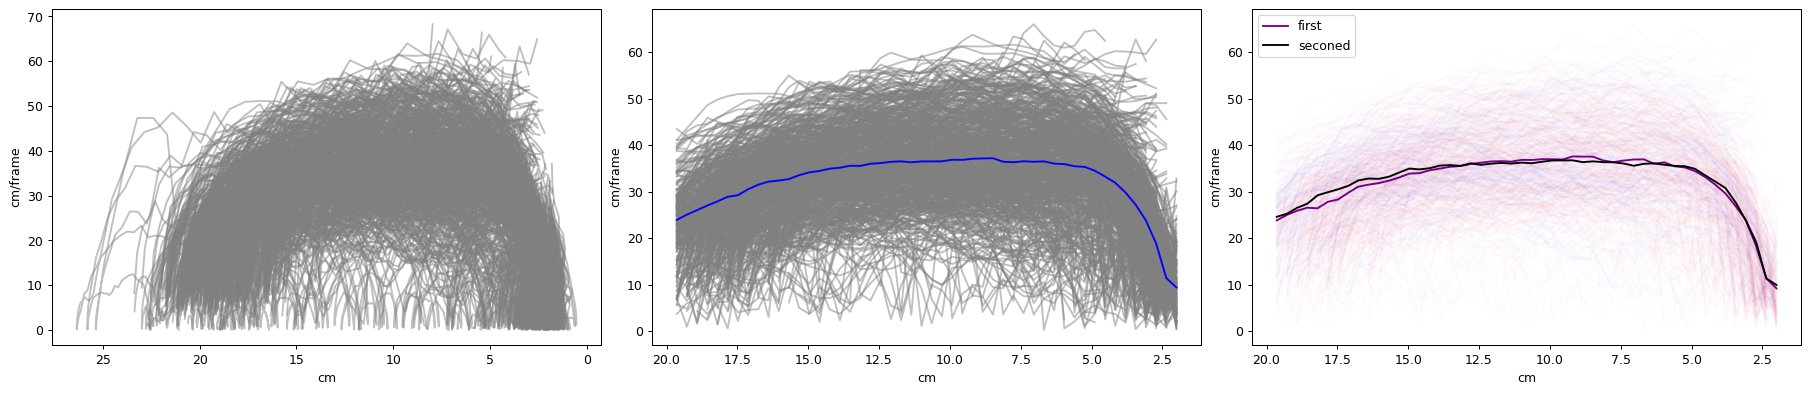

In [298]:
long_df = create_long_df(dark_df)

fig = plt.figure(constrained_layout=False, figsize=(20, 8),dpi=90)
spec2 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])
panel_3 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[2])

ax1 = fig.add_subplot(panel_1[0,0])
ax2 = fig.add_subplot(panel_2[0,0])
ax3 = fig.add_subplot(panel_3[0,0])

ax1.set_ylabel('cm/frame')
ax1.set_xlabel('cm')
ax2.set_ylabel('cm/frame')
ax2.set_xlabel('cm')
ax3.set_ylabel('cm/frame')
ax3.set_xlabel('cm')

for ind,row in long_df.iterrows():
    #length = int(row['len_facing_corner'])
    length = np.argwhere(row['distance_from_edge']>2).max()
    ax1.plot(row['distance_from_edge'][:length],row['ts_speed'][:length],c = 'grey',alpha = .5)
ax1.invert_xaxis()
rows = long_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 

for i,row in enumerate(long_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>2).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['ts_speed'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(2, 20, .36)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax2.plot(xnew,ynew,c = 'grey',alpha = .5)
ax2.invert_xaxis()
print(distance_array.shape,angle_array.shape)
ax2.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'blue')
by_consecutive = long_df.groupby(['consecutive'])
for con,con_df in by_consecutive:
    if con == 1:
        first_df = con_df
    if con ==2:
        sec_df = con_df
rows = first_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 
for i,row in enumerate(first_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>2).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['ts_speed'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(2, 20, .36)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax3.plot(xnew,ynew,c = 'red',alpha = .01)
ax3.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'purple',label = 'first')
print(distance_array.shape,angle_array.shape)
rows = sec_df.shape[0]
angle_array_sec = np.empty([rows,50])
angle_array_sec[:] =np.nan 
distance_array_sec = np.empty([rows,50])
distance_array_sec[:] =np.nan 
for i,row in enumerate(sec_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>2).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['ts_speed'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(2, 20, .36)
    ynew = interpolater(xnew)
    distance_array_sec[i] = xnew
    angle_array_sec[i] = ynew
    ax3.plot(xnew,ynew,c = 'blue',alpha = .01)
ax3.plot(np.nanmedian(distance_array_sec,axis = 0),np.nanmedian(angle_array_sec,axis = 0),c = 'black',label = 'seconed')
print(distance_array_sec.shape,angle_array_sec.shape)
ax3.invert_xaxis()
ax3.legend()

In [300]:
long_df = create_long_df(light_df)
for ind,row in long_df.iterrows():
    target =  np.argwhere((-1< row['distance_from_edge']) ).max()
    tor,lin= compute_tortuosity(row['ts_nose_x_cm'][:target+1],row['ts_nose_y_cm'][:target+1])
    long_df.at[ind,'tortuosity']=tor
    long_df.at[ind,'linearity']=lin

In [301]:
dark_long_df = create_long_df(dark_df)
for ind,row in dark_long_df.iterrows():
    target =  np.argwhere((-1< row['distance_from_edge']) ).max()
    tor,lin= compute_tortuosity(row['ts_nose_x_cm'][:target+1],row['ts_nose_y_cm'][:target+1])
    dark_long_df.at[ind,'tortuosity']=tor
    dark_long_df.at[ind,'linearity']=lin

In [303]:
print(long_df.tortuosity.mean(),dark_long_df.tortuosity.mean())
print(long_df.linearity.mean(),dark_long_df.linearity.mean())

1.2076560438626767 1.3104881499747316
0.8487213716878516 0.7863701654221893


In [305]:
long_df.tortuosity

15      1.487454
33      1.325652
35      1.276777
45      1.020855
47      1.003180
          ...   
3823    1.152628
3860    1.007757
3942    1.004716
3950    1.011172
3973    1.408652
Name: tortuosity, Length: 874, dtype: float64

In [321]:
dark.rename(columns = {'tortuosity':'light'})

light
0    1.264674
1    1.332999
2    1.097872
3    1.529001
4    1.257388
..        ...
568  1.422382
569  1.510221
570  1.597962
571  1.388918
572  1.078334

[573 rows x 1 columns]

In [339]:
light['light']

0      1.487454
1      1.325652
2      1.276777
3      1.020855
4      1.003180
         ...   
869    1.152628
870    1.007757
871    1.004716
872    1.011172
873    1.408652
Name: light, Length: 874, dtype: float64

In [340]:
reject_outliers(light['light'],m=2)

1      1.325652
2      1.276777
3      1.020855
4      1.003180
5      1.282325
         ...   
868    1.040884
869    1.152628
870    1.007757
871    1.004716
872    1.011172
Name: light, Length: 744, dtype: float64

In [ ]:
eject_outliers(dark_df['time'][(dark_df['obstacle_cluster']==cluster)  & (dark_df['odd']== direction) & (dark_df['start']== start)],m=1)

In [343]:
light = pd.DataFrame(long_df.tortuosity.reset_index(level=0,drop = True))
light = light.rename(columns = {'tortuosity':'light'})
light = reject_outliers(light['light'],m=2)
dark = pd.DataFrame(dark_long_df.tortuosity.reset_index(level=0,drop = True))
dark = dark.rename(columns = {'tortuosity':'dark'})
dark = reject_outliers(dark['dark'],m=2)
tor_df = pd.concat([light, dark], axis=1)


In [331]:
tor_df.melt()

variable     value
0       light  1.487454
1       light  1.325652
2       light  1.276777
3       light  1.020855
4       light  1.003180
...       ...       ...
1743     dark       NaN
1744     dark       NaN
1745     dark       NaN
1746     dark       NaN
1747     dark       NaN

[1748 rows x 2 columns]

NameError: name 'sns' is not defined

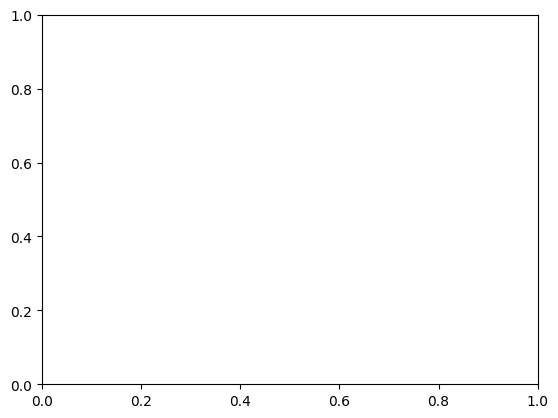

In [5]:
fig,ax = plt.subplots()
sns.violinplot(x="variable", y="value", data=tor_df.melt(),ax = ax)
ax.set_ylabel('spatial_')

In [328]:
tor_df.columns

Index(['light', 'dark'], dtype='object')

In [329]:
sns.swarmplot(data=tor_df, x=tor_df.columns)

ValueError: Length of Index vectors must match length of `data` when both are used, but `data` has length 874 and the vector passed to `x` has length 2.

(array([1.70537941, 1.65347656, 0.68956646, 0.13346448, 0.05190285,
        0.        , 0.00741469, 0.        , 0.        , 0.00741469]),
 array([1.0011957 , 1.23656629, 1.47193689, 1.70730748, 1.94267807,
        2.17804866, 2.41341925, 2.64878985, 2.88416044, 3.11953103,
        3.35490162]),
 <BarContainer object of 10 artists>)

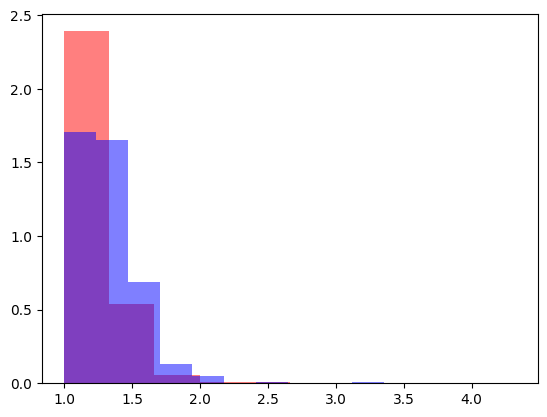

In [306]:
plt.hist(long_df.tortuosity,density = True, color = 'red',alpha = .5)
plt.hist(dark_long_df.tortuosity,density = True, color = 'blue',alpha = .5)

In [ ]:
light_tor = 

In [6]:
ts_postition_through_threshold(light_df,10)

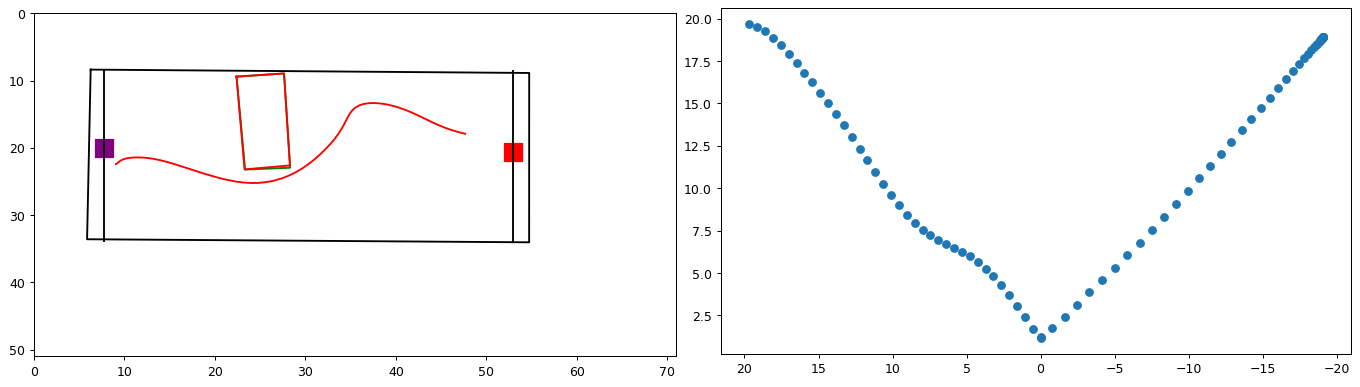

In [136]:
trial = light_df.iloc[28]
fig = plt.figure(constrained_layout=False, figsize=(15, 8),dpi=90)

spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])

ax1 = fig.add_subplot(panel_1[0,0])
ax2 = fig.add_subplot(panel_2[0,0])
plot_arena(trial,ax1)
ax1.plot([trial['gt_obstacleTL_x_cm'], trial['gt_obstacleTR_x_cm'], trial['gt_obstacleBR_x_cm'], trial['gt_obstacleBL_x_cm'],trial['gt_obstacleTL_x_cm']],
                            [trial['gt_obstacleTL_y_cm'], trial['gt_obstacleTR_y_cm'], trial['gt_obstacleBR_y_cm'], trial['gt_obstacleBL_y_cm'],trial['gt_obstacleTL_y_cm']],color='green')
ax1.plot([np.nanmean(trial['obstacleTL_x_cm']), np.nanmean(trial['obstacleTR_x_cm']), np.nanmean(trial['obstacleBR_x_cm']), np.nanmean(trial['obstacleBL_x_cm']),np.nanmean(trial['obstacleTL_x_cm'])],
                            [np.nanmean(trial['obstacleTL_y_cm']), np.nanmean(trial['obstacleTR_y_cm']), np.nanmean(trial['obstacleBR_y_cm']), np.nanmean(trial['obstacleBL_y_cm']),np.nanmean(trial['obstacleTL_y_cm'])],color='red')



ax1.plot(trial['ts_nose_x_cm'],trial['ts_nose_y_cm'],color = 'red')



obstalce_edge = np.mean([trial['gt_obstacleTR_x_cm'],trial['gt_obstacleBR_x_cm']])
trial_length = trial['ts_nose_x_cm'].size
ind_closest_to_edge = np.where(trial['ts_nose_x_cm'] == trial['ts_nose_x_cm'].flat[np.abs(trial['ts_nose_x_cm'] - obstalce_edge).argmin()])[0][0]
past_obstalce = trial['ts_nose_x_cm'][ind_closest_to_edge:] - trial['ts_nose_x_cm'][ind_closest_to_edge:][0]
before_obstalce = np.linspace(trial.distance_from_edge[0],0,num =ind_closest_to_edge)
distance_centered_obstalce = np.concatenate([before_obstalce,past_obstalce]).astype(float)
#distance_centered_obstalce = np.flip(distance_centered_obstalce)


    


ax2.scatter(distance_centered_obstalce,trial.distance_from_edge)
ax2.invert_xaxis()
#ax2.plot(trial.distance_from_edge)
#ax2.plot(trial.ts_speed[trial.thresh_ind_through_20.tolist()],color = 'green')


In [1856]:
light_df = light_df.drop(columns = ['ts_distance'])
dark_df = dark_df.drop(columns = ['ts_distance'])

In [1857]:
def calculate_speed(df):
    for ind, row in df.iterrows():
        x_positions, y_positions, fps = row['ts_nose_x_cm'], row['ts_nose_y_cm'], 60
        # Calculate the change in positions between frames
        delta_x = np.diff(x_positions.astype(float))
        delta_y = np.diff(y_positions.astype(float))

        # Calculate the Euclidean distance between consecutive positions
        distance = np.sqrt(delta_x**2 + delta_y**2)

        # Calculate the time interval between frames
        time_interval = 1 / fps

        # Calculate the speed in cm/s
        speed = distance / time_interval
        speed = speed.astype(float)
        distance = distance.astype(float)

        df.at[ind, 'ts_speed'] = speed.astype(object)
        df.at[ind, 'ts_distance'] = sum(distance).astype(object)
        

In [11]:
def calculate_speed(df):
    for ind, row in df.iterrows():
        if row['odd'] == 'left': 
            nose_list = row['nose_x_cm'] 
            odd_ind = np.argmax(nose_list>(df.leftportT_x_cm.unique()+5))
            temp_time = np.diff(row['trial_timestamps'][odd_ind:])
        if row['odd'] == 'right':
            nose_list = row['nose_x_cm'] 
            even_ind = np.argmax(nose_list<(df.rightportT_x_cm.unique()-5))
            temp_time = np.diff(row['trial_timestamps'][even_ind:])
        x = np.diff(row['ts_nose_x_cm']); y = np.diff(row['ts_nose_y_cm'])
        if len(x) == len(temp_time):
            xspeed = list((x/temp_time)**2)
        elif len(x) > len(temp_time):
            xspeed = list((x[:len(temp_time)]/temp_time)**2)
        elif len(x) < len(temp_time):
            xspeed = list((x/temp_time[:len(x)])**2)
        if len(y) == len(temp_time):
            yspeed = list((y/temp_time)**2)
        elif len(y) > len(temp_time):
            yspeed = list((y[:len(temp_time)]/temp_time)**2)
        elif len(y) < len(temp_time):
            yspeed = list((y/temp_time[:len(y)])**2)
        df.at[ind, 'ts_speed']  = np.sqrt(xspeed + yspeed).astype(object)
        distance = np.sqrt((x.astype(float))**2) + np.sqrt((y.astype(float))**2)
        df.at[ind, 'ts_distance'] = distance.astype(object)
        df.at[ind, 'total_ts_distance'] = np.nansum(distance).astype(object)

In [12]:
calculate_speed(dark_df)
calculate_speed(light_df)

In [761]:
def len_at_facing_corner(df):
    for ind,row in  df.iterrows():
        min = np.argmin(row.angle_to_corner[np.where(row.angle_to_corner>0)])
        len_facing = len(row.angle_to_corner[:min])
        df.at[ind,'len_facing_corner'] = len_facing
        


In [ ]:
def compute_tortuosity(x_coordinates, y_coordinates):
    if len(x_coordinates) != len(y_coordinates):
        raise ValueError("Input arrays must have the same length.")

    # Calculate the path length
    path_length = 0
    for i in range(1, len(x_coordinates)):
        dx = x_coordinates[i] - x_coordinates[i-1]
        dy = y_coordinates[i] - y_coordinates[i-1]
        path_length += np.sqrt(dx**2 + dy**2)

    # Calculate the Euclidean distance
    start_point = (x_coordinates[0], y_coordinates[0])
    end_point = (x_coordinates[-1], y_coordinates[-1])
    euclidean_distance = np.sqrt((end_point[0] - start_point[0])**2 + (end_point[1] - start_point[1])**2)

    # Compute tortuosity as the ratio of path length to Euclidean distance
    tortuosity = path_length / euclidean_distance
    linearity = 1/tortuosity 

    return tortuosity,linearity

In [762]:
len_at_facing_corner(dark_df)
len_at_facing_corner(light_df)

In [340]:
df.len_facing_corner

0        8.0
36      30.0
37      24.0
48      20.0
84      31.0
        ... 
4014    24.0
4029    18.0
4050    17.0
4052    24.0
4059    12.0
Name: len_facing_corner, Length: 224, dtype: float64

In [337]:
def reject_outliers(data, m = 2.5):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]

45.0
0.5262057989828612 7.876979533124121


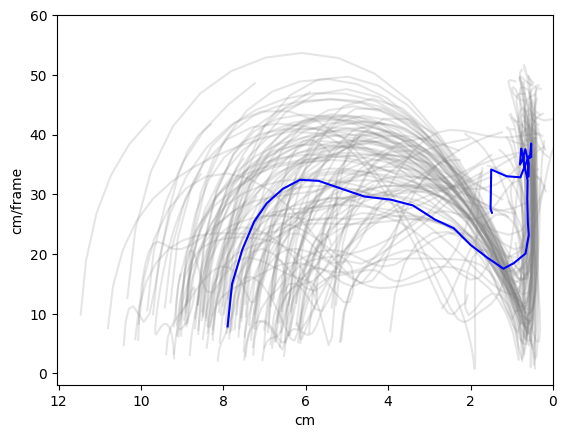

In [735]:
cluster = 4 
start = 'bottom'
direction = 'left'
cut_off =  reject_outliers(dark_df['len_facing_corner'][(dark_df['obstacle_cluster']==cluster)  & (dark_df['odd']== direction) & (dark_df['start']== start)]).max()
print(cut_off)
df = dark_df[(dark_df['obstacle_cluster']==cluster)&(dark_df['start']==start)&(dark_df['len_facing_corner']<=cut_off)& (dark_df['odd']== direction)]
max_len = int(df.len_facing_corner.max())
#max_len = int(df.len_facing_corner.to_numpy().flat[np.abs(df.len_facing_corner - max_len).argmin()])
rows = df.shape[0]
angle_array = np.empty([rows,max_len])
angle_array[:] =np.nan 
distance_array = np.empty([rows,max_len])
distance_array[:] =np.nan 
for ind,row in enumerate(df.iterrows()):
    length = int(row[1]['len_facing_corner'])
    #angle_array[ind][max_len - length:] = row[1]['ts_speed'][:length]
    #distance_array[ind][max_len - length:]  = row[1]['distance_from_edge'][:length]
    angle_array[ind][:length] = row[1]['ts_speed'][:length]
    distance_array[ind][:length]  = row[1]['distance_from_edge'][:length]
    #neg_list = np.argwhere(distance_array<0)
    #for i,ind in enumerate(neg_list):
        #distance_array[neg_list[i][0],neg_list[i][1]] = np.nan


fig,ax = plt.subplots()
for i in list(range(angle_array.shape[0])):
    ax.plot(distance_array[i] ,angle_array[i],c = 'gray',alpha = .2)
ax.invert_xaxis()
ax.set_xlim(right=0.)
ax.set_ylim(top=60.)
ax.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'blue')
ax.set_ylabel('cm/frame')
ax.set_xlabel('cm')
print(np.nanmedian(distance_array,axis = 0).min(),np.nanmedian(angle_array,axis = 0).min())

43.0
1.252523603428596 6.779862678311294


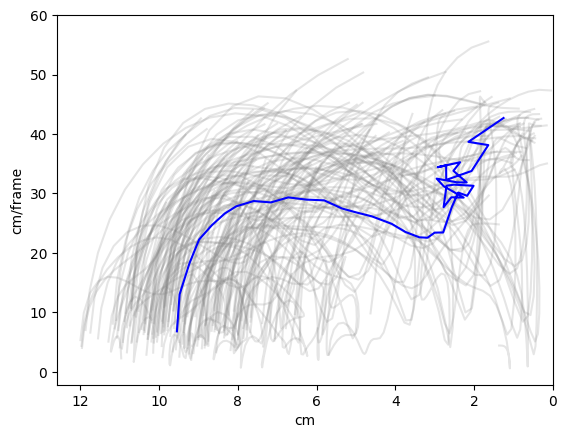

In [736]:

cut_off =  reject_outliers(light_df['len_facing_corner'][(light_df['obstacle_cluster']==cluster)  & (light_df['odd']== direction) & (light_df['start']== start)]).max()
print(cut_off)
df = light_df[(light_df['obstacle_cluster']==cluster)&(light_df['start']==start)&(light_df['len_facing_corner']<=cut_off)& (light_df['odd']== direction)]
max_len = int(df.len_facing_corner.max())
#max_len = int(df.len_facing_corner.to_numpy().flat[np.abs(df.len_facing_corner - max_len).argmin()])
rows = df.shape[0]
angle_array = np.empty([rows,max_len])
angle_array[:] =np.nan 
distance_array = np.empty([rows,max_len])
distance_array[:] =np.nan 
for ind,row in enumerate(df.iterrows()):
    length = int(row[1]['len_facing_corner'])
    angle_array[ind][:length] = row[1]['ts_speed'][:length]
    distance_array[ind][:length]  = row[1]['distance_from_edge'][:length]
    #neg_list = np.argwhere(distance_array<0)
    #for i,ind in enumerate(neg_list):
        #distance_array[neg_list[i][0],neg_list[i][1]] = np.nan


fig,ax = plt.subplots()
for i in list(range(angle_array.shape[0])):
    ax.plot(distance_array[i] ,angle_array[i],c = 'gray',alpha = .2)
ax.invert_xaxis()
ax.set_xlim(right=0.)
ax.set_ylim(top=60.)
ax.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'blue')
ax.set_ylabel('cm/frame')
ax.set_xlabel('cm')
print(np.nanmedian(distance_array,axis = 0).min(),np.nanmedian(angle_array,axis = 0).min())

(array([41., 63., 42., 16.,  6.,  3.,  1.,  4.,  1.,  1.]),
 array([  4. ,  16.1,  28.2,  40.3,  52.4,  64.5,  76.6,  88.7, 100.8,
        112.9, 125. ]),
 <BarContainer object of 10 artists>)

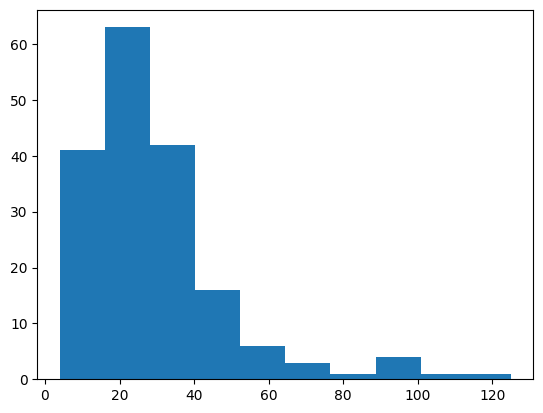

In [749]:
plt.hist(light_df['len_facing_corner'][(light_df['obstacle_cluster']==cluster)  & (light_df['odd']== direction) & (light_df['start']== start)])

(array([ 2., 17., 37., 24., 34., 26., 22., 17., 12.,  7.]),
 array([ 0. ,  4.3,  8.6, 12.9, 17.2, 21.5, 25.8, 30.1, 34.4, 38.7, 43. ]),
 <BarContainer object of 10 artists>)

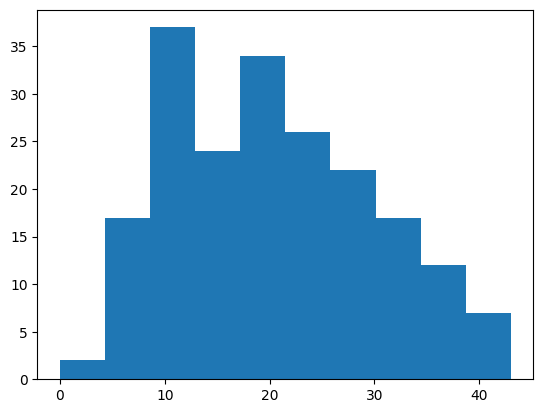

In [765]:
plt.hist(reject_outliers(light_df['len_facing_corner'][(light_df['obstacle_cluster']==cluster)  & (light_df['odd']== direction) & (light_df['start']== start)],m=2.5))

50.0
6.242187034844953 1.7244457073469013


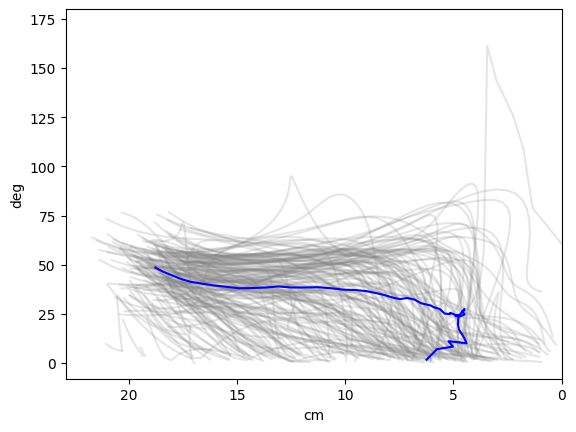

In [828]:
cluster = 1 
start = 'top'
direction = 'left'
cut_off =  reject_outliers(light_df['len_facing_corner'][(light_df['obstacle_cluster']==cluster)  & (light_df['odd']== direction) & (light_df['start']== start)],m=2.5).max()
print(cut_off)
df = light_df[(light_df['obstacle_cluster']==cluster)&(light_df['start']==start)&(light_df['len_facing_corner']<=cut_off)& (light_df['odd']== direction)]
max_len = int(df.len_facing_corner.max())
#max_len = int(df.len_facing_corner.to_numpy().flat[np.abs(df.len_facing_corner - max_len).argmin()])
rows = df.shape[0]
angle_array = np.empty([rows,max_len])
angle_array[:] =np.nan 
distance_array = np.empty([rows,max_len])
distance_array[:] =np.nan 
for ind,row in enumerate(df.iterrows()):
    length = int(row[1]['len_facing_corner'])
    angle_array[ind][:length] = row[1]['angle_to_corner'][:length]
    distance_array[ind][:length]  = row[1]['distance_from_edge'][:length]
    #neg_list = np.argwhere(distance_array<0)
    #for i,ind in enumerate(neg_list):
        #distance_array[neg_list[i][0],neg_list[i][1]] = np.nan


fig,ax = plt.subplots()
for i in list(range(angle_array.shape[0])):
    ax.plot(distance_array[i] ,angle_array[i],c = 'gray',alpha = .2)
ax.invert_xaxis()
ax.set_xlim(right=0.)
ax.set_ylim(top=180.)
ax.plot(np.nanmean(distance_array,axis = 0),np.nanmean(angle_array,axis = 0),c = 'blue')
ax.set_ylabel('deg')
ax.set_xlabel('cm')
print(np.nanmean(distance_array,axis = 0)[-1],np.nanmean(angle_array,axis = 0)[-1])

In [ ]:
ts_postition_through_threshold(light_df,)

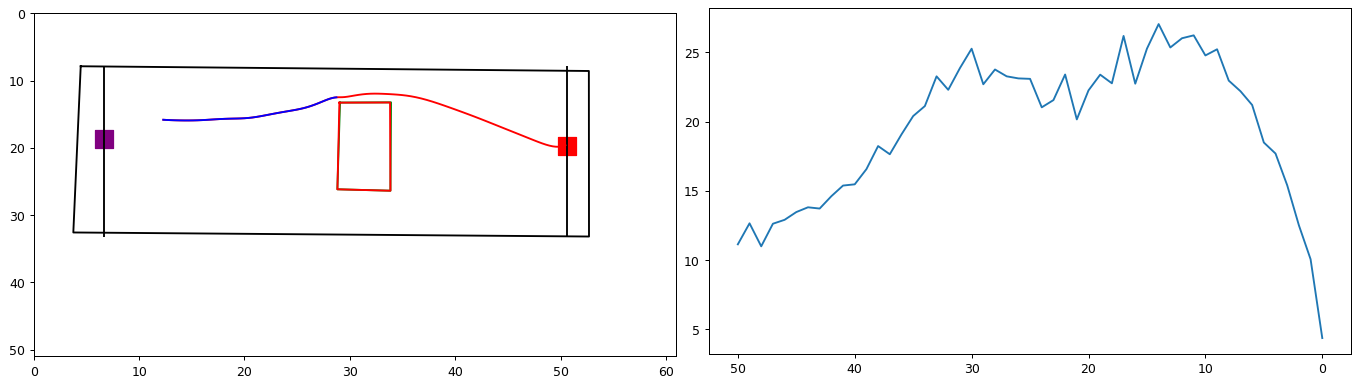

In [1960]:
df = dark_df[(dark_df['obstacle_cluster']==cluster)&(dark_df['start']==start)&(dark_df['len_facing_corner']<=cut_off)& (dark_df['odd']== direction)]
test = df.sample(1)
trial = test.iloc[0]
fig = plt.figure(constrained_layout=False, figsize=(15, 8),dpi=90)

spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])

ax1 = fig.add_subplot(panel_1[0,0])
ax2 = fig.add_subplot(panel_2[0,0])
plot_arena(trial,ax1)
ax1.plot([trial['gt_obstacleTL_x_cm'], trial['gt_obstacleTR_x_cm'], trial['gt_obstacleBR_x_cm'], trial['gt_obstacleBL_x_cm'],trial['gt_obstacleTL_x_cm']],
                            [trial['gt_obstacleTL_y_cm'], trial['gt_obstacleTR_y_cm'], trial['gt_obstacleBR_y_cm'], trial['gt_obstacleBL_y_cm'],trial['gt_obstacleTL_y_cm']],color='green')
ax1.plot([np.nanmean(trial['obstacleTL_x_cm']), np.nanmean(trial['obstacleTR_x_cm']), np.nanmean(trial['obstacleBR_x_cm']), np.nanmean(trial['obstacleBL_x_cm']),np.nanmean(trial['obstacleTL_x_cm'])],
                            [np.nanmean(trial['obstacleTL_y_cm']), np.nanmean(trial['obstacleTR_y_cm']), np.nanmean(trial['obstacleBR_y_cm']), np.nanmean(trial['obstacleBL_y_cm']),np.nanmean(trial['obstacleTL_y_cm'])],color='red')

length = np.argwhere(trial['distance_from_edge']>0).max()
#length = int(trial['len_facing_corner'])

ax1.plot(trial['ts_nose_x_cm'],trial['ts_nose_y_cm'],color = 'red')

ax1.plot(trial['ts_nose_x_cm'][:length],trial['ts_nose_y_cm'][:length],color = 'blue')



obstalce_edge = np.mean([trial['gt_obstacleTR_x_cm'],trial['gt_obstacleBR_x_cm']])
trial_length = trial['ts_nose_x_cm'].size
ind_closest_to_edge = np.where(trial['ts_nose_x_cm'] == trial['ts_nose_x_cm'].flat[np.abs(trial['ts_nose_x_cm'] - obstalce_edge).argmin()])[0][0]
past_obstalce = trial['ts_nose_x_cm'][ind_closest_to_edge:] - trial['ts_nose_x_cm'][ind_closest_to_edge:][0]
before_obstalce = np.linspace(trial.distance_from_edge[0],0,num =ind_closest_to_edge)
distance_centered_obstalce = np.concatenate([before_obstalce,past_obstalce]).astype(float)
#distance_centered_obstalce = np.flip(distance_centered_obstalce)


    
ax2.plot(trial.ts_speed[:length])

#ax2.scatter(distance_centered_obstalce,trial.distance_from_edge)
ax2.invert_xaxis()

In [1214]:
by_animal = test.groupby(['animal'])
for animal,animal_frame in by_animal:
    by_date = animal_frame.groupby(['date'])
    for date,date_frame in by_date:
        by_cluster = date_frame.groupby(['obstacle_cluster'])
        for cluster,cluster_frame in by_cluster:
            by_direction = cluster_frame.groupby(['odd'])
            for direction, direction_frame in by_direction:
                by_start = direction_frame.groupby(['start'])
                for start,start_frame in by_start:
                    for num,row in enumerate(start_frame.iterrows()):
                        if num == 0:
                            test.at[row[0],'consecutive'] = 1 
                        else:
                            try:
                                if (row[1]['index']) - (test.at[row[0]-2,'index' ]) == 2:
                                    test.at[row[0],'consecutive'] = 2 
                                else:
                                    test.at[row[0],'consecutive'] = 1
                            except KeyError:
                                test.at[row[0],'consecutive'] = 1


                        


                            

In [17]:
def find_consective_trials(df):
    by_animal = df.groupby(['animal'])
    for animal,animal_frame in by_animal:
        by_date = animal_frame.groupby(['date'])
        for date,date_frame in by_date:
            by_cluster = date_frame.groupby(['obstacle_cluster'])
            for cluster,cluster_frame in by_cluster:
                by_direction = cluster_frame.groupby(['odd'])
                for direction, direction_frame in by_direction:
                    by_start = direction_frame.groupby(['start'])
                    for start,start_frame in by_start:
                        for num,row in enumerate(start_frame.iterrows()):
                            if num == 0:
                                df.at[row[0],'consecutive'] = int(1) 
                            else:
                                try:
                                    if (row[1]['index']) - (df.at[row[0]-2,'index' ]) == 2:
                                        df.at[row[0],'consecutive'] = int(2) 
                                    else:
                                        df.at[row[0],'consecutive'] = int(1)
                                except KeyError:
                                    df.at[row[0],'consecutive'] = int(1)

        


In [18]:
find_consective_trials(light_df)
find_consective_trials(dark_df)

In [ ]:
def create_consective_df(df):
    con_df = pd.DataFrame()
    df = self.df.reset_index(drop=True)
    for animal,animal_frame in df.groupby('animal'):
        for date, date_frame in animal_frame.groupby('date'):
            repeats_list = find_consecutive_repeats(date_frame['obstacle_cluster'])
            for i in range(len(repeats_list)):
                con_df = con_df.append(date_frame.loc[repeats_list[i][0]:repeats_list[i][1]])
    self.con_df = con_df
        

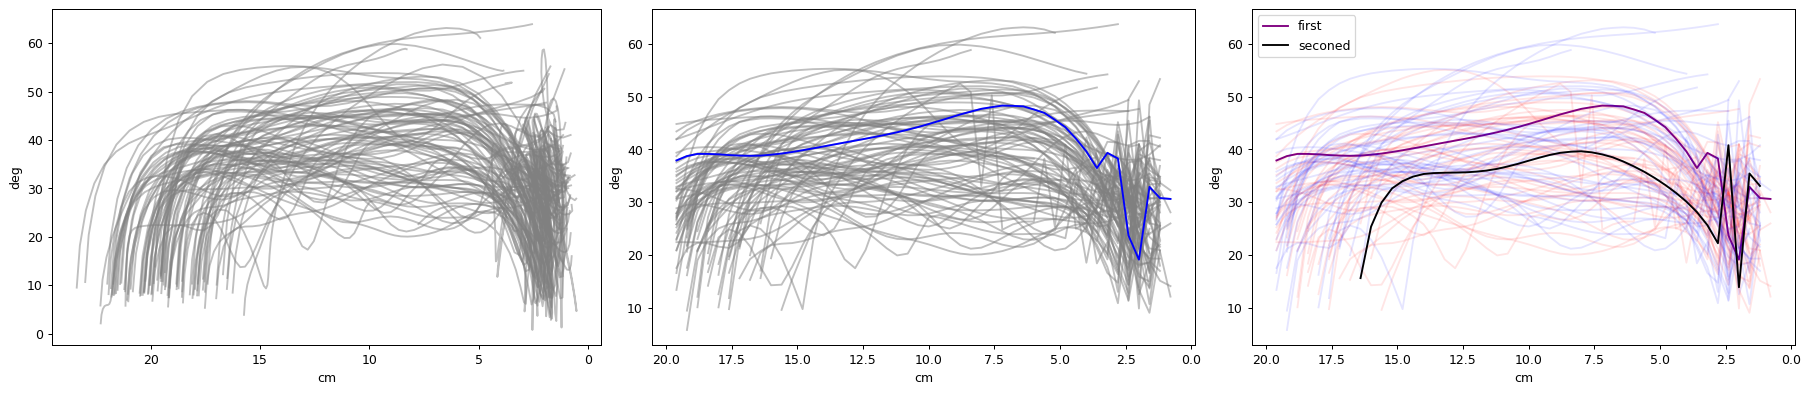

In [1324]:

cut_off =  reject_outliers(dark_df['time'][(dark_df['obstacle_cluster']==cluster)  & (dark_df['odd']== direction) & (dark_df['start']== start)],m=1).max()

df = dark_df[(dark_df['obstacle_cluster']==cluster)&(dark_df['start']==start)&(dark_df['time']<=cut_off)& (dark_df['odd']== direction)]

fig = plt.figure(constrained_layout=False, figsize=(20, 8),dpi=90)
spec2 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])
panel_3 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[2])

ax1 = fig.add_subplot(panel_1[0,0])
ax2 = fig.add_subplot(panel_2[0,0])
ax3 = fig.add_subplot(panel_3[0,0])

ax1.set_ylabel('deg')
ax1.set_xlabel('cm')
ax2.set_ylabel('deg')
ax2.set_xlabel('cm')
ax3.set_ylabel('deg')
ax3.set_xlabel('cm')

for ind,row in df.iterrows():
    #length = int(row['len_facing_corner'])
    length = np.argwhere(row['distance_from_edge']>0).max()
    ax1.plot(row['distance_from_edge'][:length],row['ts_speed'][:length],c = 'grey',alpha = .5)
ax1.invert_xaxis()

for i,row in enumerate(df.iterrows()):
    rows = df.shape[0]
    angle_array = np.empty([rows,50])
    angle_array[:] =np.nan 
    distance_array = np.empty([rows,50])
    distance_array[:] =np.nan 
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['ts_speed'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax2.plot(xnew,ynew,c = 'grey',alpha = .5)
ax2.invert_xaxis()
ax2.plot(np.nanmean(distance_array,axis = 0),np.nanmean(angle_array,axis = 0),c = 'blue')
by_consecutive = df.groupby(['consecutive'])
for con,con_df in by_consecutive:
    if con == 1:
        first_df = con_df
    if con ==2:
        sec_df = con_df
for i,row in enumerate(first_df.iterrows()):
    rows = first_df.shape[0]
    angle_array = np.empty([rows,50])
    angle_array[:] =np.nan 
    distance_array = np.empty([rows,50])
    distance_array[:] =np.nan 
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['ts_speed'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax3.plot(xnew,ynew,c = 'red',alpha = .1)
ax3.plot(np.nanmean(distance_array,axis = 0),np.nanmean(angle_array,axis = 0),c = 'purple',label = 'first')
for i,row in enumerate(sec_df.iterrows()):
    rows = sec_df.shape[0]
    angle_array_sec = np.empty([rows,50])
    angle_array_sec[:] =np.nan 
    distance_array_sec = np.empty([rows,50])
    distance_array_sec[:] =np.nan 
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['ts_speed'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array_sec[i] = xnew
    angle_array_sec[i] = ynew
    ax3.plot(xnew,ynew,c = 'blue',alpha = .1)
ax3.plot(np.nanmean(distance_array_sec,axis = 0),np.nanmean(angle_array_sec,axis = 0),c = 'black',label = 'seconed')
ax3.invert_xaxis()
ax3.legend()

In [1427]:
light_df.at[ind,'angle_to_corner'].shape

(90,)

In [1602]:
import cv2 as cv
import numpy as np

def extract_frames_from_video(video_path, frame_numbers):
    # Initialize an empty list to store the extracted frames
    frames = []

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video file was opened successfully
    if not cap.isOpened():
        print("Error: Could not open the video file.")
        return frames

    try:
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Loop through the frame_numbers list and extract frames
        for frame_number in frame_numbers:
            # Ensure the frame number is within the valid range
            if frame_number < 0 or frame_number >= frame_count:
                print(f"Invalid frame number: {frame_number}")
                continue

            # Set the video capture position to the desired frame
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

            # Read the frame from the video
            ret, frame = cap.read()

            if ret:
                frames.append(frame)
            else:
                print(f"Error reading frame {frame_number}")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

    # Release the video capture object
    cap.release()

    return frames

# Example usage:
video_path = r"D:\obstacle_avoidance\recordings\061323\G8CK1LN\oa\061323_G8CK1LN_control_Rig2_oa_top1.avi"
frame_numbers = [20350,20380,20400 ,20420]  # List of frame numbers to extract
extracted_frames = extract_frames_from_video(video_path, frame_numbers)

# You can now work with the extracted frames as a list of NumPy arrays.


In [1601]:

import os

def extract_and_save_frames(video_path, frame_numbers, output_directory):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video file was opened successfully
    if not cap.isOpened():
        print("Error: Could not open the video file.")
        return

    try:
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Loop through the frame_numbers list and extract frames
        for frame_number in frame_numbers:
            # Ensure the frame number is within the valid range
            if frame_number < 0 or frame_number >= frame_count:
                print(f"Invalid frame number: {frame_number}")
                continue

            # Set the video capture position to the desired frame
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

            # Read the frame from the video
            ret, frame = cap.read()

            if ret:
                # Define the filename for the saved image
                filename = os.path.join(output_directory, f"frame_{frame_number}.jpg")
                cv2.imwrite(filename, frame)
                print(f"Saved frame {frame_number} as {filename}")
            else:
                print(f"Error reading frame {frame_number}")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

    # Release the video capture object
    cap.release()

# Example usage:
video_path = r"D:\obstacle_avoidance\recordings\061323\G8CK1LN\oa\061323_G8CK1LN_control_Rig2_oa_top1.avi"
frame_numbers = [20350,20380,20400 ,20420]  # List of frame numbers to extract
output_directory = r"D:\obstacle_avoidance\recordings\061323\G8CK1LN\oa"
extract_and_save_frames(video_path, frame_numbers, output_directory)

Saved frame 20350 as D:\obstacle_avoidance\recordings\061323\G8CK1LN\oa\frame_20350.jpg
Saved frame 20380 as D:\obstacle_avoidance\recordings\061323\G8CK1LN\oa\frame_20380.jpg
Saved frame 20400 as D:\obstacle_avoidance\recordings\061323\G8CK1LN\oa\frame_20400.jpg
Saved frame 20420 as D:\obstacle_avoidance\recordings\061323\G8CK1LN\oa\frame_20420.jpg


In [1603]:
img = cv.imread(r"D:\obstacle_avoidance\recordings\061323\G8CK1LN\oa\merged.png")

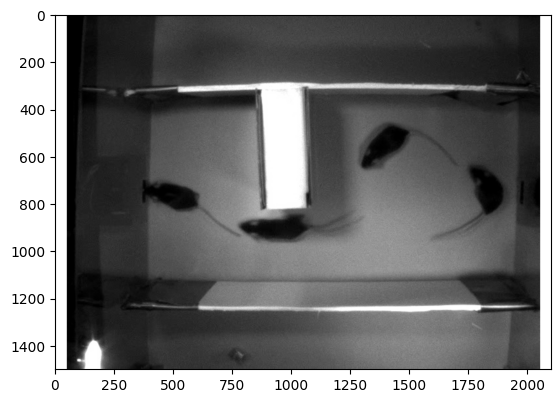

In [1604]:

plt.imshow(img)


In [1745]:
frames = trial.trial_vidframes
animal = trial.animal
date = trial.date
print(frames,animal,date)

[[20309 20310 20311 20312 20313 20314 20315 20316 20317 20318 20319 20320
  20321 20322 20323 20324 20325 20326 20327 20328 20329 20330 20331 20332
  20333 20334 20335 20336 20337 20338 20339 20340 20341 20342 20343 20344
  20345 20346 20347 20348 20349 20350 20351 20352 20353 20354 20355 20356
  20357 20358 20359 20360 20361 20362 20363 20364 20365 20366 20367 20368
  20369 20370 20371 20372 20373 20374 20375 20376 20377 20378 20379 20380
  20381 20382 20383 20384 20385 20386 20387 20388 20389 20390 20391 20392
  20393 20394 20395 20396 20397 20398 20399 20400 20401 20402 20403 20404
  20405 20406 20407 20408 20409 20410 20411 20412 20413 20414 20415 20416
  20417 20418 20419 20420 20421 20422 20423 20424 20425 20426 20427 20428
  20429 20430 20431 20432 20433 20434 20435 20436 20437 20438 20439 20440
  20441 20442]] G8CK1LN 061323


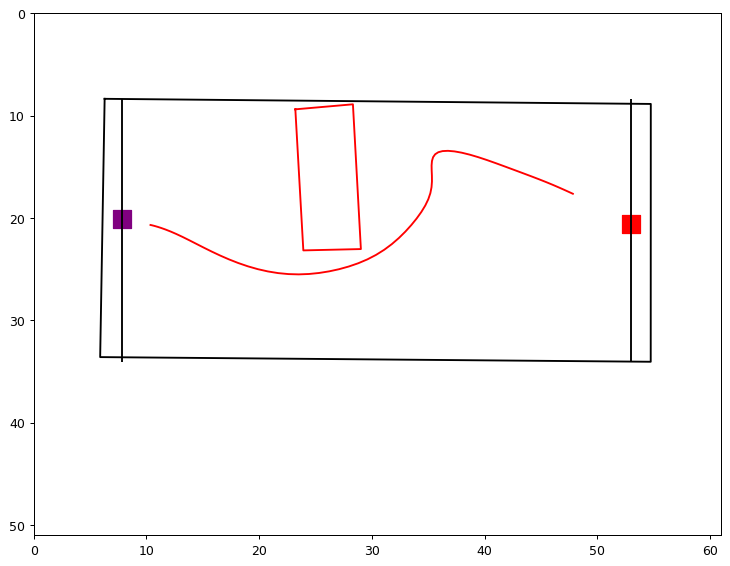

In [1799]:
cut_off =  reject_outliers(light_df['time'][(light_df['obstacle_cluster']==0)  & (light_df['odd']== 'right') & (light_df['start']== 'top')],m=1).max()
df = light_df[(light_df['obstacle_cluster']==0)&(light_df['start']=='top')&(light_df['time']<=cut_off)& (light_df['odd']== 'right')]
trial = df.iloc[16]
fig = plt.figure(constrained_layout=False, figsize=(8, 12),dpi=90)

spec2 = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])


ax1 = fig.add_subplot(panel_1[0,0])

plot_arena(trial,ax1)

ax1.plot([np.nanmean(trial['obstacleTL_x_cm']), np.nanmean(trial['obstacleTR_x_cm']), np.nanmean(trial['obstacleBR_x_cm']), np.nanmean(trial['obstacleBL_x_cm']),np.nanmean(trial['obstacleTL_x_cm'])],
                            [np.nanmean(trial['obstacleTL_y_cm']), np.nanmean(trial['obstacleTR_y_cm']), np.nanmean(trial['obstacleBR_y_cm']), np.nanmean(trial['obstacleBL_y_cm']),np.nanmean(trial['obstacleTL_y_cm'])],color='red')



ax1.plot(trial['ts_nose_x_cm'],trial['ts_nose_y_cm'],color = 'red')
fig.savefig(r'D:\obstacle_avoidance\recordings\061323\G8CK1LN\oa\example_trial.pdf')


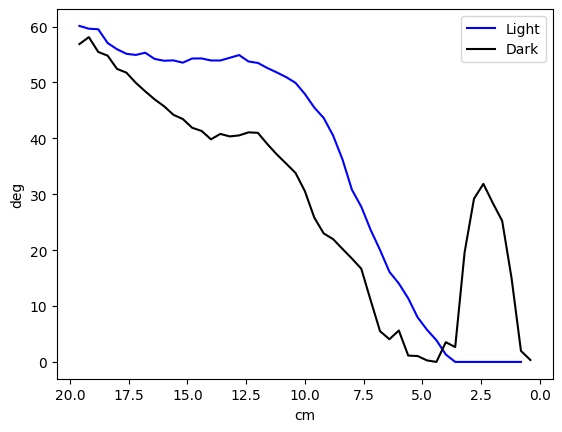

In [1747]:

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
cluster = 0 
start = 'top'
direction = 'right'
cut_off_light =  reject_outliers(light_df['time'][(light_df['obstacle_cluster']==cluster)  & (light_df['odd']== direction) & (light_df['start']== start)],m=1).max()
cut_off_dark =  reject_outliers(dark_df['time'][(dark_df['obstacle_cluster']==cluster)  & (dark_df['odd']== direction) & (dark_df['start']== start)],m=1).max()

df_light = light_df[(light_df['obstacle_cluster']==cluster)&(light_df['start']==start)&(light_df['time']<=cut_off_light)& (light_df['odd']== direction)]

df_dark = dark_df[(dark_df['obstacle_cluster']==cluster)&(dark_df['start']==start)&(dark_df['time']<=cut_off_dark)& (dark_df['odd']== direction)]


fig,ax1 = plt.subplots()
ax1.set_ylabel('deg')
ax1.set_xlabel('cm')
rows = df_light.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 

for i,row in enumerate(df_light.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax2.plot(xnew,ynew,c = 'grey',alpha = .5)
ax1.invert_xaxis()

ax1.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'blue',label = 'Light')

rows = df_dark.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 

for i,row in enumerate(df_dark.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax2.plot(xnew,ynew,c = 'grey',alpha = .5)


ax1.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'black',label = 'Dark')
ax1.legend()

#fig.savefig(r'D:\obstacle_avoidance\recordings\061323\G8CK1LN\oa\median_trace_angletocorner.pdf')

In [4]:
light_df

NameError: name 'light_df' is not defined

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
cluster = 0 
start = 'top'
direction = 'right'
cut_off_light =  reject_outliers(light_df['time'][(light_df['obstacle_cluster']==cluster)  & (light_df['odd']== direction) & (light_df['start']== start)],m=1).max()
cut_off_dark =  reject_outliers(dark_df['time'][(dark_df['obstacle_cluster']==cluster)  & (dark_df['odd']== direction) & (dark_df['start']== start)],m=1).max()

df_light = create_long_df(light_df)

df_dark = create_long_df(df_dark)

fig,ax1 = plt.subplots()
ax1.set_ylabel('deg')
ax1.set_xlabel('cm')
rows = df_light.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 

for i,row in enumerate(df_light.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax2.plot(xnew,ynew,c = 'grey',alpha = .5)
ax1.invert_xaxis()

ax1.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'blue',label = 'Light')

rows = df_dark.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 

for i,row in enumerate(df_dark.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax2.plot(xnew,ynew,c = 'grey',alpha = .5)


ax1.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'black',label = 'Dark')
ax1.legend()

NameError: name 'reject_outliers' is not defined

In [1685]:
df.task

49      oadark
53      oadark
54      oadark
102     oadark
104     oadark
         ...  
2643    oadark
2659    oadark
2695    oadark
2767    oadark
2848    oadark
Name: task, Length: 139, dtype: object

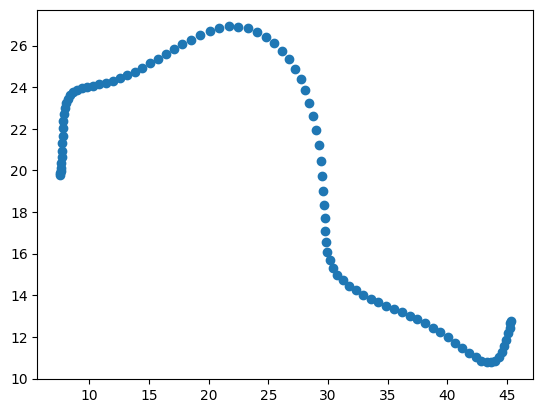

In [1684]:
plt.scatter(df.ts_nose_x_cm.to_numpy()[0],df.ts_nose_y_cm.to_numpy()[0])

In [1679]:
df.angle_to_leftport.to_numpy()[0]

array([73.07762060490688, 73.13550441560194, 73.174113690029,
       73.05351674159998, 72.59625477129059, 71.61919097597824,
       69.96546472565038, 67.52794866638244, 64.25992866617146,
       60.17551694761391, 55.353262452270634, 49.949701065385604,
       44.210818991621515, 38.45337311716835, 33.00242737545173,
       28.113912111930507, 23.93004453567984, 20.48586424692044,
       17.74792945319189, 15.652948329584607, 14.125261665078757,
       13.06975612674151, 12.353460533304753, 11.798778709951108,
       11.204396776252352, 10.393467999841022, 9.264644129853172,
       7.816489831814743, 6.124719920573144, 4.280484853855897,
       2.32059083801578, 0.18874358476151543, 2.2526790558253458,
       5.166372664186566, 8.667764071166173, 12.769398857997874,
       17.364357363075413, 22.253791428374807, 27.20200109762503,
       31.98878773638695, 36.436537540087166, 40.40902090182586,
       43.797633686937274, 46.51504733465373, 48.5066073983713,
       49.77556811052754, 

In [14]:
import copy
def zero_out_angle(df):
    for ind, row in df.iterrows():
        angle_array = copy.deepcopy(row['angle_to_corner'])
        zero = angle_array[np.abs(angle_array - 0).argmin()]
        zero_ind = np.where(angle_array == zero)[0][0]
        angle_array[zero_ind:] = 0 
        df.at[ind,'zero_out_angle_to_corner'] = angle_array.astype(object)

In [15]:
zero_out_angle(light_df)
zero_out_angle(dark_df)

(194, 50) (194, 50)
(89, 50) (89, 50)
(105, 50) (105, 50)


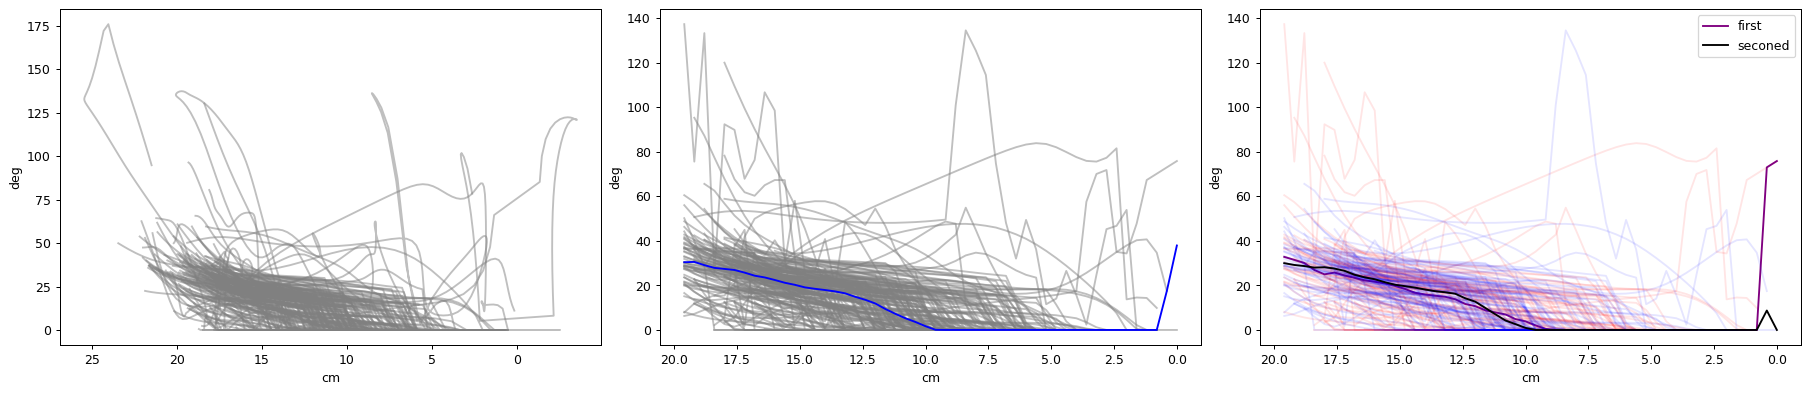

In [1786]:
cluster = 1 
start = 'top'
direction = 'left'
#cut_off =  reject_outliers(light_df['time'][(light_df['obstacle_cluster']==cluster)  & (light_df['odd']== direction) & (light_df['start']== start)],m=1).max()

#df = light_df[(light_df['obstacle_cluster']==cluster)&(light_df['start']==start)&(light_df['time']<=cut_off)& (light_df['odd']== direction)]
df = light_df[(light_df['obstacle_cluster']==cluster)&(light_df['start']==start)& (light_df['odd']== direction)]

fig = plt.figure(constrained_layout=False, figsize=(20, 8),dpi=90)
spec2 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])
panel_3 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[2])

ax1 = fig.add_subplot(panel_1[0,0])
ax2 = fig.add_subplot(panel_2[0,0])
ax3 = fig.add_subplot(panel_3[0,0])

ax1.set_ylabel('deg')
ax1.set_xlabel('cm')
ax2.set_ylabel('deg')
ax2.set_xlabel('cm')
ax3.set_ylabel('deg')
ax3.set_xlabel('cm')

for ind,row in df.iterrows():
    #length = int(row['len_facing_corner'])
    length = np.argwhere(row['distance_from_edge']>0).max()
    ax1.plot(row['distance_from_edge'][:length],row['zero_out_angle_to_corner'][:length],c = 'grey',alpha = .5)
ax1.invert_xaxis()
rows = df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 

for i,row in enumerate(df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax2.plot(xnew,ynew,c = 'grey',alpha = .5)
ax2.invert_xaxis()
print(distance_array.shape,angle_array.shape)
ax2.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'blue')
by_consecutive = df.groupby(['consecutive'])
for con,con_df in by_consecutive:
    if con == 1:
        first_df = con_df
    if con ==2:
        sec_df = con_df
rows = first_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 
for i,row in enumerate(first_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax3.plot(xnew,ynew,c = 'red',alpha = .1)
ax3.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'purple',label = 'first')
print(distance_array.shape,angle_array.shape)
rows = sec_df.shape[0]
angle_array_sec = np.empty([rows,50])
angle_array_sec[:] =np.nan 
distance_array_sec = np.empty([rows,50])
distance_array_sec[:] =np.nan 
for i,row in enumerate(sec_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array_sec[i] = xnew
    angle_array_sec[i] = ynew
    ax3.plot(xnew,ynew,c = 'blue',alpha = .1)
ax3.plot(np.nanmedian(distance_array_sec,axis = 0),np.nanmedian(angle_array_sec,axis = 0),c = 'black',label = 'seconed')
print(distance_array_sec.shape,angle_array_sec.shape)
ax3.invert_xaxis()
ax3.legend()

(144, 50) (144, 50)
(59, 50) (59, 50)
(85, 50) (85, 50)


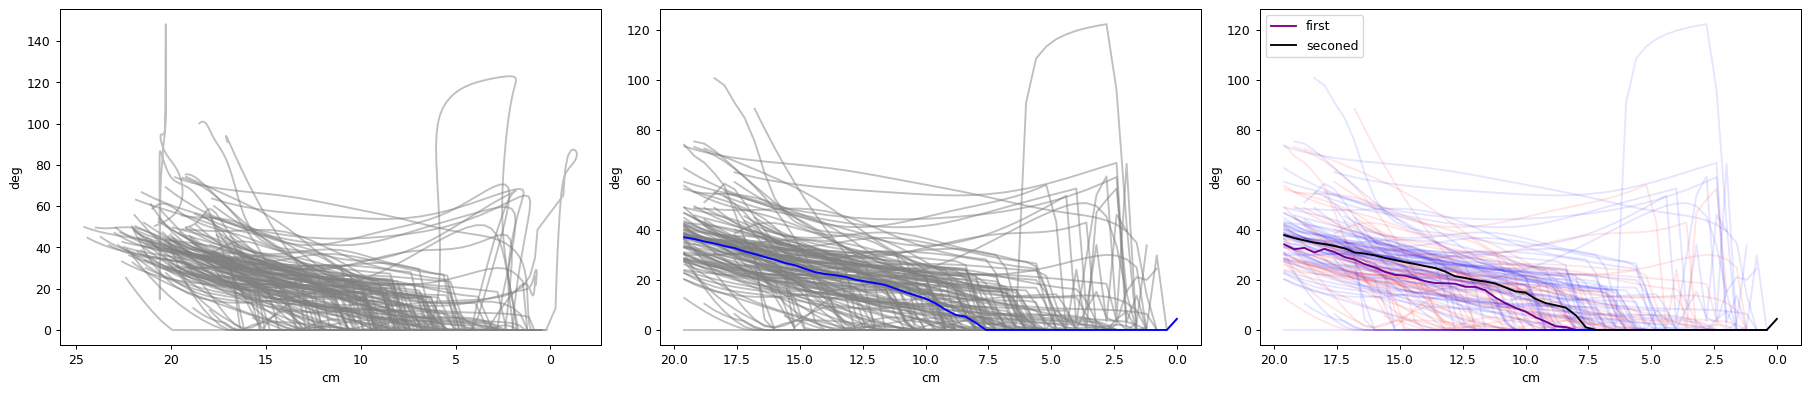

In [1787]:

#cut_off =  reject_outliers(dark_df['time'][(dark_df['obstacle_cluster']==cluster)  & (dark_df['odd']== direction) & (dark_df['start']== start)],m=2).max()

#df = dark_df[(dark_df['obstacle_cluster']==cluster)&(dark_df['start']==start)&(dark_df['time']<=cut_off)& (dark_df['odd']== direction)]
df = dark_df[(dark_df['obstacle_cluster']==cluster)&(dark_df['start']==start)&(dark_df['odd']== direction)]


fig = plt.figure(constrained_layout=False, figsize=(20, 8),dpi=90)
spec2 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])
panel_3 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[2])

ax1 = fig.add_subplot(panel_1[0,0])
ax2 = fig.add_subplot(panel_2[0,0])
ax3 = fig.add_subplot(panel_3[0,0])

ax1.set_ylabel('deg')
ax1.set_xlabel('cm')
ax2.set_ylabel('deg')
ax2.set_xlabel('cm')
ax3.set_ylabel('deg')
ax3.set_xlabel('cm')

for ind,row in df.iterrows():
    #length = int(row['len_facing_corner'])
    length = np.argwhere(row['distance_from_edge']>0).max()
    ax1.plot(row['distance_from_edge'][:length],row['zero_out_angle_to_corner'][:length],c = 'grey',alpha = .5)
ax1.invert_xaxis()
rows = df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 

for i,row in enumerate(df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax2.plot(xnew,ynew,c = 'grey',alpha = .5)
ax2.invert_xaxis()
print(distance_array.shape,angle_array.shape)
ax2.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'blue')
by_consecutive = df.groupby(['consecutive'])
for con,con_df in by_consecutive:
    if con == 1:
        first_df = con_df
    if con ==2:
        sec_df = con_df
rows = first_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 
for i,row in enumerate(first_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax3.plot(xnew,ynew,c = 'red',alpha = .1)
ax3.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'purple',label = 'first')
print(distance_array.shape,angle_array.shape)
rows = sec_df.shape[0]
angle_array_sec = np.empty([rows,50])
angle_array_sec[:] =np.nan 
distance_array_sec = np.empty([rows,50])
distance_array_sec[:] =np.nan 
for i,row in enumerate(sec_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array_sec[i] = xnew
    angle_array_sec[i] = ynew
    ax3.plot(xnew,ynew,c = 'blue',alpha = .1)
ax3.plot(np.nanmedian(distance_array_sec,axis = 0),np.nanmedian(angle_array_sec,axis = 0),c = 'black',label = 'seconed')
print(distance_array_sec.shape,angle_array_sec.shape)
ax3.invert_xaxis()
ax3.legend()

(874, 50) (874, 50)
(459, 50) (459, 50)
(415, 50) (415, 50)


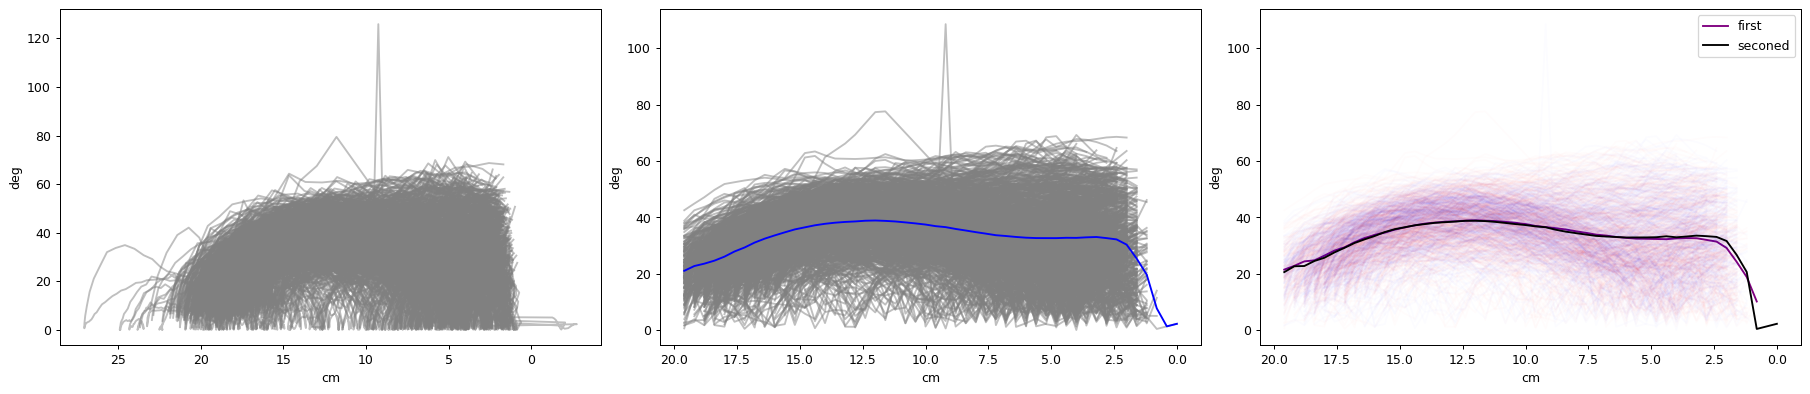

In [267]:
cluster_0 = dark_df[(dark_df['obstacle_cluster']==0)&(dark_df['start']=='top')&(dark_df['odd']== 'right')]
cluster_1 = dark_df[(dark_df['obstacle_cluster']==1)&(dark_df['start']=='top')&(dark_df['odd']== 'left')]
cluster_4 = dark_df[(dark_df['obstacle_cluster']==4)&(dark_df['start']=='bottom')&(dark_df['odd']== 'right')]
cluster_5 = dark_df[(dark_df['obstacle_cluster']==5)&(dark_df['start']=='bottom')&(dark_df['odd']== 'left')]

dark_long_df = pd.concat([cluster_0,cluster_1,cluster_4,cluster_5])

fig = plt.figure(constrained_layout=False, figsize=(20, 8),dpi=90)
spec2 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])
panel_3 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[2])

ax1 = fig.add_subplot(panel_1[0,0])
ax2 = fig.add_subplot(panel_2[0,0])
ax3 = fig.add_subplot(panel_3[0,0])

ax1.set_ylabel('deg')
ax1.set_xlabel('cm')
ax2.set_ylabel('deg')
ax2.set_xlabel('cm')
ax3.set_ylabel('deg')
ax3.set_xlabel('cm')

for ind,row in long_df.iterrows():
    #length = int(row['len_facing_corner'])
    length = np.argwhere(row['distance_from_edge']>1).max()
    ax1.plot(row['distance_from_edge'][:length],row['ts_speed'][:length],c = 'grey',alpha = .5)
ax1.invert_xaxis()
rows = long_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 

for i,row in enumerate(long_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>1).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['ts_speed'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax2.plot(xnew,ynew,c = 'grey',alpha = .5)
ax2.invert_xaxis()
print(distance_array.shape,angle_array.shape)
ax2.plot(np.nanmean(distance_array,axis = 0),np.nanmean(angle_array,axis = 0),c = 'blue')
by_consecutive = long_df.groupby(['consecutive'])
for con,con_df in by_consecutive:
    if con == 1:
        first_df = con_df
    if con ==2:
        sec_df = con_df
rows = first_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 
for i,row in enumerate(first_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>1).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['ts_speed'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax3.plot(xnew,ynew,c = 'red',alpha = .01)
ax3.plot(np.nanmean(distance_array,axis = 0),np.nanmean(angle_array,axis = 0),c = 'purple',label = 'first')
print(distance_array.shape,angle_array.shape)
rows = sec_df.shape[0]
angle_array_sec = np.empty([rows,50])
angle_array_sec[:] =np.nan 
distance_array_sec = np.empty([rows,50])
distance_array_sec[:] =np.nan 
for i,row in enumerate(sec_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>1).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['ts_speed'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array_sec[i] = xnew
    angle_array_sec[i] = ynew
    ax3.plot(xnew,ynew,c = 'blue',alpha = .01)
ax3.plot(np.nanmean(distance_array_sec,axis = 0),np.nanmean(angle_array_sec,axis = 0),c = 'black',label = 'seconed')
print(distance_array_sec.shape,angle_array_sec.shape)
ax3.invert_xaxis()
ax3.legend()

(891, 50) (891, 50)
(468, 50) (468, 50)
(423, 50) (423, 50)


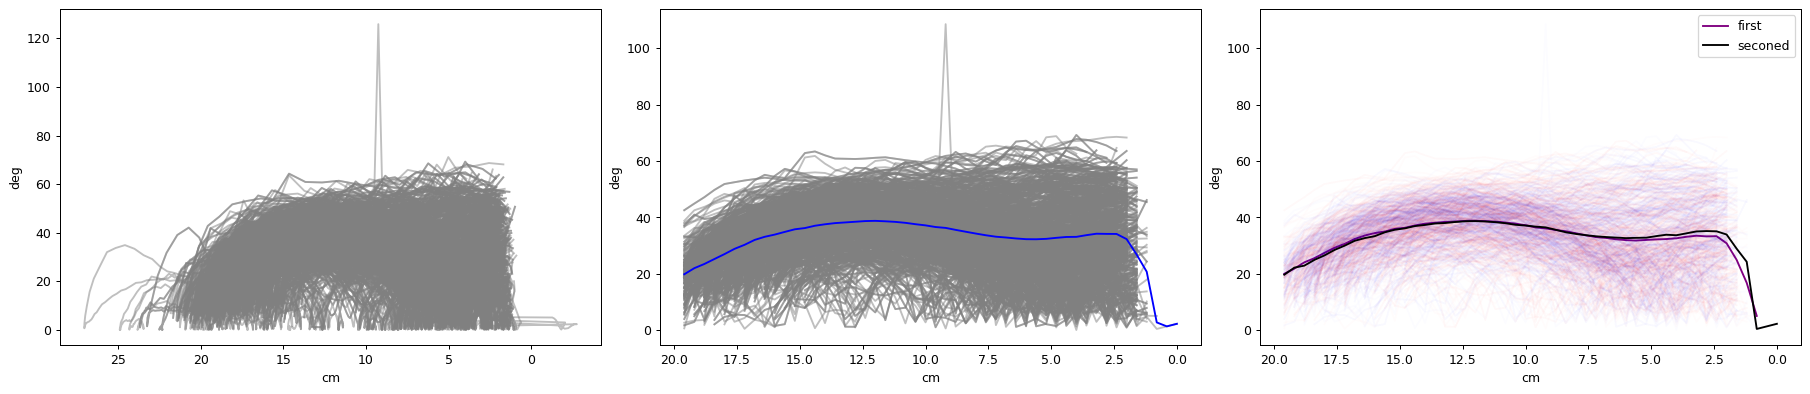

In [1947]:
cluster_0 = light_df[(light_df['obstacle_cluster']==0)&(light_df['start']=='top')&(light_df['odd']== 'right')]
cluster_1 = light_df[(light_df['obstacle_cluster']==1)&(light_df['start']=='top')&(light_df['odd']== 'left')]
cluster_4 = light_df[(light_df['obstacle_cluster']==4)&(light_df['start']=='bottom')&(light_df['odd']== 'right')]
cluster_5 = light_df[(light_df['obstacle_cluster']==0)&(light_df['start']=='top')&(light_df['odd']== 'right')]

long_df = pd.concat([cluster_0,cluster_1,cluster_4,cluster_5])

fig = plt.figure(constrained_layout=False, figsize=(20, 8),dpi=90)
spec2 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])
panel_3 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[2])

ax1 = fig.add_subplot(panel_1[0,0])
ax2 = fig.add_subplot(panel_2[0,0])
ax3 = fig.add_subplot(panel_3[0,0])

ax1.set_ylabel('deg')
ax1.set_xlabel('cm')
ax2.set_ylabel('deg')
ax2.set_xlabel('cm')
ax3.set_ylabel('deg')
ax3.set_xlabel('cm')

for ind,row in long_df.iterrows():
    #length = int(row['len_facing_corner'])
    length = np.argwhere(row['distance_from_edge']>1).max()
    ax1.plot(row['distance_from_edge'][:length],row['ts_speed'][:length],c = 'grey',alpha = .5)
ax1.invert_xaxis()
rows = long_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 

for i,row in enumerate(long_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>1).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['ts_speed'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax2.plot(xnew,ynew,c = 'grey',alpha = .5)
ax2.invert_xaxis()
print(distance_array.shape,angle_array.shape)
ax2.plot(np.nanmean(distance_array,axis = 0),np.nanmean(angle_array,axis = 0),c = 'blue')
by_consecutive = long_df.groupby(['consecutive'])
for con,con_df in by_consecutive:
    if con == 1:
        first_df = con_df
    if con ==2:
        sec_df = con_df
rows = first_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 
for i,row in enumerate(first_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>1).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['ts_speed'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax3.plot(xnew,ynew,c = 'red',alpha = .01)
ax3.plot(np.nanmean(distance_array,axis = 0),np.nanmean(angle_array,axis = 0),c = 'purple',label = 'first')
print(distance_array.shape,angle_array.shape)
rows = sec_df.shape[0]
angle_array_sec = np.empty([rows,50])
angle_array_sec[:] =np.nan 
distance_array_sec = np.empty([rows,50])
distance_array_sec[:] =np.nan 
for i,row in enumerate(sec_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>1).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['ts_speed'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array_sec[i] = xnew
    angle_array_sec[i] = ynew
    ax3.plot(xnew,ynew,c = 'blue',alpha = .01)
ax3.plot(np.nanmean(distance_array_sec,axis = 0),np.nanmean(angle_array_sec,axis = 0),c = 'black',label = 'seconed')
print(distance_array_sec.shape,angle_array_sec.shape)
ax3.invert_xaxis()
ax3.legend()

In [237]:
def compute_tortuosity(x_coordinates, y_coordinates):
    if len(x_coordinates) != len(y_coordinates):
        raise ValueError("Input arrays must have the same length.")

    # Calculate the path length
    path_length = 0
    for i in range(1, len(x_coordinates)):
        dx = x_coordinates[i] - x_coordinates[i-1]
        dy = y_coordinates[i] - y_coordinates[i-1]
        path_length += np.sqrt(dx**2 + dy**2)

    # Calculate the Euclidean distance
    start_point = (x_coordinates[0], y_coordinates[0])
    end_point = (x_coordinates[-1], y_coordinates[-1])
    euclidean_distance = np.sqrt((end_point[0] - start_point[0])**2 + (end_point[1] - start_point[1])**2)

    # Compute tortuosity as the ratio of path length to Euclidean distance
    tortuosity = path_length / euclidean_distance
    linearity = 1/tortuosity 

    return tortuosity,linearity

In [226]:
tor = compute_tortuosity(row['ts_nose_x_cm'][:target+1],row['ts_nose_y_cm'][:target+1])

In [268]:
for ind,row in dark_long_df.iterrows():
    target =  np.argwhere((-1< row['distance_from_edge']) ).max()
    tor,lin= compute_tortuosity(row['ts_nose_x_cm'][:target+1],row['ts_nose_y_cm'][:target+1])
    dark_long_df.at[ind,'tortuosity']=tor
    dark_long_df.at[ind,'linearity']=lin

In [269]:
for ind,row in long_df.iterrows():
    target =  np.argwhere((-1< row['distance_from_edge']) ).max()
    tor,lin= compute_tortuosity(row['ts_nose_x_cm'][:target+1],row['ts_nose_y_cm'][:target+1])
    long_df.at[ind,'tortuosity']=tor
    long_df.at[ind,'linearity']=lin
    

In [273]:
dark_long_df.tortuosity.mean()

1.3104881499747316

In [275]:
long_df.tortuosity.mean()

1.2076560438626767

(array([2.39138533, 0.53754483, 0.0585786 , 0.0068916 , 0.0103374 ,
        0.        , 0.        , 0.0034458 , 0.        , 0.0034458 ]),
 array([1.0003831 , 1.33242927, 1.66447544, 1.99652161, 2.32856778,
        2.66061395, 2.99266012, 3.32470629, 3.65675246, 3.98879864,
        4.32084481]),
 <BarContainer object of 10 artists>)

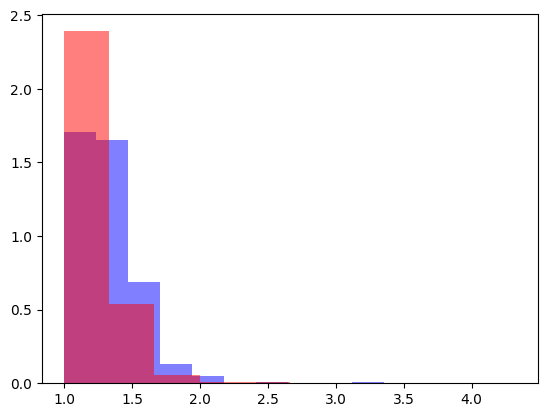

In [276]:
plt.hist(dark_long_df.tortuosity,density=True,color = 'blue',alpha =.5)
plt.hist(long_df.tortuosity,density=True,color = 'red',alpha = .5)

(array([0.02978894, 0.        , 0.04468342, 0.1042613 , 0.26810049,
        0.75961806, 2.14480392, 2.50227124, 2.8895275 , 4.27471337]),
 array([0.23143622, 0.30825431, 0.38507239, 0.46189047, 0.53870855,
        0.61552664, 0.69234472, 0.7691628 , 0.84598089, 0.92279897,
        0.99961705]),
 <BarContainer object of 10 artists>)

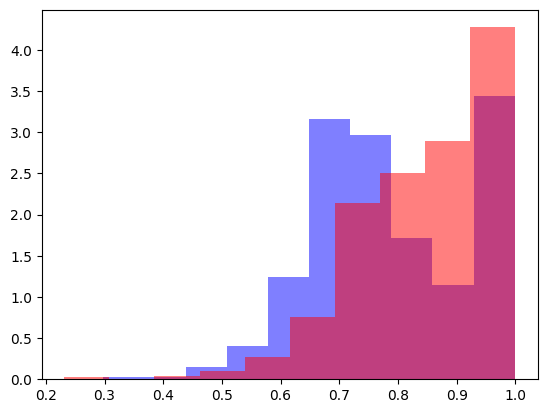

In [271]:
plt.hist(dark_long_df.linearity,density=True,color = 'blue',alpha =.5)
plt.hist(long_df.linearity,density=True,color = 'red',alpha = .5)

(array([0.03443533, 0.17217667, 0.34435335, 0.99862471, 2.61708544,
        3.34022747, 1.54959006, 1.27410739, 1.27410739, 4.92425287]),
 array([0.39498384, 0.45548371, 0.51598359, 0.57648346, 0.63698333,
        0.6974832 , 0.75798307, 0.81848294, 0.87898282, 0.93948269,
        0.99998256]),
 <BarContainer object of 10 artists>)

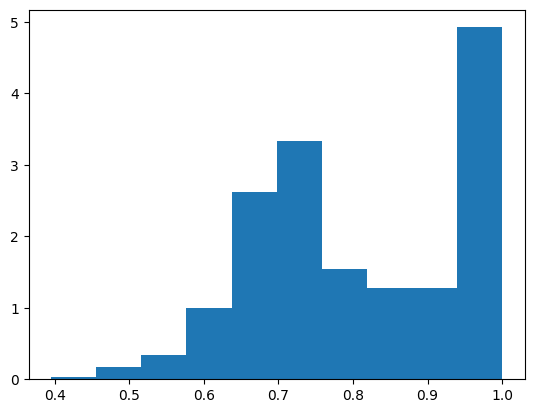

In [253]:
plt.hist(long_df.linearity,density=True)

In [246]:
print(long_df.tortuosity.mean(),long_df.linearity.mean())

1.2760959542627832 0.8088913083743823


In [247]:
print(dark_long_df.tortuosity.mean(),dark_long_df.linearity.mean())

1.301475326623593 0.7906588107420812


39.42646714633999


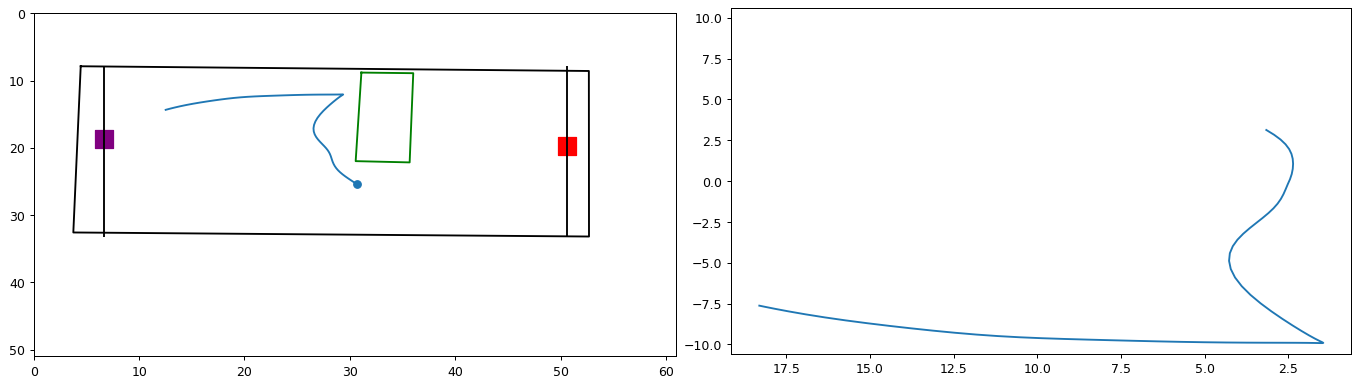

In [230]:
cluster_0 = dark_df[(dark_df['obstacle_cluster']==0)&(dark_df['start']=='top')&(dark_df['odd']== 'right')]
cluster_1 = dark_df[(dark_df['obstacle_cluster']==1)&(dark_df['start']=='top')&(dark_df['odd']== 'left')]
cluster_4 = dark_df[(dark_df['obstacle_cluster']==4)&(dark_df['start']=='bottom')&(dark_df['odd']== 'right')]
cluster_5 = dark_df[(dark_df['obstacle_cluster']==0)&(dark_df['start']=='bottom')&(dark_df['odd']== 'left')]

long_df = pd.concat([cluster_0,cluster_1,cluster_4,cluster_5])
df = long_df.sample(1)
for ind,row in df.iterrows():
    fig = plt.figure(constrained_layout=False, figsize=(15, 8),dpi=90)

    spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
    panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])

    ax1 = fig.add_subplot(panel_1[0,0])
    ax2 = fig.add_subplot(panel_2[0,0])
    plot_arena(row,ax1)
    length = np.argwhere(row['distance_from_edge']>-1).max()
    target =  np.argwhere((-1< row['distance_from_edge']) ).max()
    ax1.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                                [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')
   





    ax1.plot(row['ts_nose_x_cm'][:target+1],row['ts_nose_y_cm'][:target+1])
    ax2.plot(row['distance_from_edge'][:length],row['lateral_error'][:length])
    ax1.scatter(row['ts_nose_x_cm'][target],row['ts_nose_y_cm'][target])
    ax2.invert_xaxis()
    symmetrize_y_axis(ax2)
    print(np.nansum(row['ts_distance'][:length]))

In [231]:
tor = compute_tortuosity(row['ts_nose_x_cm'][:target+1],row['ts_nose_y_cm'][:target+1])
tor

1.527576442392657

In [232]:
1/tor

0.6546317239834433

31.304082180706647
41.72758422831071
26.262654622032798
12.188600579405074
36.4663778370953
38.43318265496437
7.499811434451587
30.769134938328563
35.3244465575329
37.719554003706705


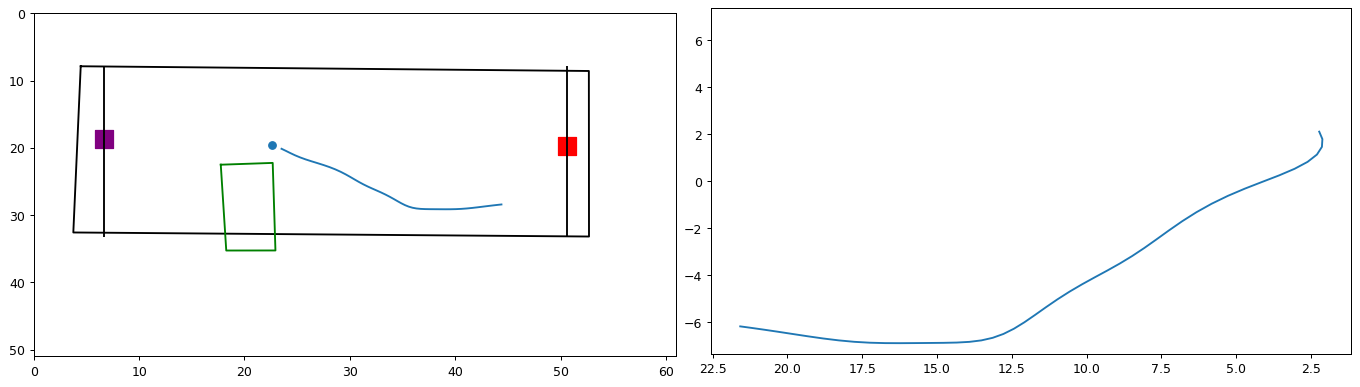

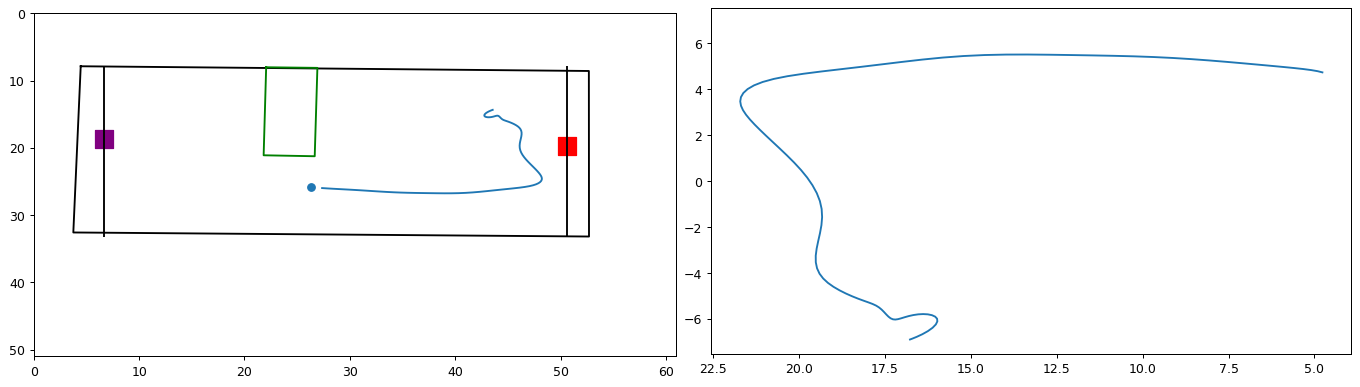

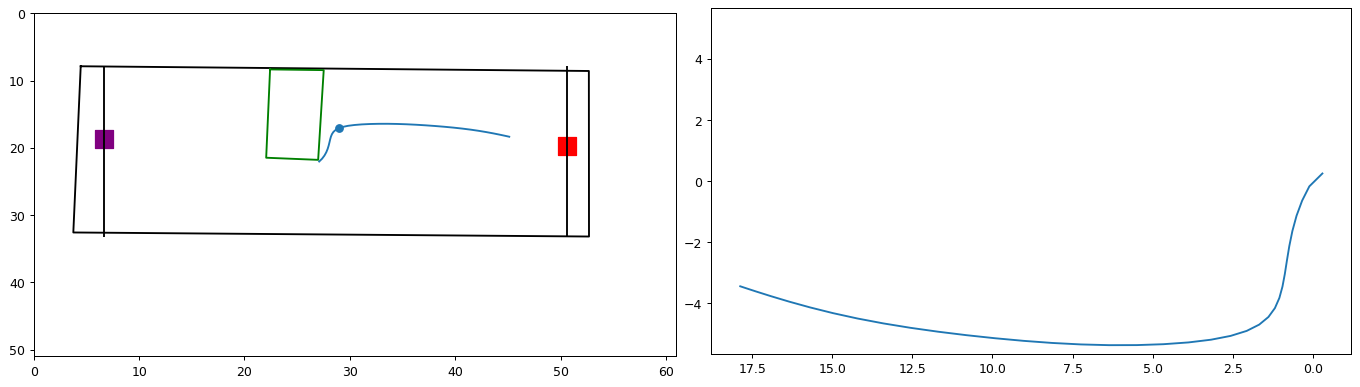

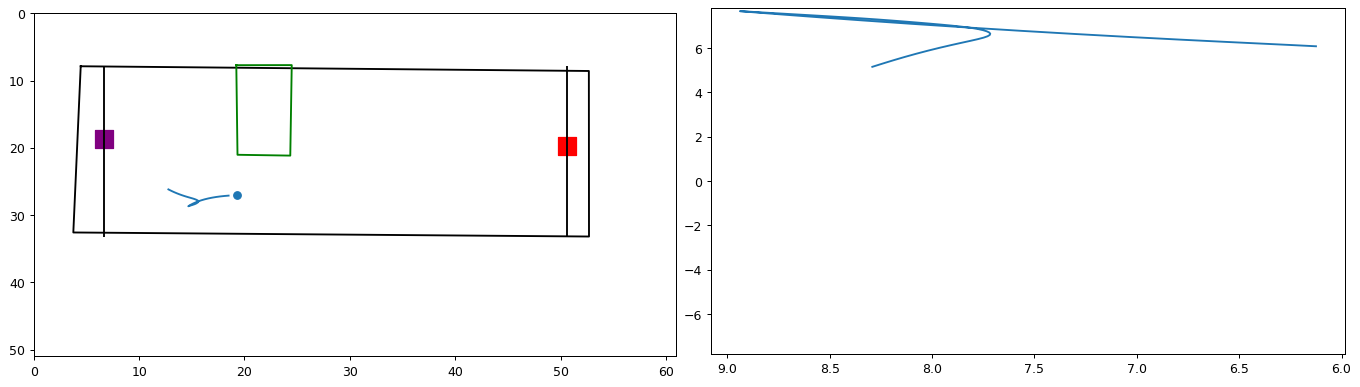

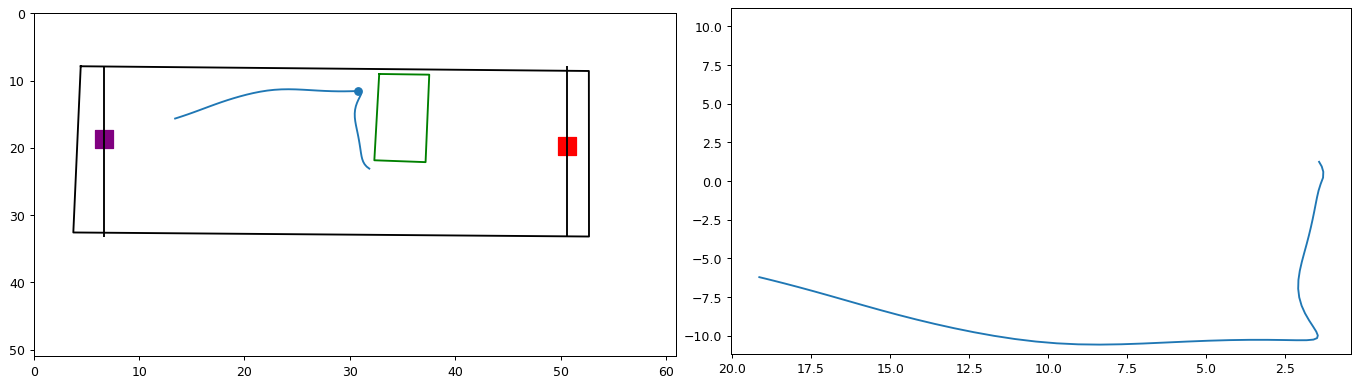

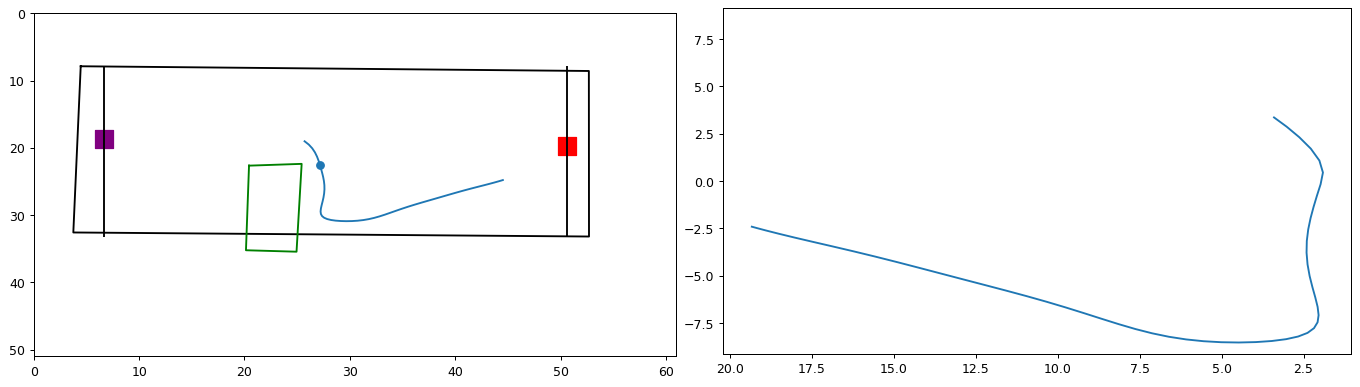

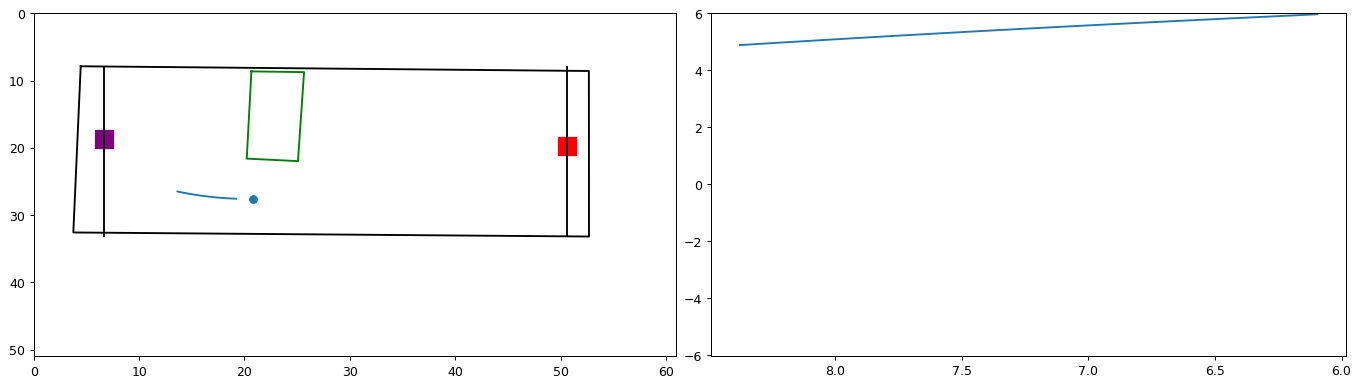

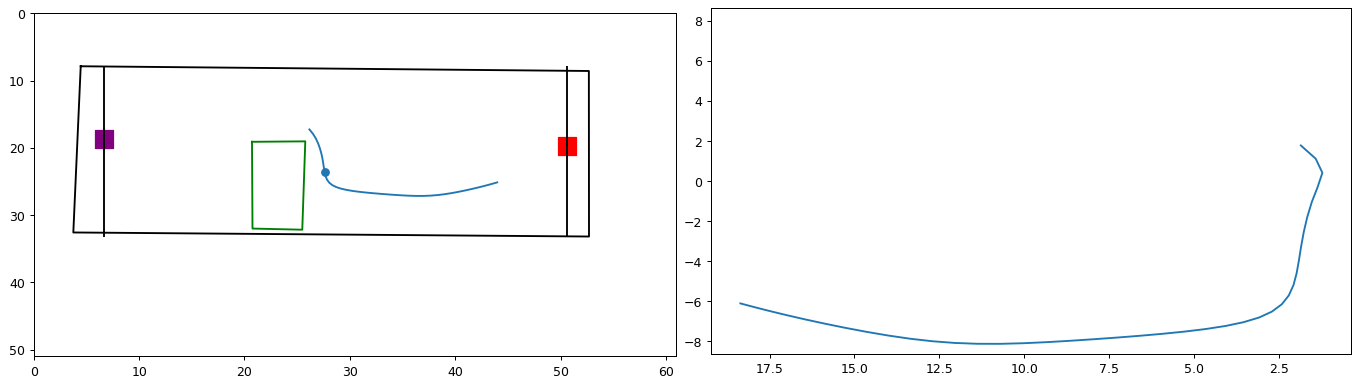

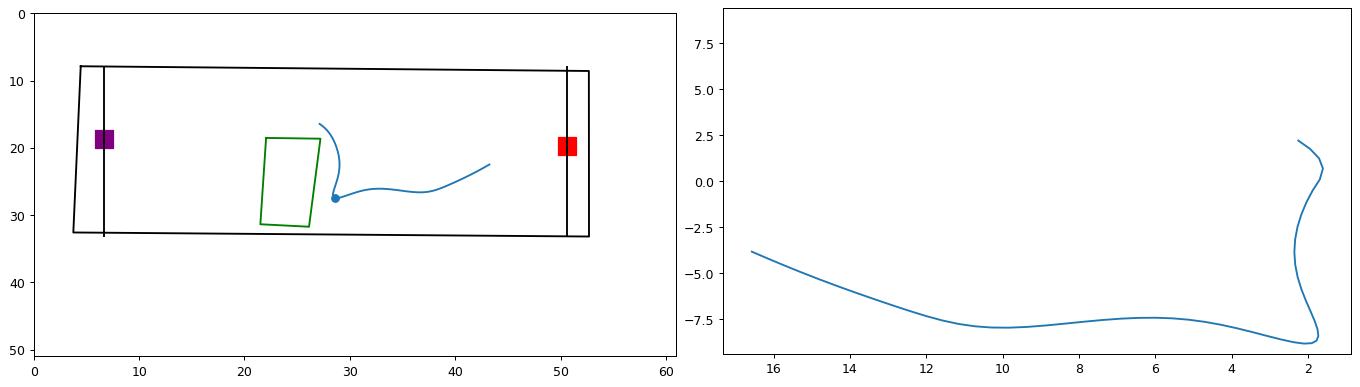

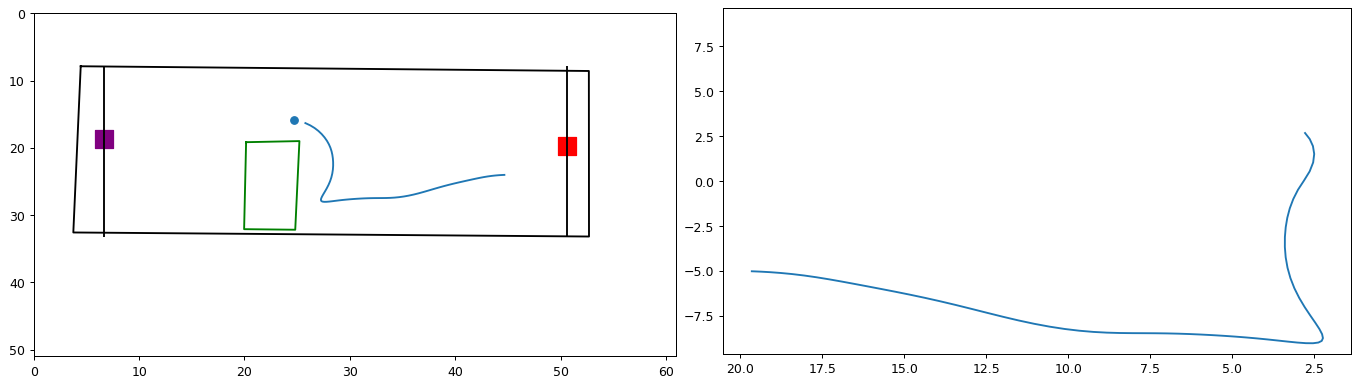

In [184]:
cluster_0 = dark_df[(dark_df['obstacle_cluster']==0)&(dark_df['start']=='top')&(dark_df['odd']== 'right')]
cluster_1 = dark_df[(dark_df['obstacle_cluster']==1)&(dark_df['start']=='top')&(dark_df['odd']== 'left')]
cluster_4 = dark_df[(dark_df['obstacle_cluster']==4)&(dark_df['start']=='bottom')&(dark_df['odd']== 'right')]
cluster_5 = dark_df[(dark_df['obstacle_cluster']==0)&(dark_df['start']=='bottom')&(dark_df['odd']== 'left')]

long_df = pd.concat([cluster_0,cluster_1,cluster_4,cluster_5])
df = long_df.sample(10)
for ind,row in df.iterrows():
    fig = plt.figure(constrained_layout=False, figsize=(15, 8),dpi=90)

    spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
    panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])

    ax1 = fig.add_subplot(panel_1[0,0])
    ax2 = fig.add_subplot(panel_2[0,0])
    plot_arena(row,ax1)
    length = np.argwhere(row['distance_from_edge']>-1).max()
    target =  np.argwhere((2> row['distance_from_edge']) ).min()
    ax1.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                                [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')
   





    ax1.plot(row['ts_nose_x_cm'][:length],row['ts_nose_y_cm'][:length])
    ax2.plot(row['distance_from_edge'][:length],row['lateral_error'][:length])
    ax1.scatter(row['ts_nose_x_cm'][target],row['ts_nose_y_cm'][target])
    ax2.invert_xaxis()
    symmetrize_y_axis(ax2)
    print(np.nansum(row['ts_distance'][:length]))

26.354876835876112
34.023424106671925
29.792070158922165
33.060741521382724
34.783976880024
29.135871845610005
36.54836340272457
18.947358956777222
23.400332578926744
25.426071871357486


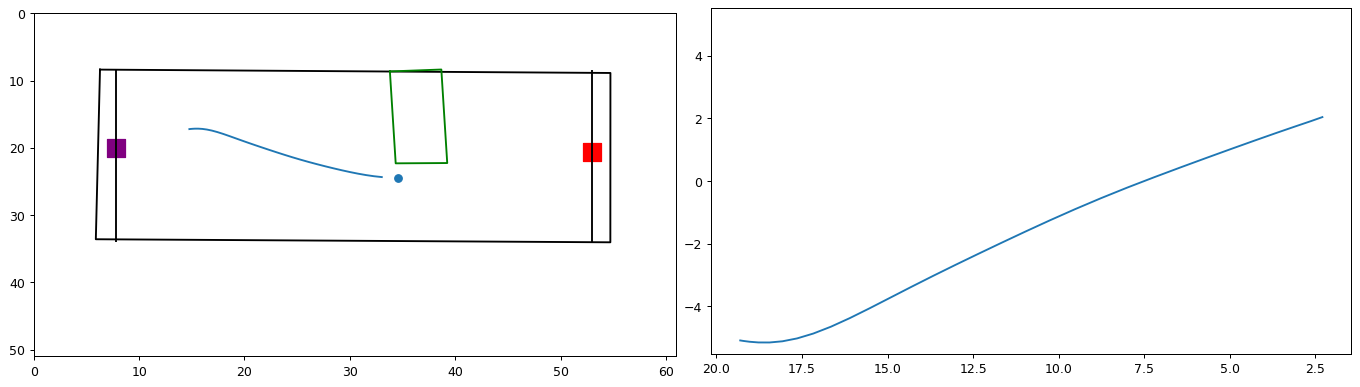

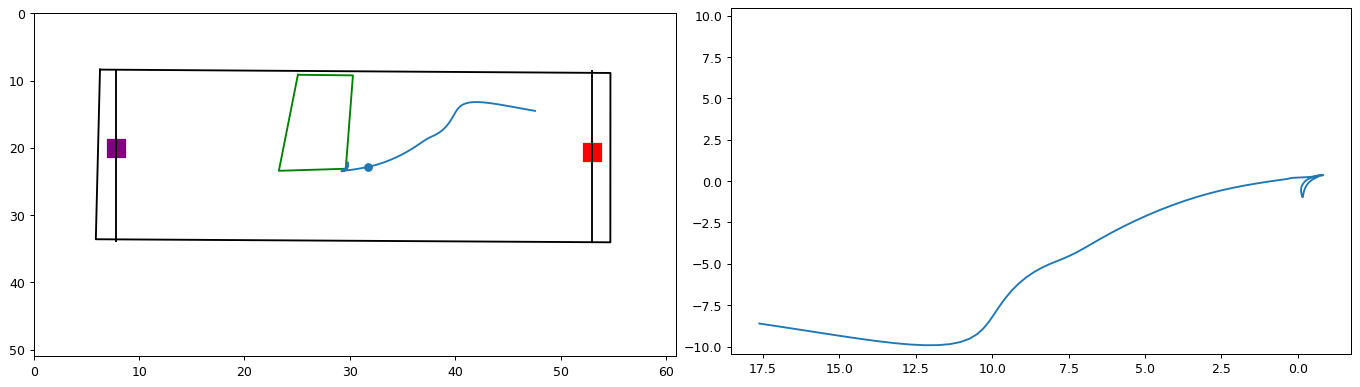

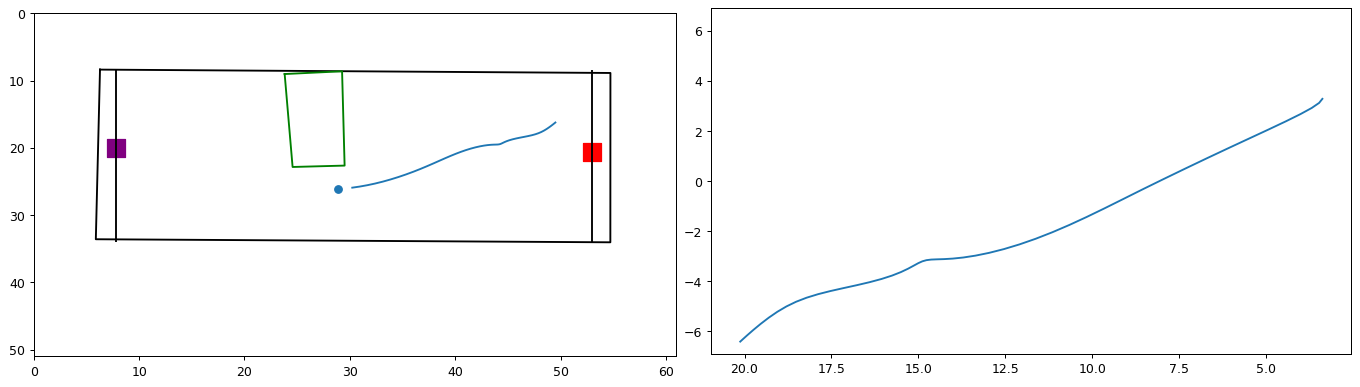

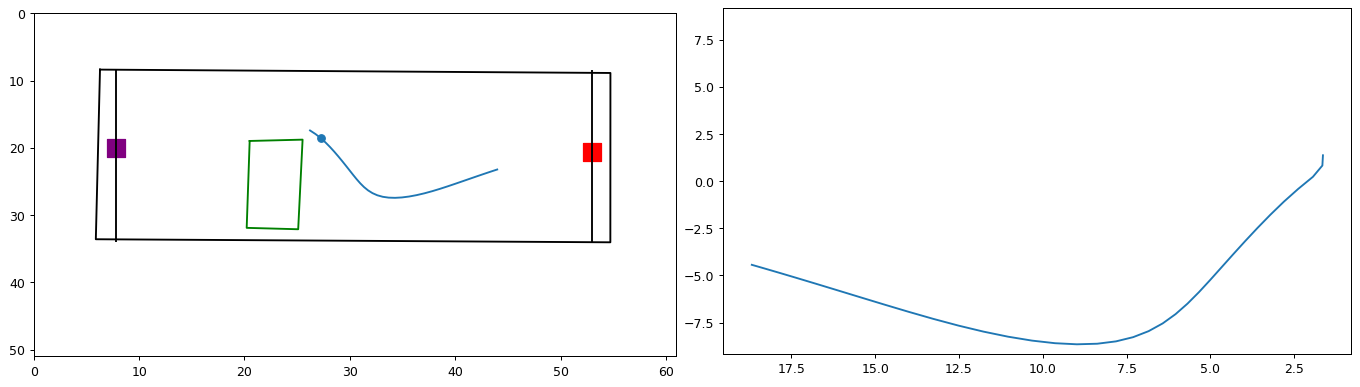

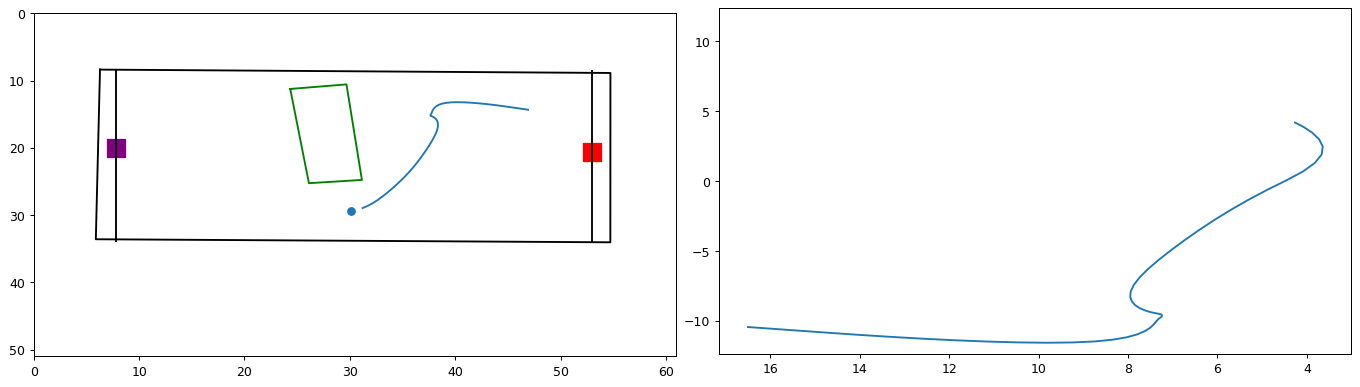

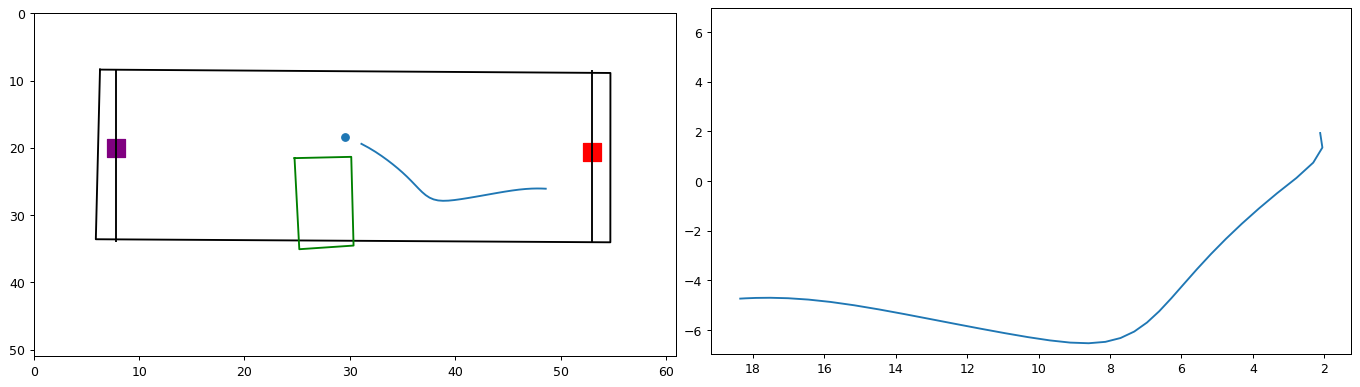

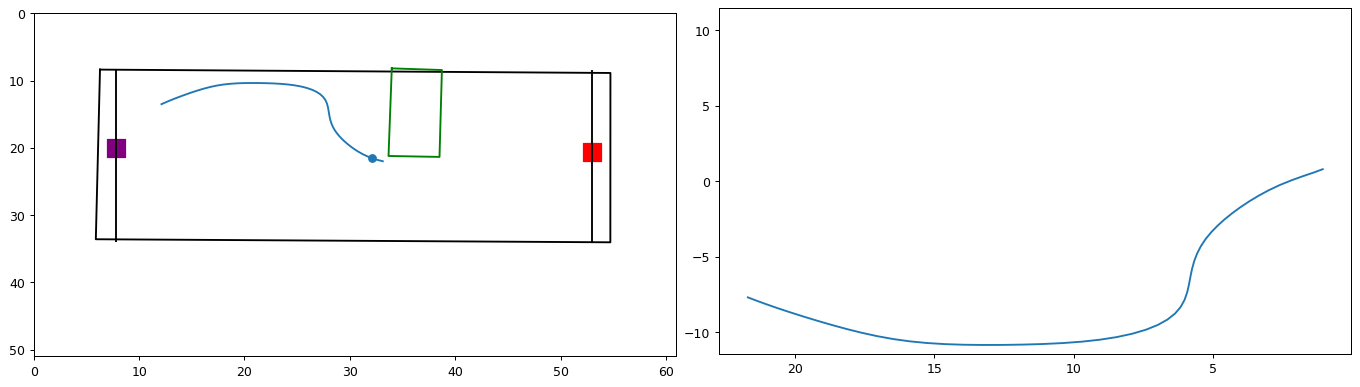

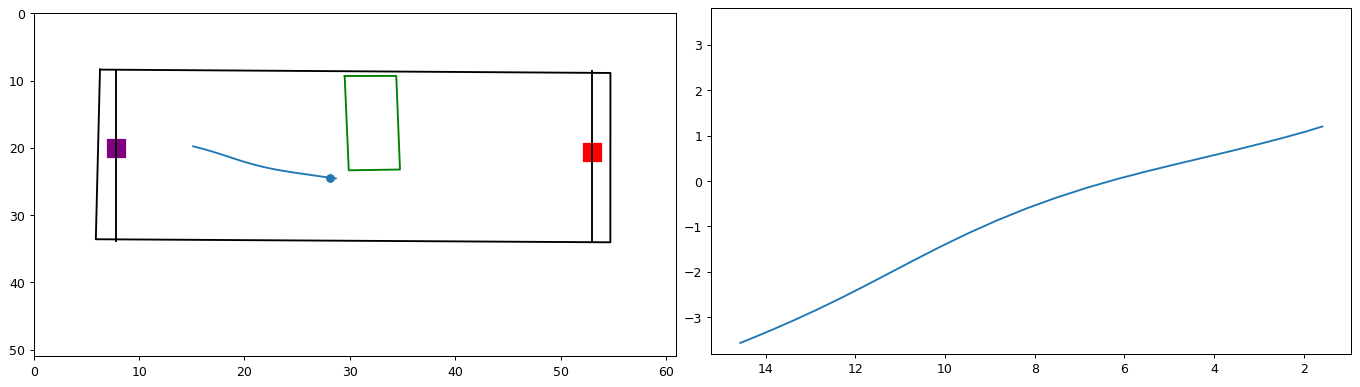

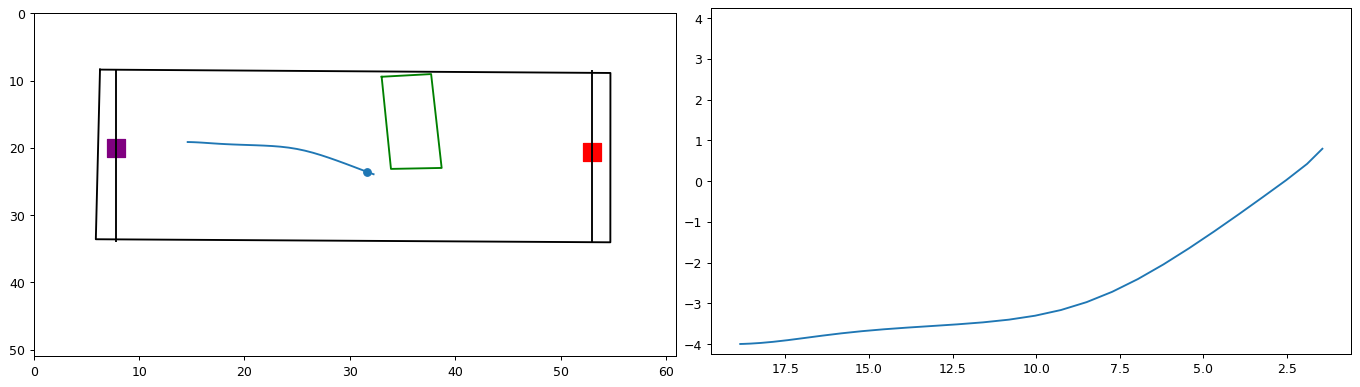

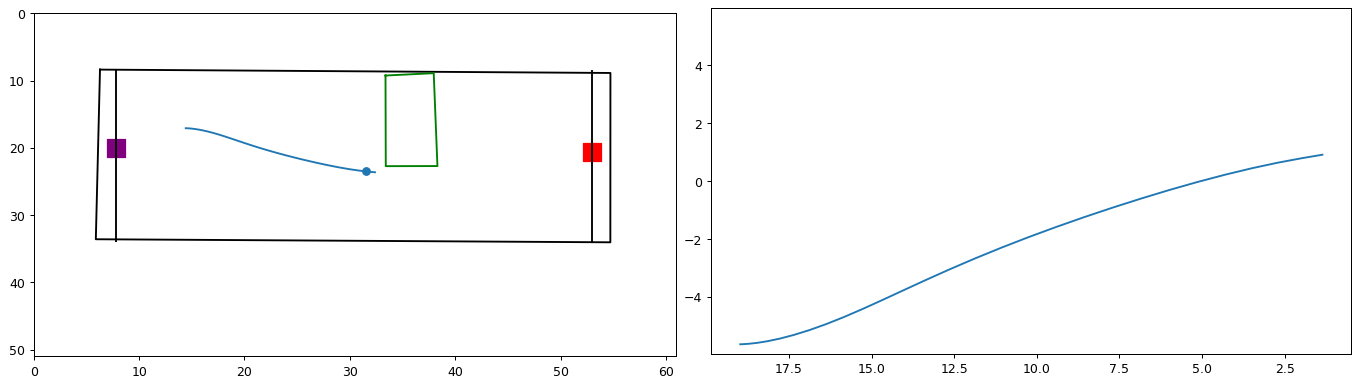

In [183]:
cluster_0 = light_df[(light_df['obstacle_cluster']==0)&(light_df['start']=='top')&(light_df['odd']== 'right')]
cluster_1 = light_df[(light_df['obstacle_cluster']==1)&(light_df['start']=='top')&(light_df['odd']== 'left')]
cluster_4 = light_df[(light_df['obstacle_cluster']==4)&(light_df['start']=='bottom')&(light_df['odd']== 'right')]
cluster_5 = light_df[(light_df['obstacle_cluster']==0)&(light_df['start']=='bottom')&(light_df['odd']== 'left')]

long_df = pd.concat([cluster_0,cluster_1,cluster_4,cluster_5])
df = long_df.sample(10)
for ind,row in df.iterrows():
    fig = plt.figure(constrained_layout=False, figsize=(15, 8),dpi=90)

    spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
    panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])

    ax1 = fig.add_subplot(panel_1[0,0])
    ax2 = fig.add_subplot(panel_2[0,0])
    plot_arena(row,ax1)
    length = np.argwhere(row['distance_from_edge']>-1).max()
    target =  np.argwhere((2> row['distance_from_edge']) ).min()
    ax1.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                                [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')
   





    ax1.plot(row['ts_nose_x_cm'][:length],row['ts_nose_y_cm'][:length])
    ax2.plot(row['distance_from_edge'][:length],row['lateral_error'][:length])
    ax1.scatter(row['ts_nose_x_cm'][target],row['ts_nose_y_cm'][target])
    ax2.invert_xaxis()
    symmetrize_y_axis(ax2)
    print(np.nansum(row['ts_distance'][:length]))


36.64365271146087
32.4793413748142
34.80665570788484
29.456521334027215
34.89243801435818
32.87914550535844
27.956941791166372
30.54967844397202
32.98262846902112
63.898585508341924


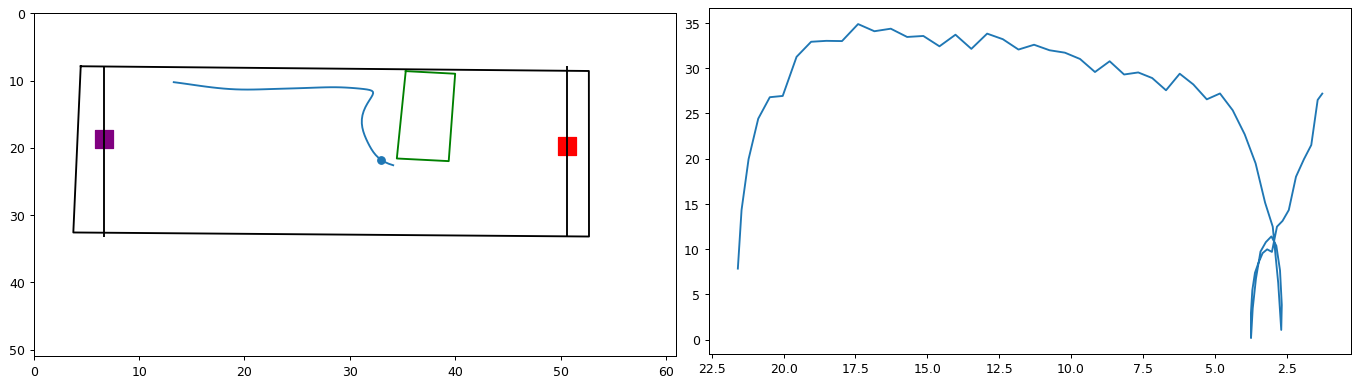

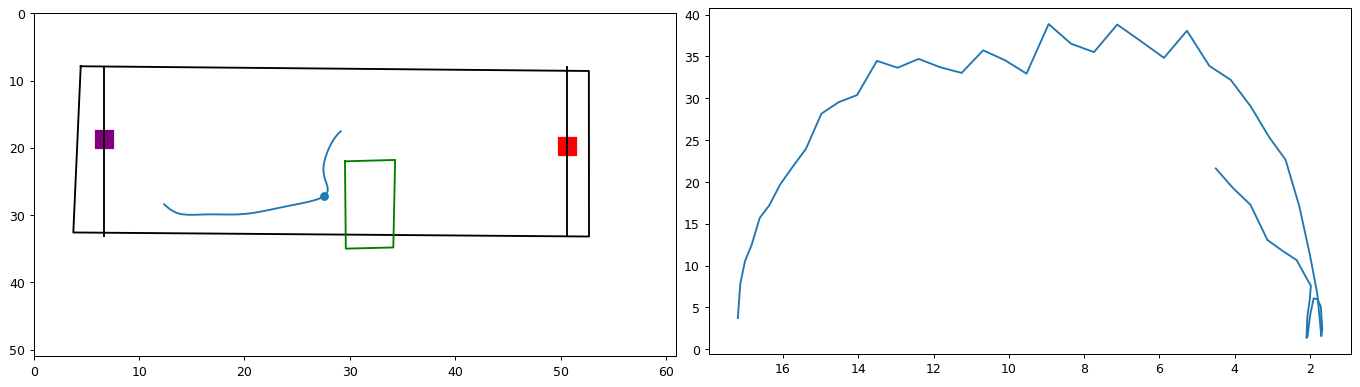

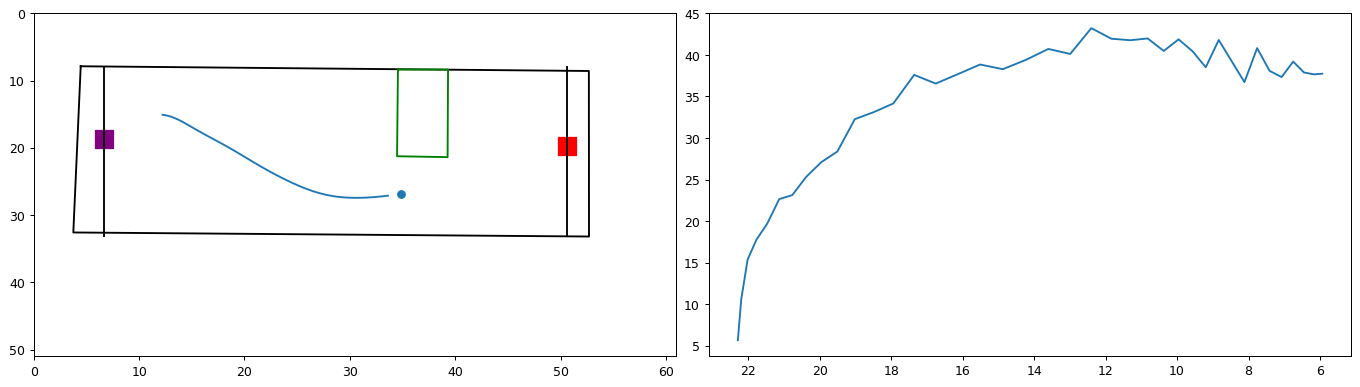

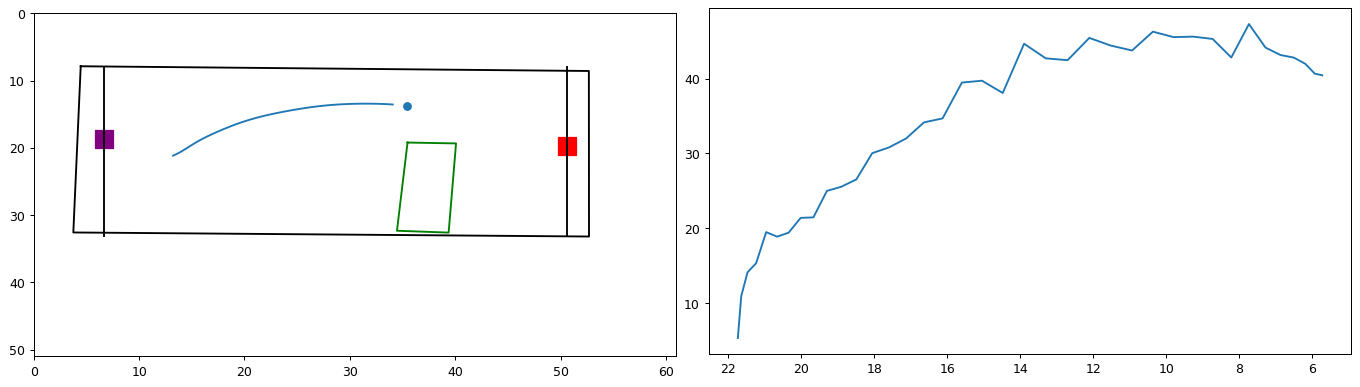

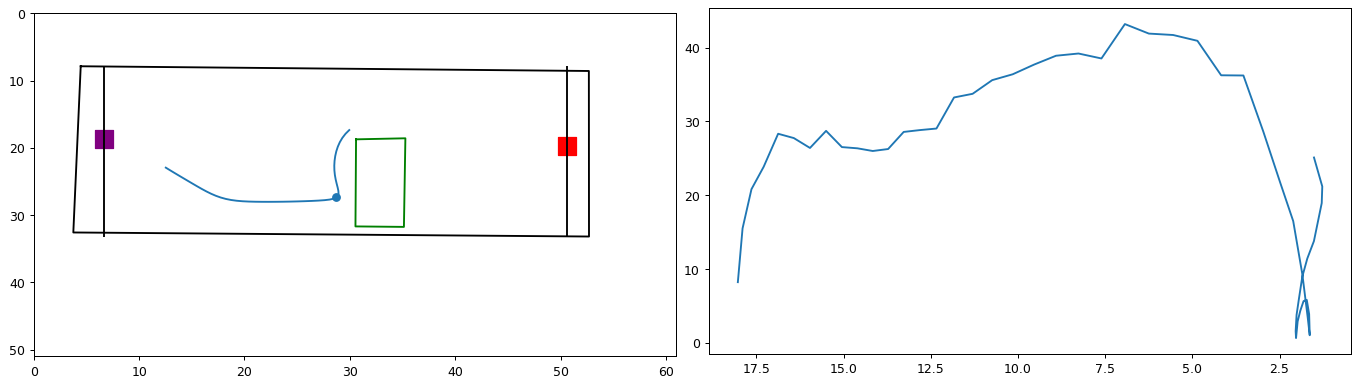

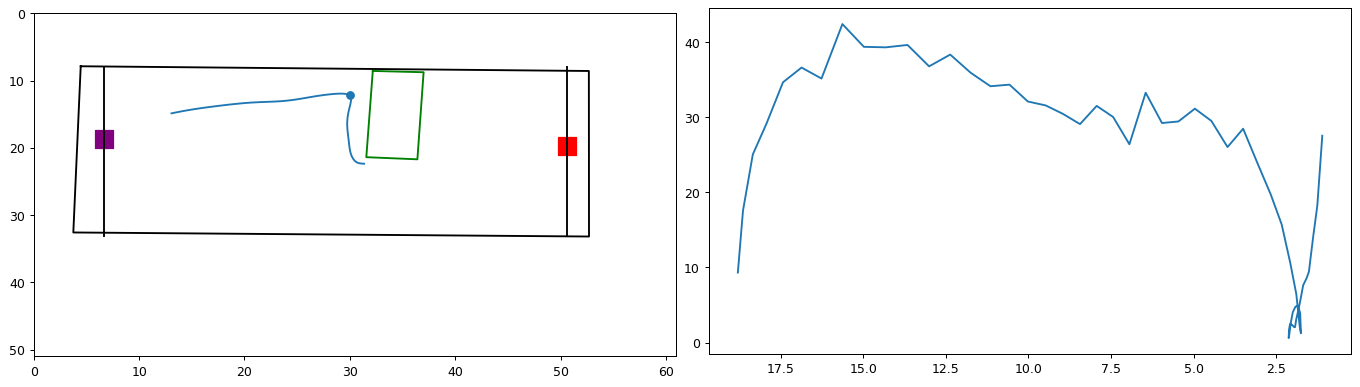

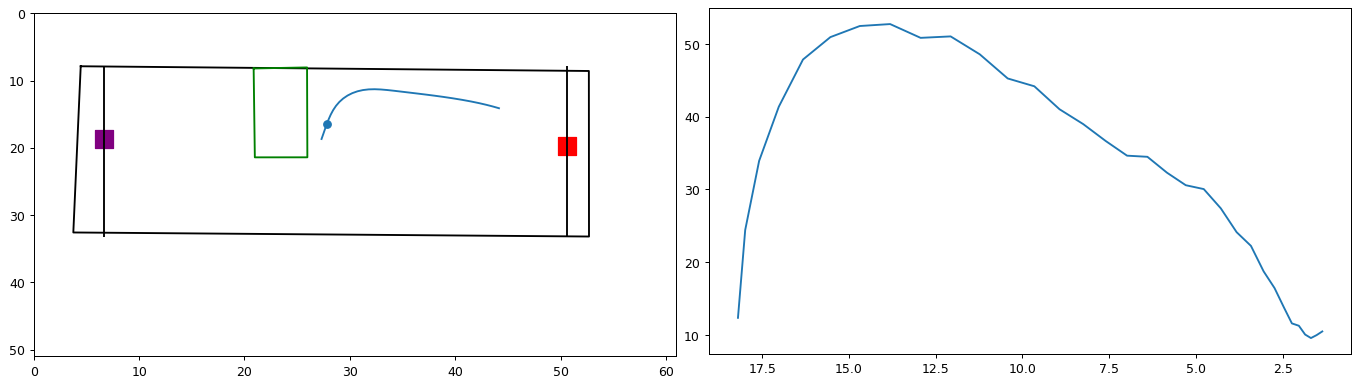

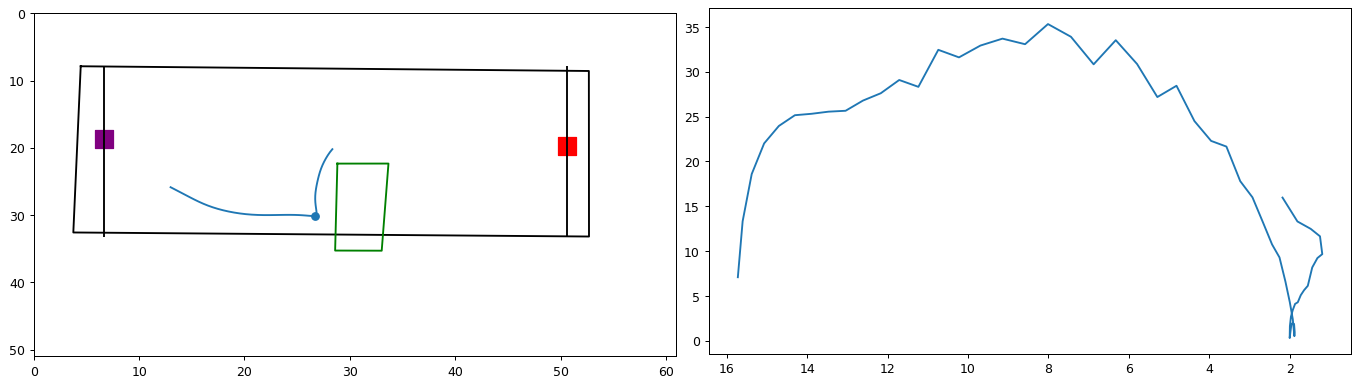

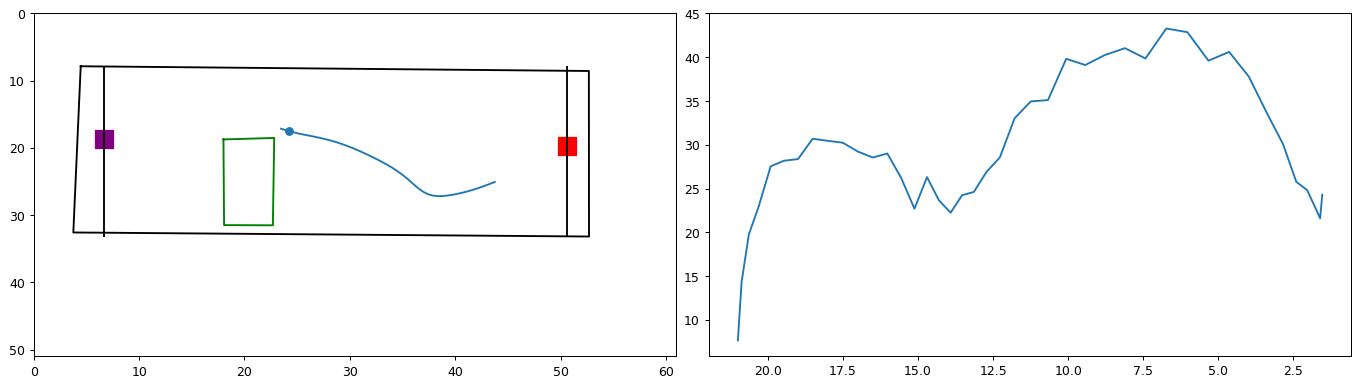

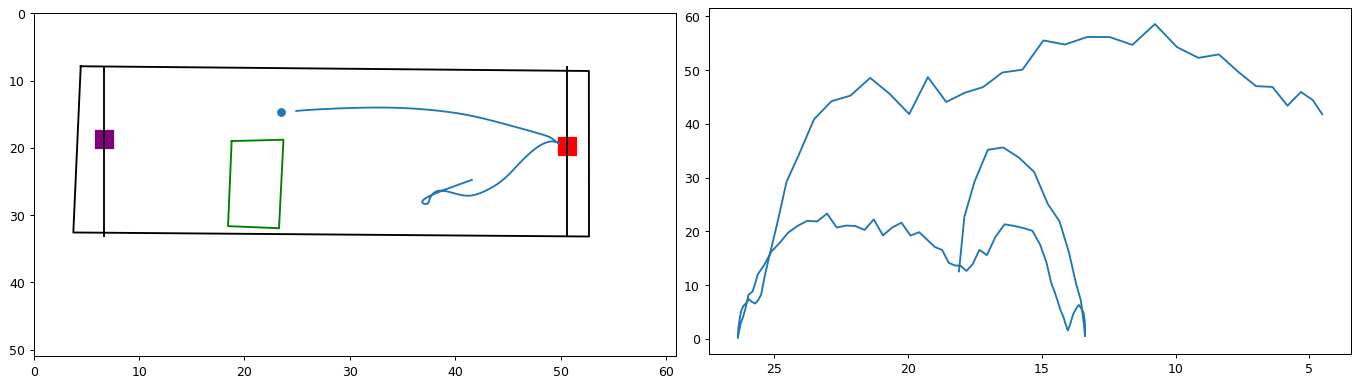

In [115]:
cluster_0 = dark_df[(dark_df['obstacle_cluster']==0)&(dark_df['start']=='top')&(dark_df['odd']== 'right')]
cluster_1 = dark_df[(dark_df['obstacle_cluster']==1)&(dark_df['start']=='top')&(dark_df['odd']== 'left')]
cluster_4 = dark_df[(dark_df['obstacle_cluster']==4)&(dark_df['start']=='bottom')&(dark_df['odd']== 'right')]
cluster_5 = dark_df[(dark_df['obstacle_cluster']==5)&(dark_df['start']=='bottom')&(dark_df['odd']== 'left')]

long_df = pd.concat([cluster_0,cluster_1,cluster_4,cluster_5])
df = long_df.sample(10)
for ind,row in df.iterrows():
    fig = plt.figure(constrained_layout=False, figsize=(15, 8),dpi=90)

    spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
    panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])

    ax1 = fig.add_subplot(panel_1[0,0])
    ax2 = fig.add_subplot(panel_2[0,0])
    plot_arena(row,ax1)
    length = np.argwhere(row['distance_from_edge']>1).max()
    target =  np.argwhere((2> row['distance_from_edge']) ).min()
    ax1.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                                [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')
   





    ax1.scatter(row['ts_nose_x_cm'][target],row['ts_nose_y_cm'][target])
    
    ax1.plot(row['ts_nose_x_cm'][:length],row['ts_nose_y_cm'][:length])
    ax2.plot(row['distance_from_edge'][:length],row['ts_speed'][:length])
    ax2.invert_xaxis()
    print(np.nansum(row['ts_distance'][:length]))








(799, 50) (799, 50)
(431, 50) (431, 50)
(368, 50) (368, 50)


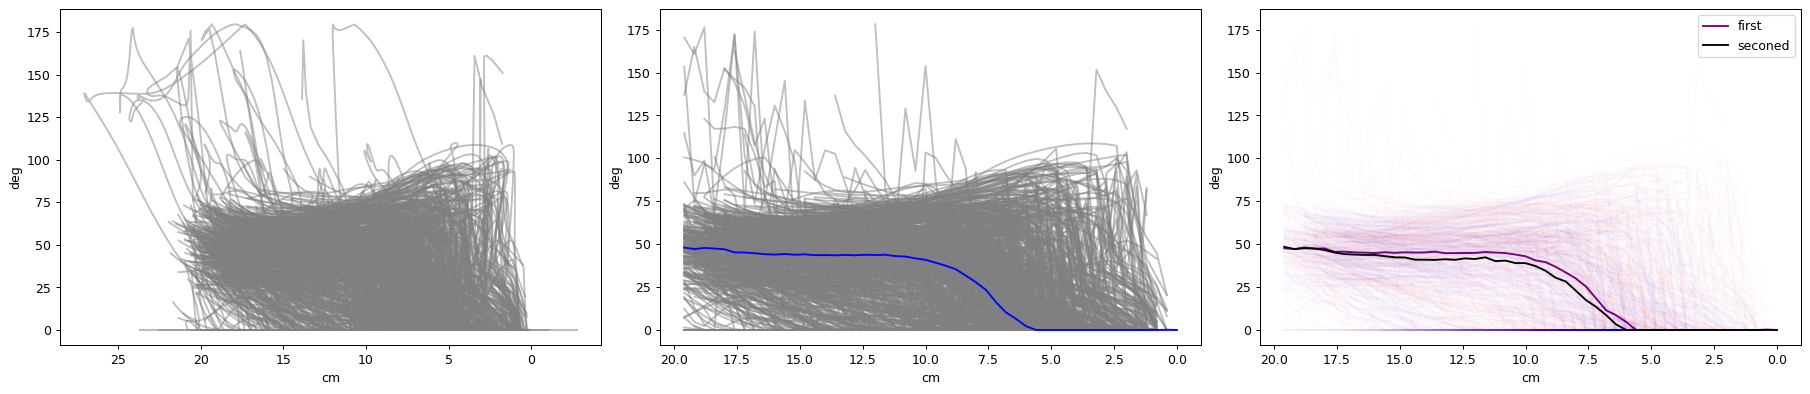

In [185]:
cluster_0 = light_df[(light_df['obstacle_cluster']==0)&(light_df['start']=='top')&(light_df['odd']== 'right')]
cluster_1 = light_df[(light_df['obstacle_cluster']==1)&(light_df['start']=='top')&(light_df['odd']== 'left')]
cluster_4 = light_df[(light_df['obstacle_cluster']==4)&(light_df['start']=='bottom')&(light_df['odd']== 'right')]
cluster_5 = light_df[(light_df['obstacle_cluster']==0)&(light_df['start']=='bottom')&(light_df['odd']== 'left')]

long_df = pd.concat([cluster_0,cluster_1,cluster_4,cluster_5])

fig = plt.figure(constrained_layout=False, figsize=(20, 8),dpi=90)
spec2 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])
panel_3 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[2])

ax1 = fig.add_subplot(panel_1[0,0])
ax2 = fig.add_subplot(panel_2[0,0])
ax3 = fig.add_subplot(panel_3[0,0])

ax1.set_ylabel('deg')
ax1.set_xlabel('cm')
ax2.set_ylabel('deg')
ax2.set_xlabel('cm')
ax3.set_ylabel('deg')
ax3.set_xlabel('cm')

for ind,row in long_df.iterrows():
    #length = int(row['len_facing_corner'])
    length = np.argwhere(row['distance_from_edge']>0).max()
    ax1.plot(row['distance_from_edge'][:length],row['zero_out_angle_to_corner'][:length],c = 'grey',alpha = .5)
ax1.invert_xaxis()
rows = long_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 

for i,row in enumerate(long_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax2.plot(xnew,ynew,c = 'grey',alpha = .5)
ax2.invert_xaxis()
print(distance_array.shape,angle_array.shape)
ax2.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'blue')
by_consecutive = long_df.groupby(['consecutive'])
for con,con_df in by_consecutive:
    if con == 1:
        first_df = con_df
    if con ==2:
        sec_df = con_df
rows = first_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 
for i,row in enumerate(first_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax3.plot(xnew,ynew,c = 'red',alpha = .01)
ax3.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'purple',label = 'first')
print(distance_array.shape,angle_array.shape)
rows = sec_df.shape[0]
angle_array_sec = np.empty([rows,50])
angle_array_sec[:] =np.nan 
distance_array_sec = np.empty([rows,50])
distance_array_sec[:] =np.nan 
for i,row in enumerate(sec_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array_sec[i] = xnew
    angle_array_sec[i] = ynew
    ax3.plot(xnew,ynew,c = 'blue',alpha = .01)
ax3.plot(np.nanmedian(distance_array_sec,axis = 0),np.nanmedian(angle_array_sec,axis = 0),c = 'black',label = 'seconed')
print(distance_array_sec.shape,angle_array_sec.shape)
ax3.invert_xaxis()
ax3.legend()

32.15327382206179 28.91465415016931


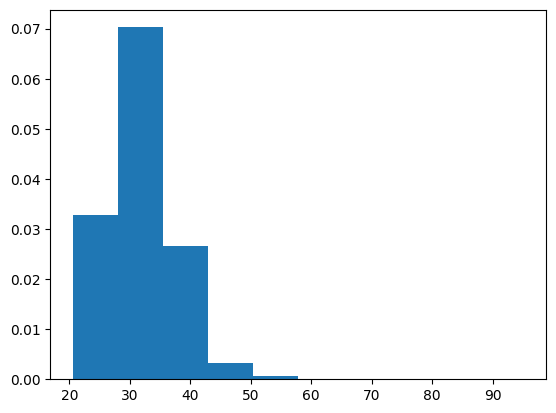

In [277]:
for ind,row in long_df.iterrows():
    #length = int(row['len_facing_corner'])
    length = np.argwhere(row['distance_from_edge']>-3).max()
    distance = np.nansum(row['ts_distance'][:length])
    speed = np.nanmean(row['ts_speed'][:length])

    long_df.at[ind,'distance_traveled'] = distance
    long_df.at[ind,'speed1']  = speed

plt.hist(long_df.distance_traveled,density = True)
print(np.nanmean(long_df.distance_traveled),np.nanmean(long_df.speed1))

(573, 50) (573, 50)
(325, 50) (325, 50)
(248, 50) (248, 50)


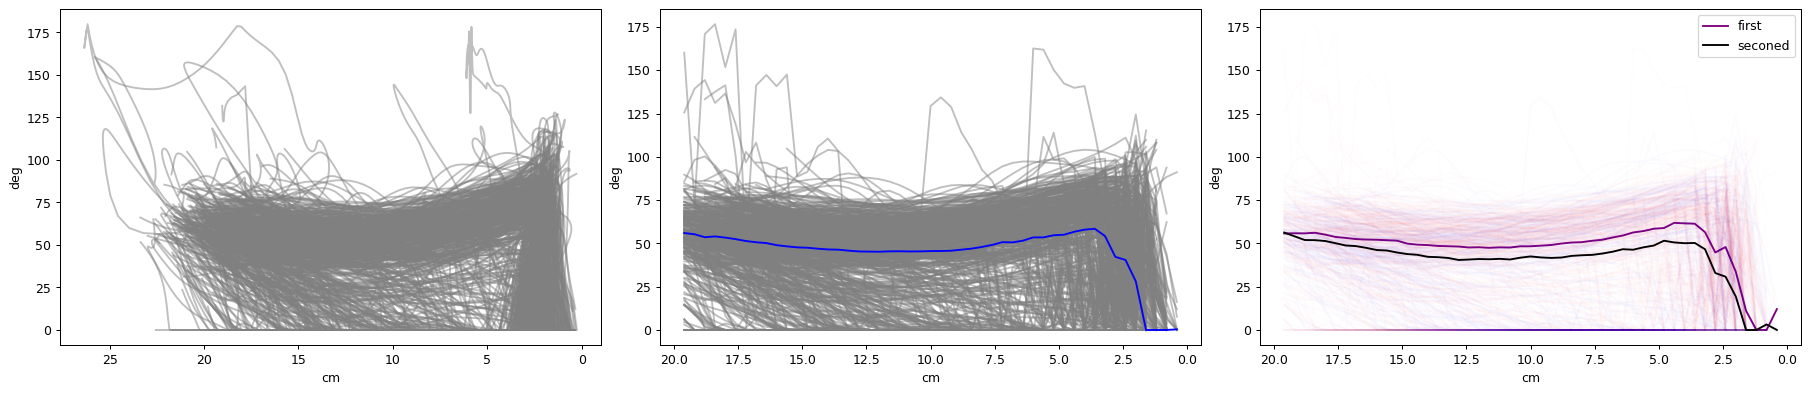

In [186]:
cluster_0 = dark_df[(dark_df['obstacle_cluster']==0)&(dark_df['start']=='top')&(dark_df['odd']== 'right')]
cluster_1 = dark_df[(dark_df['obstacle_cluster']==1)&(dark_df['start']=='top')&(dark_df['odd']== 'left')]
cluster_4 = dark_df[(dark_df['obstacle_cluster']==4)&(dark_df['start']=='bottom')&(dark_df['odd']== 'right')]
cluster_5 = dark_df[(dark_df['obstacle_cluster']==5)&(dark_df['start']=='bottom')&(dark_df['odd']== 'left')]

dark_long_df = pd.concat([cluster_0,cluster_1,cluster_4,cluster_5])

fig = plt.figure(constrained_layout=False, figsize=(20, 8),dpi=90)
spec2 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])
panel_3 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[2])

ax1 = fig.add_subplot(panel_1[0,0])
ax2 = fig.add_subplot(panel_2[0,0])
ax3 = fig.add_subplot(panel_3[0,0])

ax1.set_ylabel('deg')
ax1.set_xlabel('cm')
ax2.set_ylabel('deg')
ax2.set_xlabel('cm')
ax3.set_ylabel('deg')
ax3.set_xlabel('cm')

for ind,row in dark_long_df.iterrows():
    #length = int(row['len_facing_corner'])
    length = np.argwhere(row['distance_from_edge']>0).max()
    ax1.plot(row['distance_from_edge'][:length],row['zero_out_angle_to_corner'][:length],c = 'grey',alpha = .5)
ax1.invert_xaxis()
rows = dark_long_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 

for i,row in enumerate(dark_long_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax2.plot(xnew,ynew,c = 'grey',alpha = .5)
ax2.invert_xaxis()
print(distance_array.shape,angle_array.shape)
ax2.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'blue')
by_consecutive = dark_long_df.groupby(['consecutive'])
for con,con_df in by_consecutive:
    if con == 1:
        first_df = con_df
    if con ==2:
        sec_df = con_df
rows = first_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 
for i,row in enumerate(first_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax3.plot(xnew,ynew,c = 'red',alpha = .01)
ax3.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'purple',label = 'first')
print(distance_array.shape,angle_array.shape)
rows = sec_df.shape[0]
angle_array_sec = np.empty([rows,50])
angle_array_sec[:] =np.nan 
distance_array_sec = np.empty([rows,50])
distance_array_sec[:] =np.nan 
for i,row in enumerate(sec_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array_sec[i] = xnew
    angle_array_sec[i] = ynew
    ax3.plot(xnew,ynew,c = 'blue',alpha = .01)
ax3.plot(np.nanmedian(distance_array_sec,axis = 0),np.nanmedian(angle_array_sec,axis = 0),c = 'black',label = 'seconed')
print(distance_array_sec.shape,angle_array_sec.shape)
ax3.invert_xaxis()
ax3.legend()

34.72259571268326 24.550113937910915


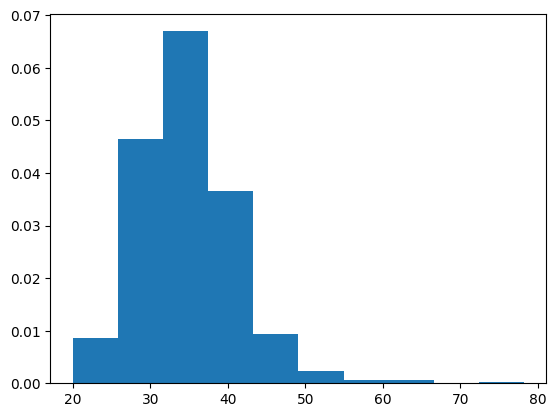

In [278]:
for ind,row in dark_long_df.iterrows():
    #length = int(row['len_facing_corner'])
    length = np.argwhere(row['distance_from_edge']>-3).max()
    distance = np.nansum(row['ts_distance'][:length])
    speed = np.nanmean(row['ts_speed'][:length])

    dark_long_df.at[ind,'distance_traveled'] = distance
    dark_long_df.at[ind,'speed1']  = speed

plt.hist(dark_long_df.distance_traveled,density = True)
print(np.nanmean(dark_long_df.distance_traveled),np.nanmean(dark_long_df.speed1))

(array([0.03746675, 0.06762292, 0.02619627, 0.00289377, 0.00060922,
        0.0001523 , 0.0001523 , 0.        , 0.00030461, 0.00030461]),
 array([21.47097629, 28.84002385, 36.20907141, 43.57811897, 50.94716653,
        58.31621409, 65.68526165, 73.05430921, 80.42335677, 87.79240433,
        95.16145189]),
 <BarContainer object of 10 artists>)

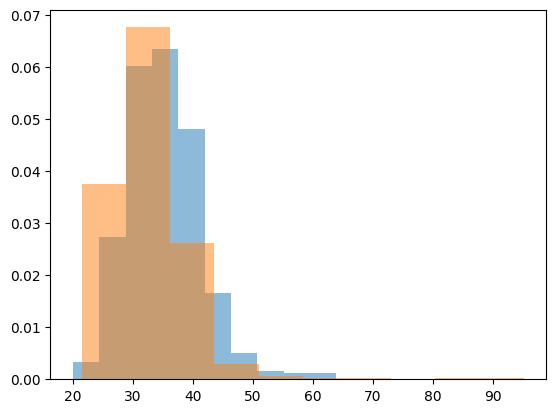

In [74]:
plt.hist(dark_long_df['distance_traveled'],alpha = .5,density=True)
plt.hist(long_df['distance_traveled'],alpha = .5,density=True)

In [77]:
long_df['speed1'].mean()

28.918527358711838

(array([0.00332819, 0.00947255, 0.01792105, 0.04096239, 0.04557066,
        0.05171502, 0.03661014, 0.01254473, 0.00742443, 0.00256015]),
 array([ 7.64572415, 12.02958718, 16.4134502 , 20.79731323, 25.18117626,
        29.56503928, 33.94890231, 38.33276534, 42.71662837, 47.10049139,
        51.48435442]),
 <BarContainer object of 10 artists>)

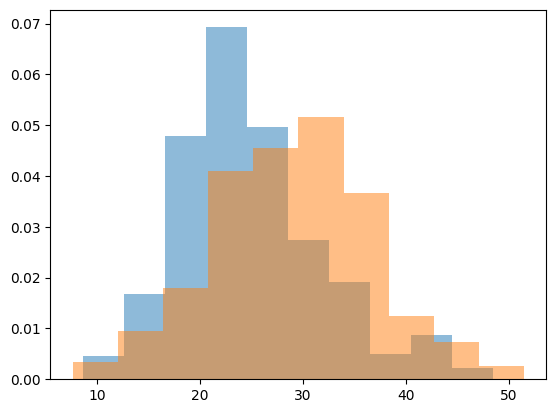

In [73]:
plt.hist(dark_long_df['speed1'],alpha = .5,density=True)
plt.hist(long_df['speed1'],alpha = .5,density=True)

(301, 50) (301, 50)
(145, 50) (145, 50)
(156, 50) (156, 50)


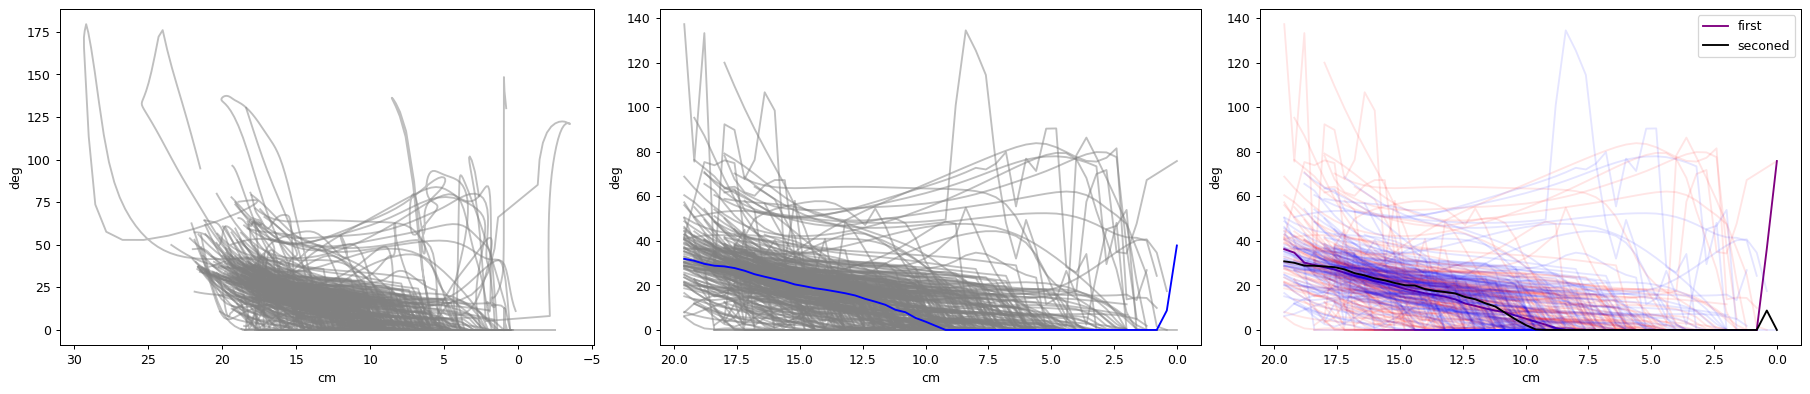

In [1804]:
cluster = 3 
#start = 'top'
direction = 'left'
#cut_off =  reject_outliers(light_df['time'][(light_df['obstacle_cluster']==cluster)  & (light_df['odd']== direction) & (light_df['start']== start)],m=1).max()

#df = light_df[(light_df['obstacle_cluster']==cluster)&(light_df['start']==start)&(light_df['time']<=cut_off)& (light_df['odd']== direction)]
df = light_df[(light_df['obstacle_cluster']==cluster)&(light_df['odd']== direction)]

fig = plt.figure(constrained_layout=False, figsize=(20, 8),dpi=90)
spec2 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])
panel_3 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[2])

ax1 = fig.add_subplot(panel_1[0,0])
ax2 = fig.add_subplot(panel_2[0,0])
ax3 = fig.add_subplot(panel_3[0,0])

ax1.set_ylabel('deg')
ax1.set_xlabel('cm')
ax2.set_ylabel('deg')
ax2.set_xlabel('cm')
ax3.set_ylabel('deg')
ax3.set_xlabel('cm')

for ind,row in df.iterrows():
    #length = int(row['len_facing_corner'])
    length = np.argwhere(row['distance_from_edge']>0).max()
    ax1.plot(row['distance_from_edge'][:length],row['zero_out_angle_to_corner'][:length],c = 'grey',alpha = .5)
ax1.invert_xaxis()
rows = df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 

for i,row in enumerate(df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax2.plot(xnew,ynew,c = 'grey',alpha = .5)
ax2.invert_xaxis()
print(distance_array.shape,angle_array.shape)
ax2.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'blue')
by_consecutive = df.groupby(['consecutive'])
for con,con_df in by_consecutive:
    if con == 1:
        first_df = con_df
    if con ==2:
        sec_df = con_df
rows = first_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 
for i,row in enumerate(first_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax3.plot(xnew,ynew,c = 'red',alpha = .1)
ax3.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'purple',label = 'first')
print(distance_array.shape,angle_array.shape)
rows = sec_df.shape[0]
angle_array_sec = np.empty([rows,50])
angle_array_sec[:] =np.nan 
distance_array_sec = np.empty([rows,50])
distance_array_sec[:] =np.nan 
for i,row in enumerate(sec_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array_sec[i] = xnew
    angle_array_sec[i] = ynew
    ax3.plot(xnew,ynew,c = 'blue',alpha = .1)
ax3.plot(np.nanmedian(distance_array_sec,axis = 0),np.nanmedian(angle_array_sec,axis = 0),c = 'black',label = 'seconed')
print(distance_array_sec.shape,angle_array_sec.shape)
ax3.invert_xaxis()
ax3.legend()

(253, 50) (253, 50)
(119, 50) (119, 50)
(134, 50) (134, 50)


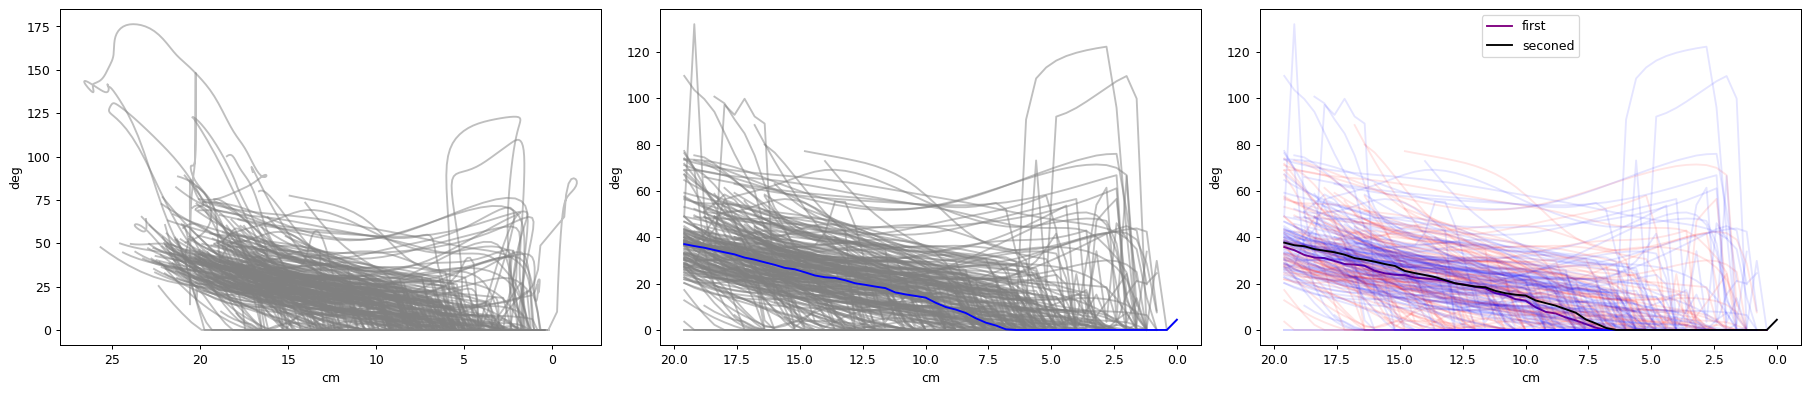

In [1805]:

#cut_off =  reject_outliers(dark_df['time'][(dark_df['obstacle_cluster']==cluster)  & (dark_df['odd']== direction) & (dark_df['start']== start)],m=1).max()

#df = dark_df[(dark_df['obstacle_cluster']==cluster)&(dark_df['start']==start)&(dark_df['time']<=cut_off)& (dark_df['odd']== direction)]
df = dark_df[(dark_df['obstacle_cluster']==cluster)&(dark_df['odd']== direction)]

fig = plt.figure(constrained_layout=False, figsize=(20, 8),dpi=90)
spec2 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
panel_1 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[0])
panel_2 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[1])
panel_3 = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=spec2[2])

ax1 = fig.add_subplot(panel_1[0,0])
ax2 = fig.add_subplot(panel_2[0,0])
ax3 = fig.add_subplot(panel_3[0,0])

ax1.set_ylabel('deg')
ax1.set_xlabel('cm')
ax2.set_ylabel('deg')
ax2.set_xlabel('cm')
ax3.set_ylabel('deg')
ax3.set_xlabel('cm')

for ind,row in df.iterrows():
    #length = int(row['len_facing_corner'])
    length = np.argwhere(row['distance_from_edge']>0).max()
    ax1.plot(row['distance_from_edge'][:length],row['zero_out_angle_to_corner'][:length],c = 'grey',alpha = .5)
ax1.invert_xaxis()
rows = df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 

for i,row in enumerate(df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax2.plot(xnew,ynew,c = 'grey',alpha = .5)
ax2.invert_xaxis()
print(distance_array.shape,angle_array.shape)
ax2.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'blue')
by_consecutive = df.groupby(['consecutive'])
for con,con_df in by_consecutive:
    if con == 1:
        first_df = con_df
    if con ==2:
        sec_df = con_df
rows = first_df.shape[0]
angle_array = np.empty([rows,50])
angle_array[:] =np.nan 
distance_array = np.empty([rows,50])
distance_array[:] =np.nan 
for i,row in enumerate(first_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array[i] = xnew
    angle_array[i] = ynew
    ax3.plot(xnew,ynew,c = 'red',alpha = .1)
ax3.plot(np.nanmedian(distance_array,axis = 0),np.nanmedian(angle_array,axis = 0),c = 'purple',label = 'first')
print(distance_array.shape,angle_array.shape)
rows = sec_df.shape[0]
angle_array_sec = np.empty([rows,50])
angle_array_sec[:] =np.nan 
distance_array_sec = np.empty([rows,50])
distance_array_sec[:] =np.nan 
for i,row in enumerate(sec_df.iterrows()):
    
    #length = int(row[1]['len_facing_corner'])
    length = np.argwhere(row[1]['distance_from_edge']>0).max()
    interpolater = interp1d(row[1]['distance_from_edge'][:length],row[1]['zero_out_angle_to_corner'][:length],fill_value=np.nan,bounds_error=False)
    xnew =  np.arange(0, 20, .4)
    ynew = interpolater(xnew)
    distance_array_sec[i] = xnew
    angle_array_sec[i] = ynew
    ax3.plot(xnew,ynew,c = 'blue',alpha = .1)
ax3.plot(np.nanmedian(distance_array_sec,axis = 0),np.nanmedian(angle_array_sec,axis = 0),c = 'black',label = 'seconed')
print(distance_array_sec.shape,angle_array_sec.shape)
ax3.invert_xaxis()
ax3.legend()